In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [3]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

Sample no.  Easting  Northing  MassArea  Thickness  [-5,-4)  [-4,-3)  \
0   VF95-06a     3133      9522    417.20         40      0.0     11.0   
1   VF95-08a     1907      8096    312.90         30      1.0     13.0   
2   VF97-20Q     5500      8723    208.60         20      2.0      7.0   
3  VF98-01a3     2665      9054    239.89         23      4.0     13.0   
4   VF98-02a     1154      7735    156.45         15      1.0     12.0   

   [-3,-2)  [-2,-1)  [-1,0)  [0,1)  [1,2)  [2,3)  [3,4)        radius  
0     21.0     22.0    23.0   17.0    4.0    0.0    0.0  10024.179418  
1     19.0     24.0    25.0   16.0    3.0    0.0    0.0   8317.563646  
2     14.0     21.0    26.0   21.0    6.0    1.0    1.0  10312.164128  
3     18.0     21.0    23.0   15.0    3.0    0.0    0.0   9438.068711  
4     19.0     23.0    24.0   17.0    3.0    0.0    0.0   7820.610015

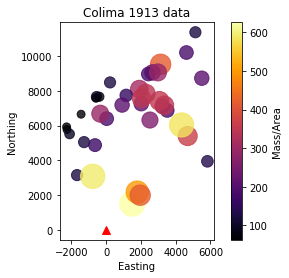

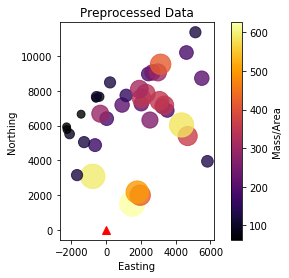

In [4]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [5]:
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

Easting  Northing  Elevation  MassArea   [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506          0   732.730  23.15290  25.4668  22.2407   
18     1957      1997          0   691.154  21.35410  24.7682  22.4602   
17     1787      2173          0   709.841  21.21370  24.7100  22.4801   
37     -770      3082          0   301.066  13.80220  19.2173  22.1297   
31    -1673      3152          0   149.680   9.51561  14.8613  20.3208   

    [-2,-1)    [-1,0)     [0,1)     [1,2)     [2,3)     [3,4)       radius  \
16  15.7304   8.99492   3.44384  0.823464  0.136596  0.010359  2124.861643   
18  16.5434   9.82586   3.90198  0.968656  0.164832  0.012894  2796.043276   
17  16.6062   9.88889   3.93999  0.980849  0.167220  0.013114  2813.413940   
37  20.4626  14.72470   7.12663  2.105690  0.398324  0.032906  3176.731654   
31  22.2637  18.49420  10.31720  3.459940  0.706562  0.060698  3568.477687   

      Residual  
16  117.086929  
18  165.664909  
17  141.786713  
37   50.641032  
31  119.590924

In [6]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100

display(t2_const_df.head())

Easting  Northing  Elevation  MassArea  [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506       2500  1394.460  17.2005  24.2121  24.7779   
18     1957      1997       2500  1216.150  14.0160  22.3619  24.8640   
17     1787      2173       2500  1251.000  13.8770  22.2837  24.8861   
37     -770      3082       2500   359.399  14.8025  22.8299  24.5313   
31    -1673      3152       2500   134.301  15.3664  23.3283  24.4813   

    [-2,-1)   [-1,0)    [0,1)     [1,2)     [2,3)     [3,4)       radius  \
16  18.9162  10.8457  3.58293  0.449327  0.015328  0.000028  2124.861643   
18  20.2838  12.7356  4.93885  0.769130  0.030705  0.000063  2796.043276   
17  20.3522  12.8046  4.98427  0.780754  0.031310  0.000064  2813.413940   
37  19.4545  12.2828  5.13528  0.922533  0.041096  0.000091  3176.731654   
31  18.8191  11.7036  5.16746  1.079070  0.054478  0.000132  3568.477687   

      Residual  
16  222.828380  
18  291.502876  
17  249.880153  
37   60.452978  
31  107.303452

In [7]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

centroid  density interval  lower  probability  upper
0      -4.5   1024.0  [-5,-4)   -5.0     0.068338   -4.0
1      -3.5   1024.0  [-4,-3)   -4.0     0.109203   -3.0
2      -2.5   1024.0  [-3,-2)   -3.0     0.146694   -2.0
3      -1.5   1024.0  [-2,-1)   -2.0     0.165650   -1.0
4      -0.5   1024.0   [-1,0)   -1.0     0.157243    0.0
5       0.5   1233.5    [0,1)    0.0     0.125474    1.0
6       1.5   1443.0    [1,2)    1.0     0.084166    2.0
7       2.5   1652.5    [2,3)    2.0     0.047459    3.0
8       3.5   1862.0    [3,4)    3.0     0.022496    4.0

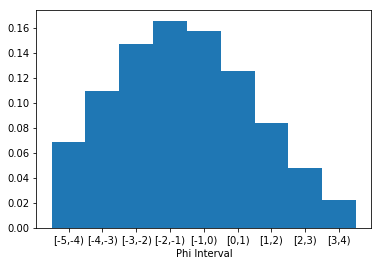

In [8]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [9]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.06250 seconds


Northing  Easting    [-5,-4)    [-4,-3)    [-3,-2)    [-2,-1)     [-1,0)  \
0      1506     1499  17.023654  24.058691  24.746126  19.010648  10.986457   
1      1997     1957  13.849036  22.187896  24.802962  20.364657  12.884741   
2      2173     1787  13.800371  22.209864  24.864958  20.379976  12.855621   
3      3082     -770  15.561092  23.674710  24.901902  19.059630  11.448421   
4      3152    -1673  16.255639  24.321103  24.942842  18.429623  10.768184   

      [0,1)     [1,2)     [2,3)     [3,4)     MassArea       radius  \
0  3.680616  0.476505  0.017266  0.000036  1316.804462  2124.861643   
1  5.062941  0.813217  0.034469  0.000080  1148.987823  2796.043276   
2  5.043105  0.811521  0.034502  0.000081  1166.987337  2813.413940   
3  4.522511  0.794749  0.036892  0.000093   300.904559  3176.731654   
4  4.367639  0.869463  0.045380  0.000126   111.014810  3568.477687   

     Residual  
0  210.419377  
1  275.404560  
2  233.099101  
3   50.613877  
4   88.698314

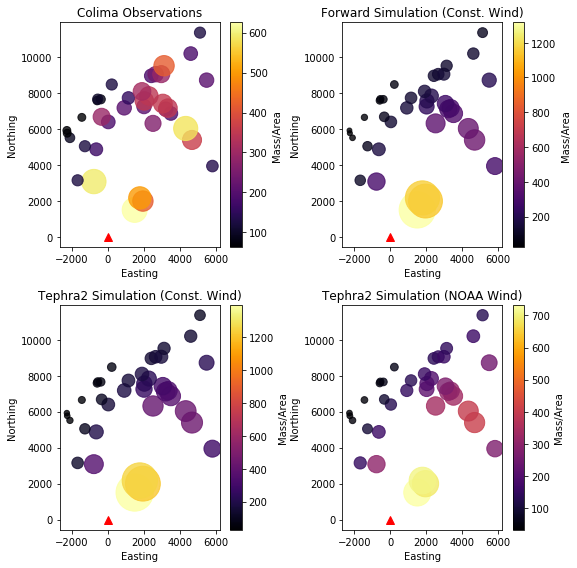

c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


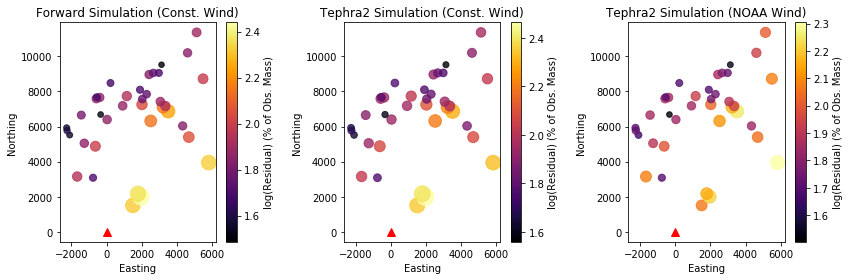

In [10]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

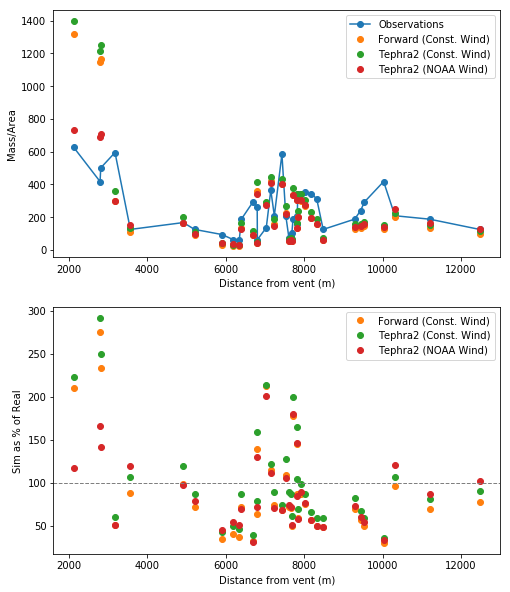

In [11]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Const. Wind Simulation========
a* = -3.89485	b* = -0.42836	            h1* = 1.77402	u* = 1.72849	v* = 2.07786
a = 1.02035	b = 1.65158	            h1 = 25318.80578	u = 5.63215	v = 7.98736
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 640
SSE: 2.0911494895599056


Height  Suspended Mass
0    4430.75    5.368443e+09
1    5776.50    5.213486e+09
2    7122.25    5.017887e+09
3    8468.00    4.800879e+09
4    9813.75    4.568143e+09
5   11159.50    4.321735e+09
6   12505.25    4.062187e+09
7   13851.00    3.789141e+09
8   15196.75    3.501535e+09
9   16542.50    3.197567e+09
10  17888.25    2.874479e+09
11  19234.00    2.528061e+09
12  20579.75    2.151607e+09
13  21925.50    1.733382e+09
14  23271.25    1.248982e+09
15  24617.00    6.224874e+08
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

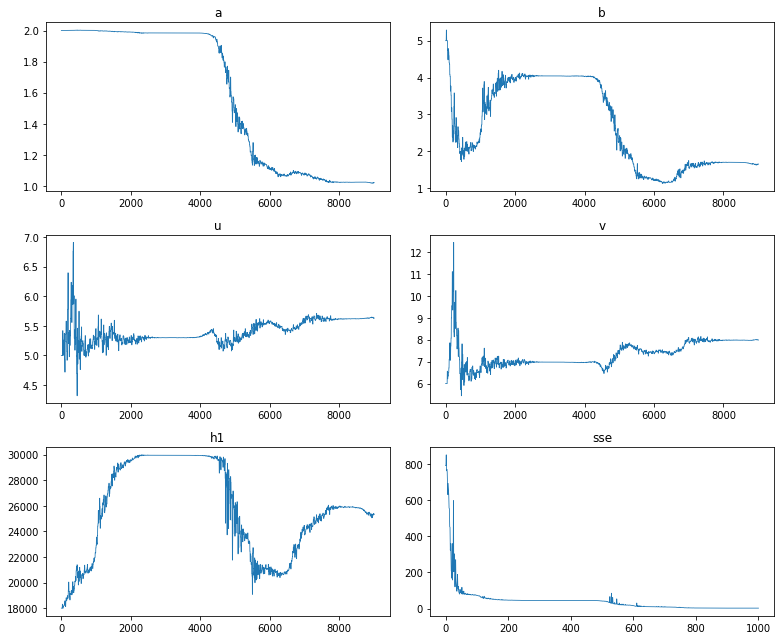

Const. Wind Simulation Run Time: 1.87943 minutes


========T2 Const. Wind Simulation========
a* = -2.29006	b* = 0.05039	            h1* = 1.72498	u* = 1.68637	v* = 2.17622
a = 1.10126	b = 2.05168	            h1 = 25103.83501	u = 5.39984	v = 8.81290
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 643
SSE: 9.48366473747491


Height  Suspended Mass
0    4430.75    5.903276e+09
1    5776.50    5.899718e+09
2    7122.25    5.697684e+09
3    8468.00    5.405306e+09
4    9813.75    5.059474e+09
5   11159.50    4.677818e+09
6   12505.25    4.270399e+09
7   13851.00    3.843664e+09
8   15196.75    3.402125e+09
9   16542.50    2.949188e+09
10  17888.25    2.487629e+09
11  19234.00    2.019917e+09
12  20579.75    1.548508e+09
13  21925.50    1.076260e+09
14  23271.25    6.073751e+08
15  24617.00    1.516565e+08
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

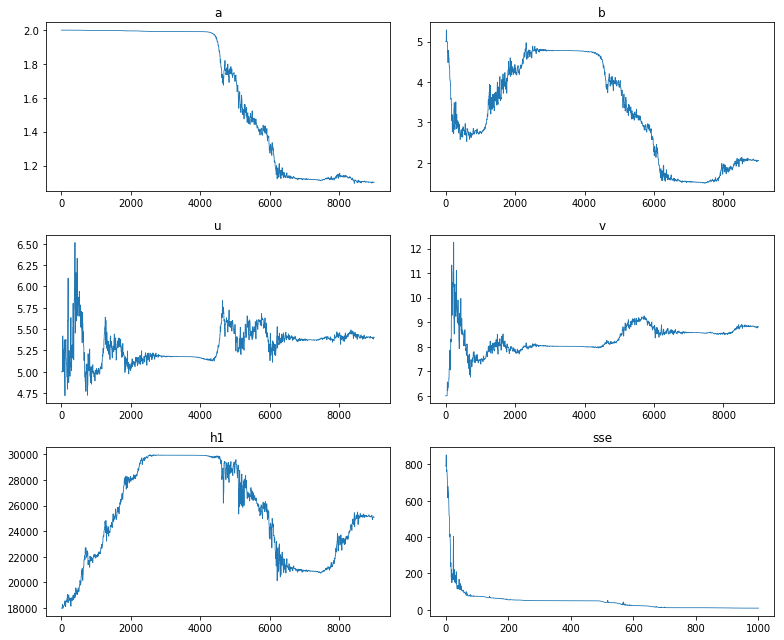

T2 Const. Wind Simulation Run Time: 1.93516 minutes


========T2 NOAA Wind Simulation========
a* = -1.83849	b* = -2.27961	            h1* = 3.19802	u* = 1.72036	v* = 1.99358
a = 1.15906	b = 1.10232	            h1 = 28799.39016	u = 5.58656	v = 7.34180
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 625
SSE: 221.6192150348479


Height  Suspended Mass
0    4430.75    2.314482e+09
1    5776.50    2.569273e+09
2    7122.25    2.723593e+09
3    8468.00    2.832477e+09
4    9813.75    2.914321e+09
5   11159.50    2.977587e+09
6   12505.25    3.026818e+09
7   13851.00    3.064641e+09
8   15196.75    3.092598e+09
9   16542.50    3.111516e+09
10  17888.25    3.121673e+09
11  19234.00    3.122830e+09
12  20579.75    3.114150e+09
13  21925.50    3.093949e+09
14  23271.25    3.059122e+09
15  24617.00    3.003709e+09
16  25962.75    2.914686e+09
17  27308.50    2.753943e+09
18  28654.25    2.188632e+09
19  30000.00    0.000000e+00

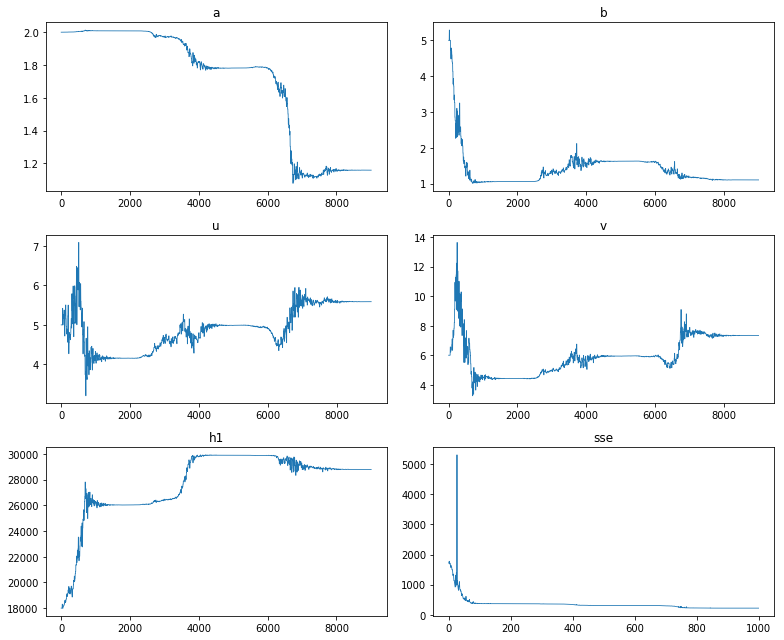

T2 NOAA Wind Simulation Run Time: 1.95859 minutes


========Observation Data========
a* = -0.09530	b* = -0.86118	            h1* = 4.68532	u* = 0.58889	v* = 1.40428
a = 1.90910	b = 1.42266	            h1 = 29724.38029	u = 1.80198	v = 4.07260
Success: True, Optimization terminated successfully.
Iterations: 437
SSE: 866.3987568149621


Height  Suspended Mass
0    4430.75    5.874025e+08
1    5776.50    1.077873e+09
2    7122.25    1.520676e+09
3    8468.00    1.924645e+09
4    9813.75    2.293224e+09
5   11159.50    2.627753e+09
6   12505.25    2.928418e+09
7   13851.00    3.194596e+09
8   15196.75    3.424973e+09
9   16542.50    3.617526e+09
10  17888.25    3.769423e+09
11  19234.00    3.876797e+09
12  20579.75    3.934360e+09
13  21925.50    3.934711e+09
14  23271.25    3.867082e+09
15  24617.00    3.714782e+09
16  25962.75    3.449291e+09
17  27308.50    3.013133e+09
18  28654.25    2.243336e+09
19  30000.00    0.000000e+00

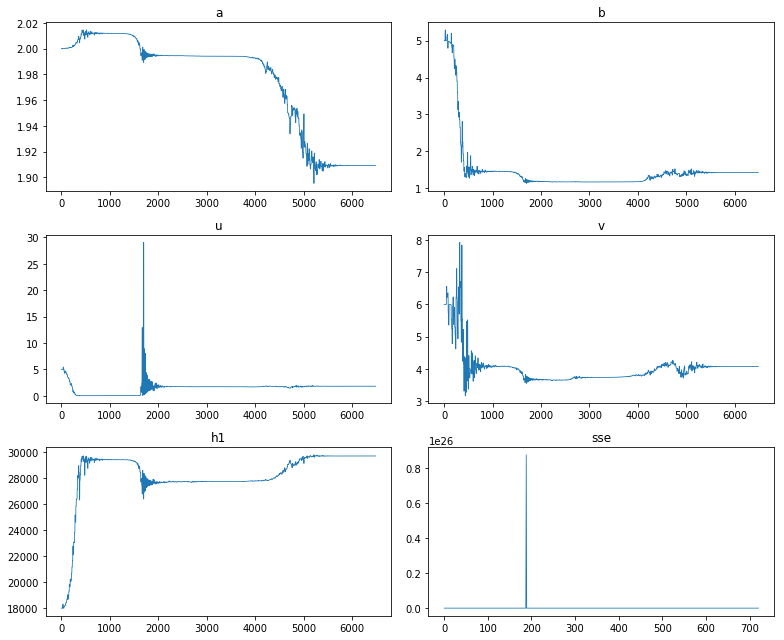

Observation Data Run Time: 1.45052 minutes


Total Run Time: 7.22396 minutes


In [12]:
priors_vals = {
    "a": 2,
    "b": 5,
    "h1": 18000,
    "u": 5,
    "v": 6
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True
}

H = 30000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Const. Wind Simulation", 
         "T2 Const. Wind Simulation",
         "T2 NOAA Wind Simulation", 
         "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_wind_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, 
        config["ERUPTION_MASS"], phi_steps,
        config["DIFFUSION_COEFFICIENT"], 
        config["FALL_TIME_THRESHOLD"], 
        config["EDDY_CONST"],
        invert_params = invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, trace, wind_trace, sse_trace = out
    params_no_wind = list(params.values())
    params_no_wind = params_no_wind[:-2]
    
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params_no_wind, H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    wind_trace = np.array(wind_trace)
    fig, axs = plt.subplots(3,2, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(wind_trace[:,0], linewidth=.8)
    axs[2].set_title("u")

    axs[3].plot(wind_trace[:,1], linewidth=.8)
    axs[3].set_title("v")


    axs[4].plot(trace[:,2], linewidth=.8)
    axs[4].set_title("h1")

    axs[5].plot(sse_trace, linewidth=.8)
    axs[5].set_title("sse")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(name, run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

========Run 0========
{'a': 1.9888034633453247, 'b': 9.821947206954874, 'h1': 28847.559356732287, 'u': 1.4982790201342984, 'v': 4.813461497923748}
a* = -1.43609	b* = -2.08709	            h1* = 3.18093	u* = 0.74163	v* = 1.71877
a = 1.23786	b = 1.12405	            h1 = 28779.13263	u = 2.09935	v = 5.57768
Success: True, Optimization terminated successfully.
Iterations: 385
SSE: 749.9795638940099


Height  Suspended Mass
0    4430.75    2.005735e+09
1    5776.50    2.348617e+09
2    7122.25    2.567135e+09
3    8468.00    2.727156e+09
4    9813.75    2.851460e+09
5   11159.50    2.950773e+09
6   12505.25    3.030953e+09
7   13851.00    3.095444e+09
8   15196.75    3.146300e+09
9   16542.50    3.184658e+09
10  17888.25    3.210936e+09
11  19234.00    3.224885e+09
12  20579.75    3.225488e+09
13  21925.50    3.210645e+09
14  23271.25    3.176455e+09
15  24617.00    3.115421e+09
16  25962.75    3.011188e+09
17  27308.50    2.816032e+09
18  28654.25    2.100718e+09
19  30000.00    0.000000e+00

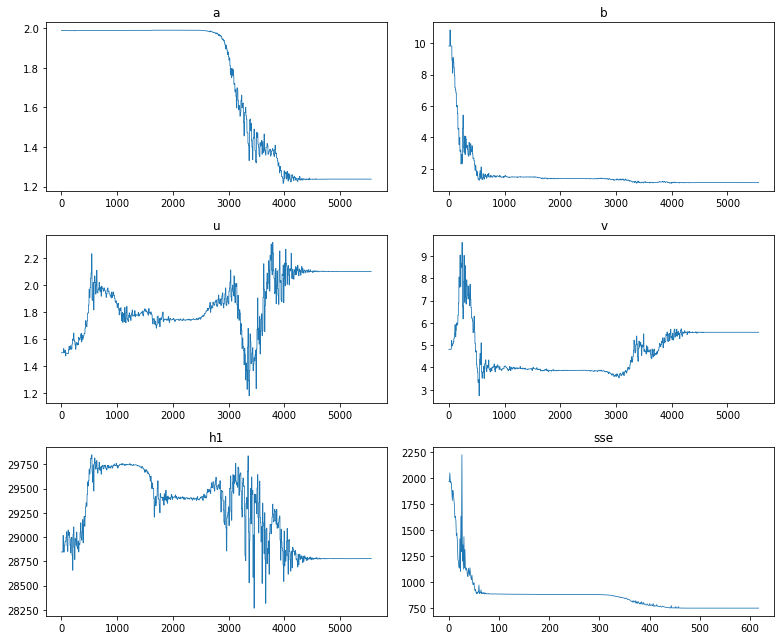

Run 0 Time: 0.99062 minutes

Avg time per run: 0.99062 minutes

Est time remaining: 98.07188 minutes

========Run 1========
{'a': 2.4982498842659338, 'b': 12.78877151842335, 'h1': 10249.69977928604, 'u': 1.9375628757789491, 'v': 0.16090298304637984}
a* = 4.44192	b* = 1.72702	            h1* = 0.56513	u* = 0.31950	v* = 0.84370
a = 85.93827	b = 6.62384	            h1 = 16994.89012	u = 1.37644	v = 2.32496
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 609
SSE: 1394.950406173623


Height  Suspended Mass
0    4430.75    6.385085e-67
1    5776.50    1.251495e-41
2    7122.25    5.523428e-27
3    8468.00    9.916831e-17
4    9813.75    6.430114e-09
5   11159.50    1.063889e-02
6   12505.25    1.182822e+03
7   13851.00    1.343996e+07
8   15196.75    1.284144e+10
9   16542.50    4.214512e+10
10  17888.25    0.000000e+00
11  19234.00    0.000000e+00
12  20579.75    0.000000e+00
13  21925.50    0.000000e+00
14  23271.25    0.000000e+00
15  24617.00    0.000000e+00
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

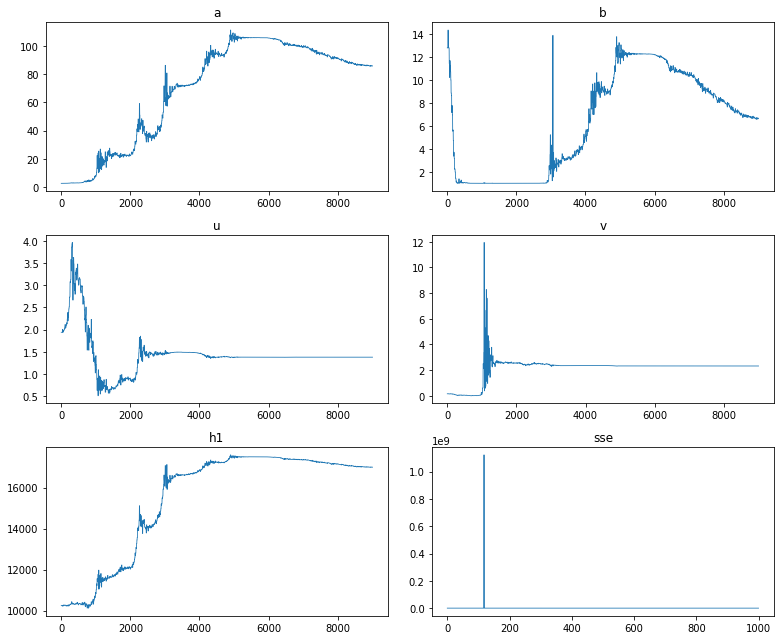

Run 1 Time: 1.59635 minutes

Avg time per run: 1.29349 minutes

Est time remaining: 126.76198 minutes

========Run 2========
{'a': 2.010302266181272, 'b': 3.827331193765047, 'h1': 22683.9688990465, 'u': 5.317561902416192, 'v': 6.834766143260443}
a* = -1.43609	b* = -2.08712	            h1* = 3.18094	u* = 0.74161	v* = 1.71877
a = 1.23786	b = 1.12404	            h1 = 28779.13564	u = 2.09932	v = 5.57768
Success: True, Optimization terminated successfully.
Iterations: 449
SSE: 749.9795639254087


Height  Suspended Mass
0    4430.75    2.005729e+09
1    5776.50    2.348609e+09
2    7122.25    2.567127e+09
3    8468.00    2.727147e+09
4    9813.75    2.851451e+09
5   11159.50    2.950765e+09
6   12505.25    3.030945e+09
7   13851.00    3.095436e+09
8   15196.75    3.146294e+09
9   16542.50    3.184653e+09
10  17888.25    3.210932e+09
11  19234.00    3.224883e+09
12  20579.75    3.225487e+09
13  21925.50    3.210647e+09
14  23271.25    3.176459e+09
15  24617.00    3.115429e+09
16  25962.75    3.011199e+09
17  27308.50    2.816051e+09
18  28654.25    2.100757e+09
19  30000.00    0.000000e+00

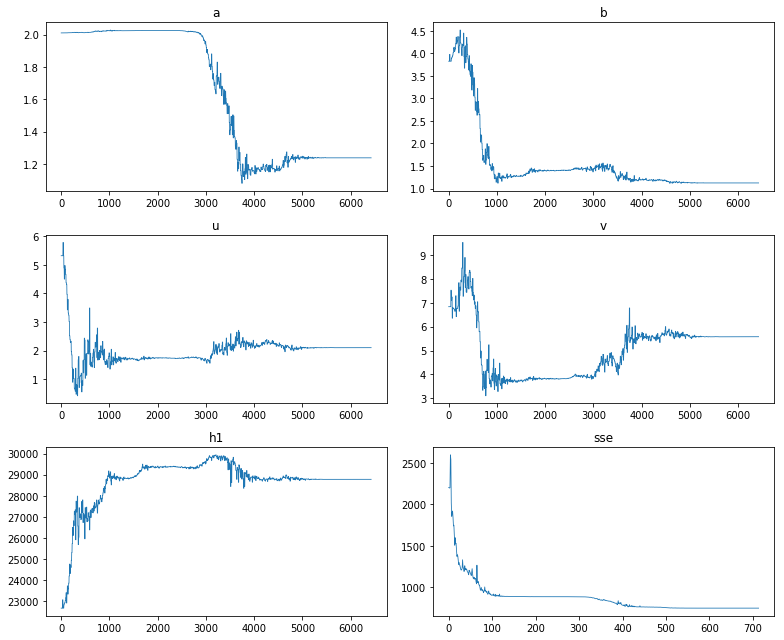

Run 2 Time: 1.13776 minutes

Avg time per run: 1.24167 minutes

Est time remaining: 120.44167 minutes

========Run 3========
{'a': 1.0417044475081398, 'b': 16.59893663796113, 'h1': 10421.353998738188, 'u': 5.114552061251185, 'v': 6.102814947522771}


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:426: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = 10.89141	b* = 10.45397	            h1* = 0.39588	u* = 0.06088	v* = 0.92354
a = 53713.90186	b = 34682.62970	            h1 = 15303.89158	u = 1.06277	v = 2.51818
Success: True, Optimization terminated successfully.
Iterations: 288
SSE: 1632.5121882800133


Height  Suspended Mass
0    4430.75    0.000000e+00
1    5776.50    0.000000e+00
2    7122.25    0.000000e+00
3    8468.00    0.000000e+00
4    9813.75    1.265482e-07
5   11159.50    5.500000e+10
6   12505.25    0.000000e+00
7   13851.00    0.000000e+00
8   15196.75    0.000000e+00
9   16542.50    0.000000e+00
10  17888.25    0.000000e+00
11  19234.00    0.000000e+00
12  20579.75    0.000000e+00
13  21925.50    0.000000e+00
14  23271.25    0.000000e+00
15  24617.00    0.000000e+00
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

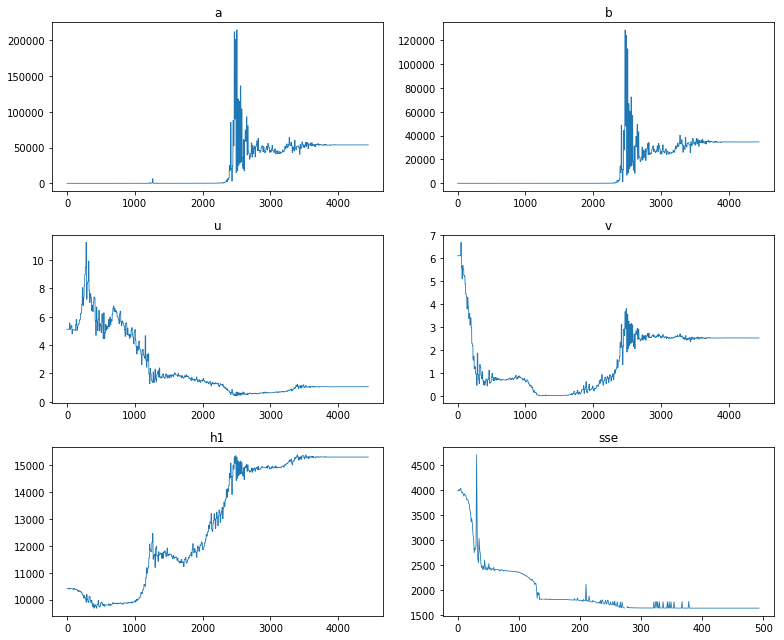

Run 3 Time: 0.79193 minutes

Avg time per run: 1.12923 minutes

Est time remaining: 108.40625 minutes

========Run 4========
{'a': 1.341567948578351, 'b': 7.04333563908743, 'h1': 14134.053631823286, 'u': 1.9377610742516476, 'v': 7.146461906216921}
a* = -1.53303	b* = -2.51497	            h1* = 2.14581	u* = 0.74330	v* = 1.77167
a = 1.21588	b = 1.08087	            h1 = 26688.26659	u = 2.10286	v = 5.88065
Success: True, Optimization terminated successfully.
Iterations: 537
SSE: 779.3776477989175


Height  Suspended Mass
0    4430.75    2.265773e+09
1    5776.50    2.618259e+09
2    7122.25    2.842440e+09
3    8468.00    3.007189e+09
4    9813.75    3.136079e+09
5   11159.50    3.240126e+09
6   12505.25    3.325301e+09
7   13851.00    3.395074e+09
8   15196.75    3.451460e+09
9   16542.50    3.495480e+09
10  17888.25    3.527322e+09
11  19234.00    3.546290e+09
12  20579.75    3.550475e+09
13  21925.50    3.535858e+09
14  23271.25    3.493829e+09
15  24617.00    3.402291e+09
16  25962.75    3.166753e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

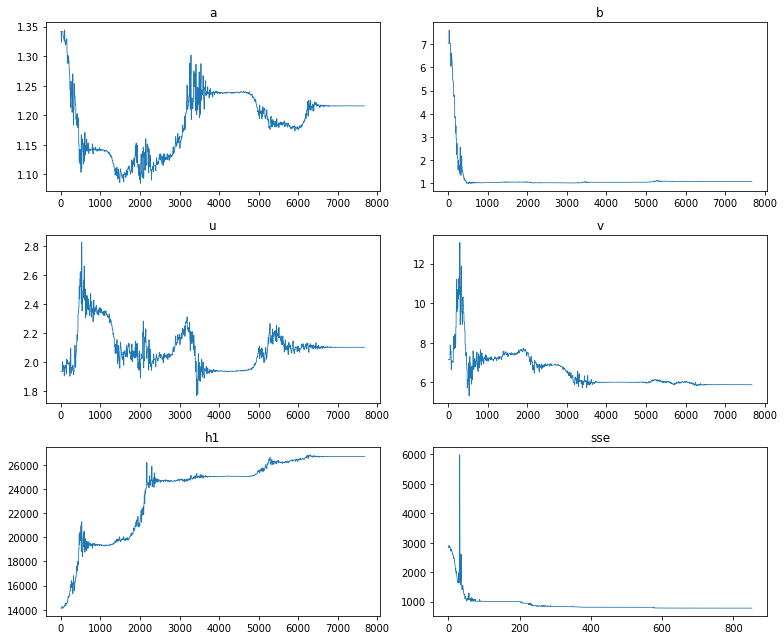

Run 4 Time: 1.36875 minutes

Avg time per run: 1.17714 minutes

Est time remaining: 111.82786 minutes

========Run 5========
{'a': 1.2145166556504974, 'b': 1.1028481927635208, 'h1': 17248.05865295489, 'u': 6.047289901589007, 'v': 3.459734624080406}
a* = -1.51979	b* = -2.59891	            h1* = 1.89684	u* = 0.73676	v* = 1.80019
a = 1.21876	b = 1.07435	            h1 = 25820.14930	u = 2.08915	v = 6.05082
Success: True, Optimization terminated successfully.
Iterations: 405
SSE: 806.1631953174613


Height  Suspended Mass
0    4430.75    2.393566e+09
1    5776.50    2.772042e+09
2    7122.25    3.013539e+09
3    8468.00    3.191509e+09
4    9813.75    3.331110e+09
5   11159.50    3.444091e+09
6   12505.25    3.536801e+09
7   13851.00    3.612901e+09
8   15196.75    3.674468e+09
9   16542.50    3.722463e+09
10  17888.25    3.756857e+09
11  19234.00    3.776482e+09
12  20579.75    3.778426e+09
13  21925.50    3.756363e+09
14  23271.25    3.695153e+09
15  24617.00    3.544229e+09
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

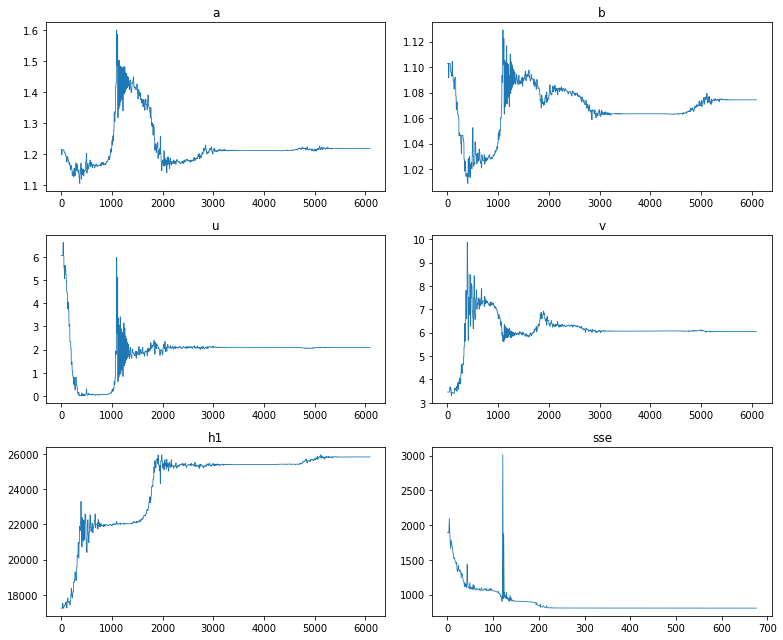

Run 5 Time: 1.08880 minutes

Avg time per run: 1.16241 minutes

Est time remaining: 109.26684 minutes

========Run 6========
{'a': 2.519751798107137, 'b': 2.655162745981845, 'h1': 24183.794080949978, 'u': 13.98987007751516, 'v': 0.4727323287358277}
a* = -1.43611	b* = -2.08713	            h1* = 3.18093	u* = 0.74164	v* = 1.71878
a = 1.23785	b = 1.12404	            h1 = 28779.12179	u = 2.09937	v = 5.57770
Success: True, Optimization terminated successfully.
Iterations: 431
SSE: 749.979563956829


Height  Suspended Mass
0    4430.75    2.005746e+09
1    5776.50    2.348623e+09
2    7122.25    2.567137e+09
3    8468.00    2.727155e+09
4    9813.75    2.851458e+09
5   11159.50    2.950769e+09
6   12505.25    3.030948e+09
7   13851.00    3.095438e+09
8   15196.75    3.146294e+09
9   16542.50    3.184651e+09
10  17888.25    3.210929e+09
11  19234.00    3.224880e+09
12  20579.75    3.225483e+09
13  21925.50    3.210642e+09
14  23271.25    3.176454e+09
15  24617.00    3.115423e+09
16  25962.75    3.011194e+09
17  27308.50    2.816045e+09
18  28654.25    2.100731e+09
19  30000.00    0.000000e+00

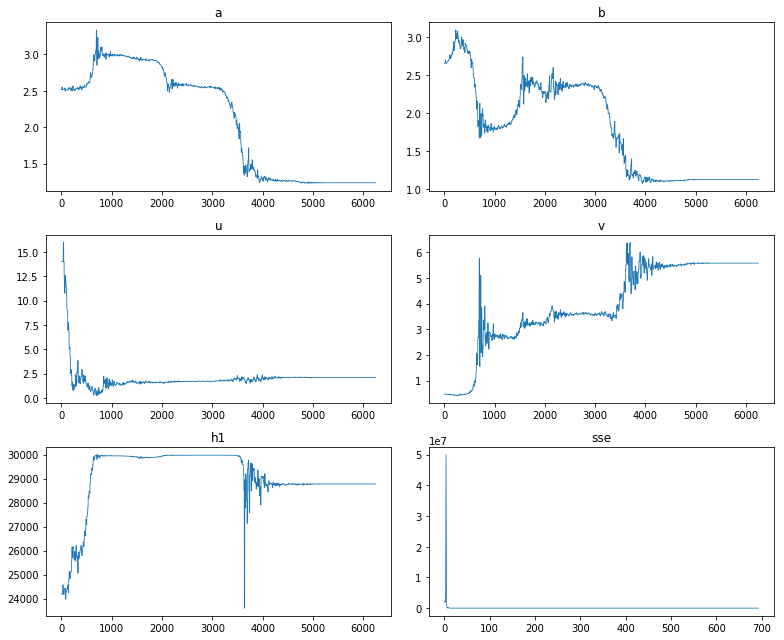

Run 6 Time: 1.10182 minutes

Avg time per run: 1.15376 minutes

Est time remaining: 107.29944 minutes

========Run 7========
{'a': 1.620261274685935, 'b': 7.996517229978231, 'h1': 21397.466716069583, 'u': 1.2839987430099824, 'v': 3.07270151367811}
a* = -1.53306	b* = -2.51498	            h1* = 2.14587	u* = 0.74327	v* = 1.77169
a = 1.21587	b = 1.08086	            h1 = 26688.45426	u = 2.10279	v = 5.88081
Success: True, Optimization terminated successfully.
Iterations: 341
SSE: 779.3776482474809


Height  Suspended Mass
0    4430.75    2.265798e+09
1    5776.50    2.618276e+09
2    7122.25    2.842451e+09
3    8468.00    3.007194e+09
4    9813.75    3.136080e+09
5   11159.50    3.240124e+09
6   12505.25    3.325295e+09
7   13851.00    3.395065e+09
8   15196.75    3.451449e+09
9   16542.50    3.495468e+09
10  17888.25    3.527309e+09
11  19234.00    3.546276e+09
12  20579.75    3.550461e+09
13  21925.50    3.535846e+09
14  23271.25    3.493820e+09
15  24617.00    3.402292e+09
16  25962.75    3.166797e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

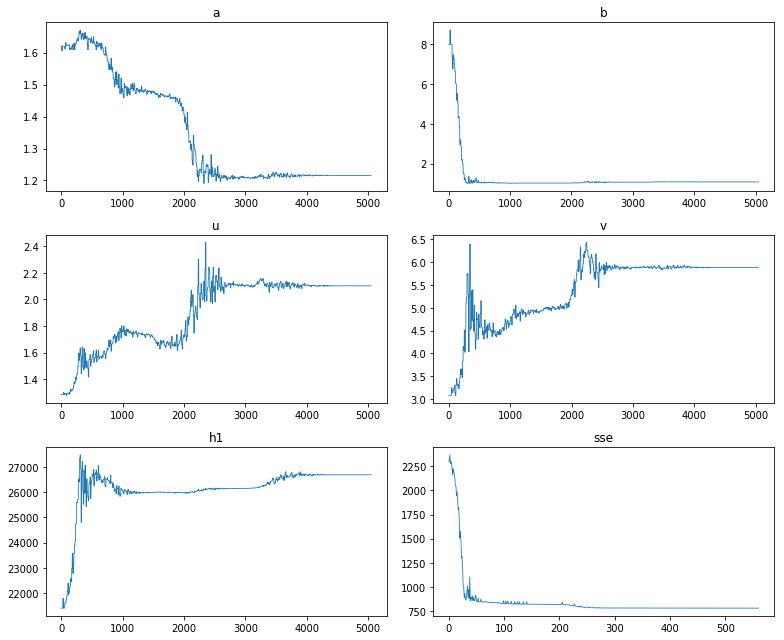

Run 7 Time: 0.89531 minutes

Avg time per run: 1.12145 minutes

Est time remaining: 103.17357 minutes

========Run 8========
{'a': 1.6777108276219423, 'b': 4.568987011391526, 'h1': 20869.867856913217, 'u': 0.688264176127515, 'v': 3.474364268293133}
a* = -1.43615	b* = -2.08705	            h1* = 3.18089	u* = 0.74157	v* = 1.71880
a = 1.23784	b = 1.12405	            h1 = 28779.07829	u = 2.09923	v = 5.57784
Success: True, Optimization terminated successfully.
Iterations: 334
SSE: 749.979565025257


Height  Suspended Mass
0    4430.75    2.005807e+09
1    5776.50    2.348679e+09
2    7122.25    2.567189e+09
3    8468.00    2.727201e+09
4    9813.75    2.851499e+09
5   11159.50    2.950805e+09
6   12505.25    3.030978e+09
7   13851.00    3.095462e+09
8   15196.75    3.146313e+09
9   16542.50    3.184664e+09
10  17888.25    3.210936e+09
11  19234.00    3.224880e+09
12  20579.75    3.225476e+09
13  21925.50    3.210627e+09
14  23271.25    3.176430e+09
15  24617.00    3.115388e+09
16  25962.75    3.011145e+09
17  27308.50    2.815975e+09
18  28654.25    2.100545e+09
19  30000.00    0.000000e+00

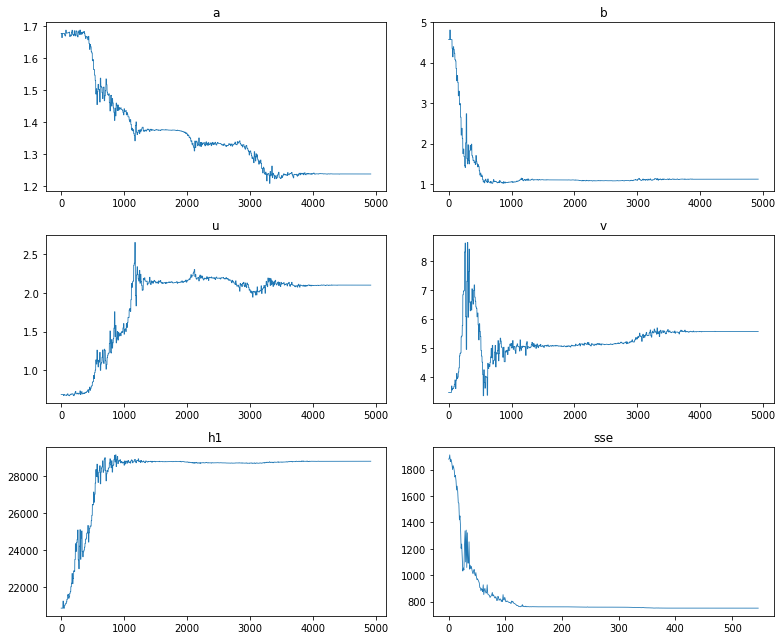

Run 8 Time: 0.87266 minutes

Avg time per run: 1.09381 minutes

Est time remaining: 99.53652 minutes

========Run 9========
{'a': 2.3860335541768163, 'b': 7.032646346065752, 'h1': 24798.689074150672, 'u': 0.991870020738179, 'v': 0.22675138768616093}
a* = -1.43612	b* = -2.08715	            h1* = 3.18090	u* = 0.74162	v* = 1.71877
a = 1.23785	b = 1.12404	            h1 = 28779.08934	u = 2.09933	v = 5.57767
Success: True, Optimization terminated successfully.
Iterations: 504
SSE: 749.9795640601125


Height  Suspended Mass
0    4430.75    2.005750e+09
1    5776.50    2.348625e+09
2    7122.25    2.567139e+09
3    8468.00    2.727157e+09
4    9813.75    2.851459e+09
5   11159.50    2.950770e+09
6   12505.25    3.030949e+09
7   13851.00    3.095438e+09
8   15196.75    3.146295e+09
9   16542.50    3.184653e+09
10  17888.25    3.210931e+09
11  19234.00    3.224882e+09
12  20579.75    3.225486e+09
13  21925.50    3.210646e+09
14  23271.25    3.176458e+09
15  24617.00    3.115428e+09
16  25962.75    3.011200e+09
17  27308.50    2.816051e+09
18  28654.25    2.100684e+09
19  30000.00    0.000000e+00

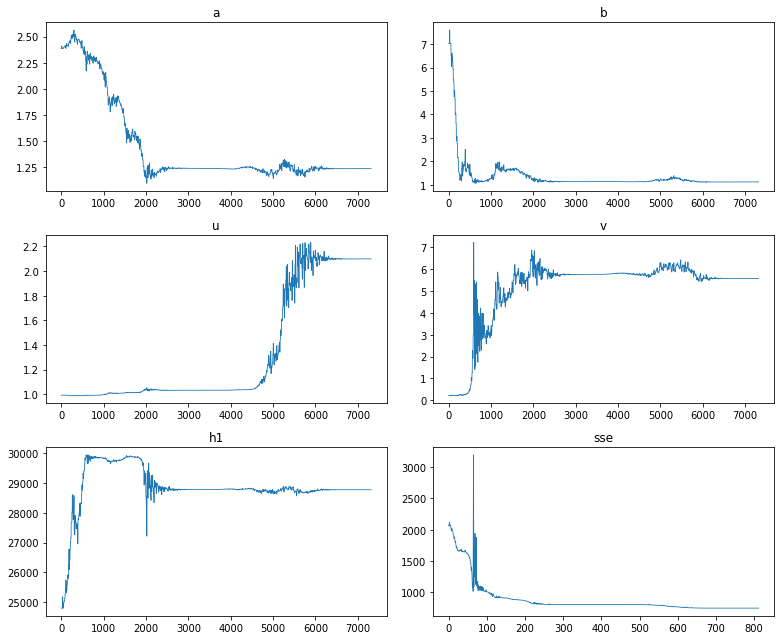

Run 9 Time: 1.23594 minutes

Avg time per run: 1.10802 minutes

Est time remaining: 99.72187 minutes

========Run 10========
{'a': 1.9926612861895578, 'b': 3.9590699884722897, 'h1': 28543.883162384907, 'u': 2.446360595549973, 'v': 0.6306082021888951}
a* = -1.43613	b* = -2.08707	            h1* = 3.18094	u* = 0.74163	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.14531	u = 2.09935	v = 5.57773
Success: True, Optimization terminated successfully.
Iterations: 532
SSE: 749.9795639337513


Height  Suspended Mass
0    4430.75    2.005779e+09
1    5776.50    2.348653e+09
2    7122.25    2.567165e+09
3    8468.00    2.727179e+09
4    9813.75    2.851479e+09
5   11159.50    2.950787e+09
6   12505.25    3.030962e+09
7   13851.00    3.095448e+09
8   15196.75    3.146301e+09
9   16542.50    3.184655e+09
10  17888.25    3.210929e+09
11  19234.00    3.224874e+09
12  20579.75    3.225473e+09
13  21925.50    3.210627e+09
14  23271.25    3.176433e+09
15  24617.00    3.115396e+09
16  25962.75    3.011159e+09
17  27308.50    2.816000e+09
18  28654.25    2.100702e+09
19  30000.00    0.000000e+00

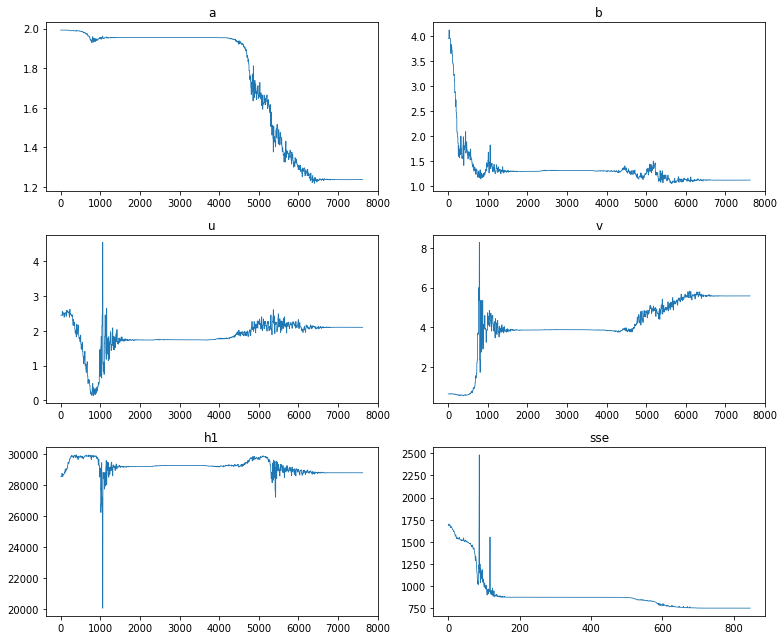

Run 10 Time: 1.28411 minutes

Avg time per run: 1.12403 minutes

Est time remaining: 100.03861 minutes

========Run 11========
{'a': 1.083014131865126, 'b': 1.6134198296689957, 'h1': 25104.71979764827, 'u': 6.787527592056717, 'v': 0.05285898464159097}
a* = -1.51933	b* = -2.36787	            h1* = 2.51712	u* = 0.74493	v* = 1.74485
a = 1.21886	b = 1.09368	            h1 = 27674.33964	u = 2.10629	v = 5.72505
Success: True, Optimization terminated successfully.
Iterations: 440
SSE: 759.3917039473876


Height  Suspended Mass
0    4430.75    2.143162e+09
1    5776.50    2.480339e+09
2    7122.25    2.694446e+09
3    8468.00    2.851399e+09
4    9813.75    2.973802e+09
5   11159.50    3.072234e+09
6   12505.25    3.152448e+09
7   13851.00    3.217809e+09
8   15196.75    3.270305e+09
9   16542.50    3.311002e+09
10  17888.25    3.340231e+09
11  19234.00    3.357592e+09
12  20579.75    3.361780e+09
13  21925.50    3.350085e+09
14  23271.25    3.317135e+09
15  24617.00    3.251302e+09
16  25962.75    3.120451e+09
17  27308.50    2.734478e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

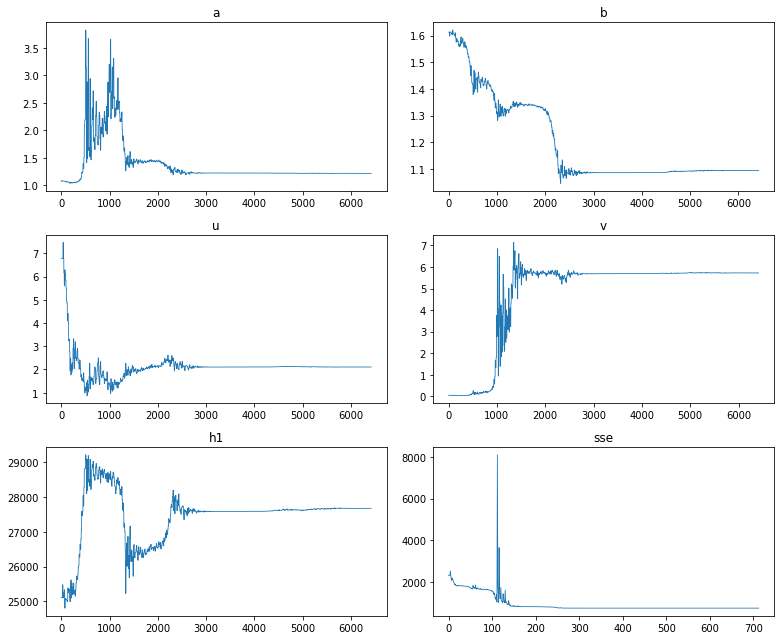

Run 11 Time: 1.07500 minutes

Avg time per run: 1.11994 minutes

Est time remaining: 98.55503 minutes

========Run 12========
{'a': 1.1692546064192886, 'b': 14.138089730656509, 'h1': 12366.257237616102, 'u': 2.4019621639643667, 'v': 1.2203829717772314}
a* = -1.55934	b* = -2.00385	            h1* = 2.53718	u* = -20.39491	v* = 1.78211
a = 1.21027	b = 1.13482	            h1 = 27718.72819	u = 0.00000	v = 5.94236
Success: True, Optimization terminated successfully.
Iterations: 218
SSE: 961.9497707374983


Height  Suspended Mass
0    4430.75    2.271882e+09
1    5776.50    2.607350e+09
2    7122.25    2.815276e+09
3    8468.00    2.963712e+09
4    9813.75    3.075888e+09
5   11159.50    3.162609e+09
6   12505.25    3.229683e+09
7   13851.00    3.280435e+09
8   15196.75    3.316735e+09
9   16542.50    3.339454e+09
10  17888.25    3.348630e+09
11  19234.00    3.343440e+09
12  20579.75    3.321939e+09
13  21925.50    3.280419e+09
14  23271.25    3.211826e+09
15  24617.00    3.101314e+09
16  25962.75    2.909184e+09
17  27308.50    2.420224e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

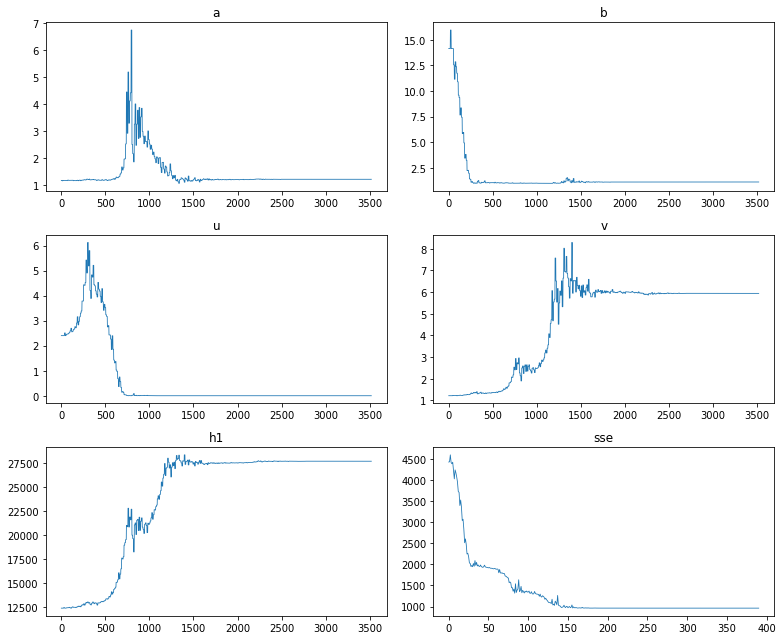

Run 12 Time: 0.59844 minutes

Avg time per run: 1.07983 minutes

Est time remaining: 93.94501 minutes

========Run 13========
{'a': 2.45003425302528, 'b': 2.263269716142543, 'h1': 23807.645791001774, 'u': 2.46111644012259, 'v': 1.7349387762092268}
a* = -1.43607	b* = -2.08711	            h1* = 3.18095	u* = 0.74164	v* = 1.71877
a = 1.23786	b = 1.12405	            h1 = 28779.14868	u = 2.09937	v = 5.57767
Success: True, Optimization terminated successfully.
Iterations: 317
SSE: 749.9795639894419


Height  Suspended Mass
0    4430.75    2.005707e+09
1    5776.50    2.348593e+09
2    7122.25    2.567114e+09
3    8468.00    2.727138e+09
4    9813.75    2.851445e+09
5   11159.50    2.950761e+09
6   12505.25    3.030944e+09
7   13851.00    3.095437e+09
8   15196.75    3.146296e+09
9   16542.50    3.184656e+09
10  17888.25    3.210936e+09
11  19234.00    3.224888e+09
12  20579.75    3.225493e+09
13  21925.50    3.210653e+09
14  23271.25    3.176465e+09
15  24617.00    3.115435e+09
16  25962.75    3.011205e+09
17  27308.50    2.816055e+09
18  28654.25    2.100777e+09
19  30000.00    0.000000e+00

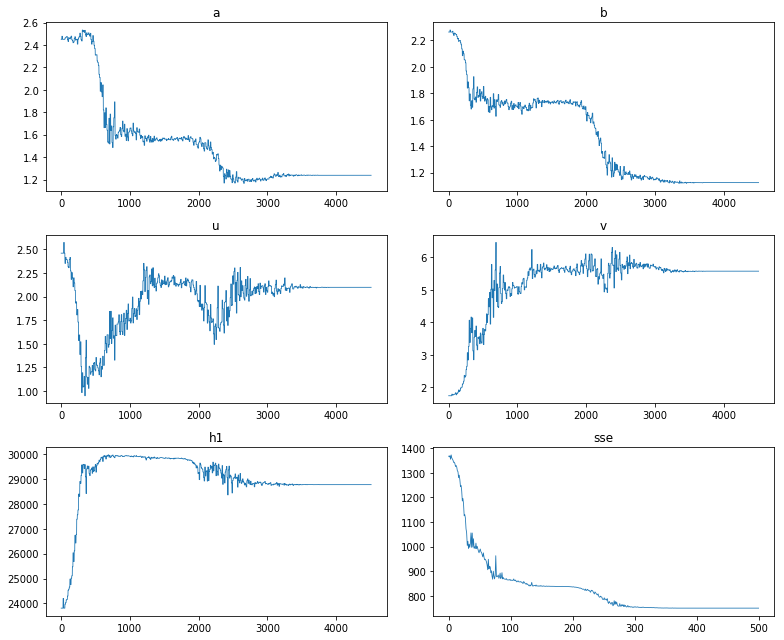

Run 13 Time: 0.76380 minutes

Avg time per run: 1.05725 minutes

Est time remaining: 90.92388 minutes

========Run 14========
{'a': 1.3717490535227197, 'b': 3.73326978299915, 'h1': 23717.100137960115, 'u': 1.8548265814416574, 'v': 0.5560655981692872}
a* = -1.43608	b* = -2.08710	            h1* = 3.18093	u* = 0.74161	v* = 1.71878
a = 1.23786	b = 1.12405	            h1 = 28779.13055	u = 2.09932	v = 5.57772
Success: True, Optimization terminated successfully.
Iterations: 391
SSE: 749.9795639254335


Height  Suspended Mass
0    4430.75    2.005717e+09
1    5776.50    2.348602e+09
2    7122.25    2.567122e+09
3    8468.00    2.727145e+09
4    9813.75    2.851452e+09
5   11159.50    2.950767e+09
6   12505.25    3.030948e+09
7   13851.00    3.095441e+09
8   15196.75    3.146299e+09
9   16542.50    3.184659e+09
10  17888.25    3.210938e+09
11  19234.00    3.224889e+09
12  20579.75    3.225493e+09
13  21925.50    3.210652e+09
14  23271.25    3.176464e+09
15  24617.00    3.115432e+09
16  25962.75    3.011200e+09
17  27308.50    2.816047e+09
18  28654.25    2.100733e+09
19  30000.00    0.000000e+00

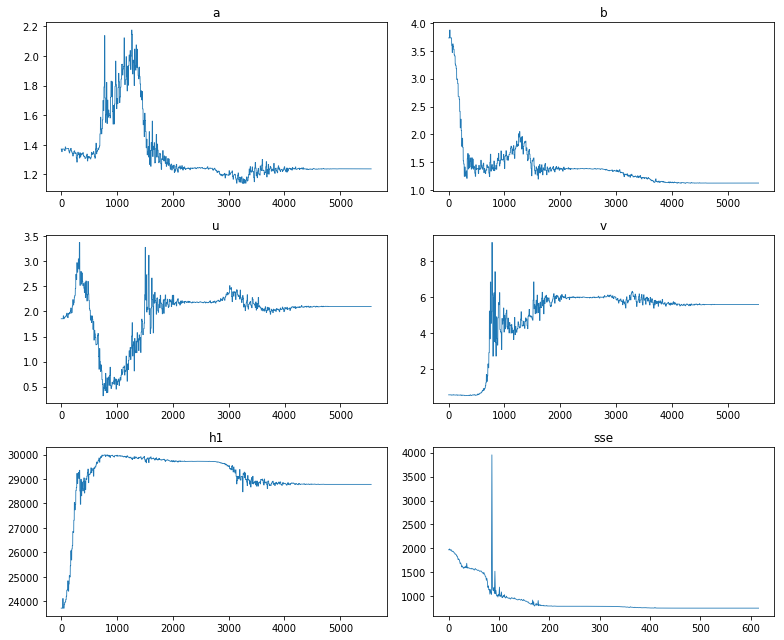

Run 14 Time: 0.93151 minutes

Avg time per run: 1.04887 minutes

Est time remaining: 89.15408 minutes

========Run 15========
{'a': 1.287462407007681, 'b': 7.0479380527025794, 'h1': 18609.016012398995, 'u': 0.28244342795578703, 'v': 7.900958668544198}
a* = -1.51972	b* = -2.59893	            h1* = 1.89685	u* = 0.73677	v* = 1.80019
a = 1.21877	b = 1.07435	            h1 = 25820.17413	u = 2.08917	v = 6.05078
Success: True, Optimization terminated successfully.
Iterations: 320
SSE: 806.1631953254272


Height  Suspended Mass
0    4430.75    2.393490e+09
1    5776.50    2.771983e+09
2    7122.25    3.013493e+09
3    8468.00    3.191475e+09
4    9813.75    3.331087e+09
5   11159.50    3.444077e+09
6   12505.25    3.536795e+09
7   13851.00    3.612903e+09
8   15196.75    3.674477e+09
9   16542.50    3.722479e+09
10  17888.25    3.756880e+09
11  19234.00    3.776511e+09
12  20579.75    3.778461e+09
13  21925.50    3.756404e+09
14  23271.25    3.695200e+09
15  24617.00    3.544286e+09
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

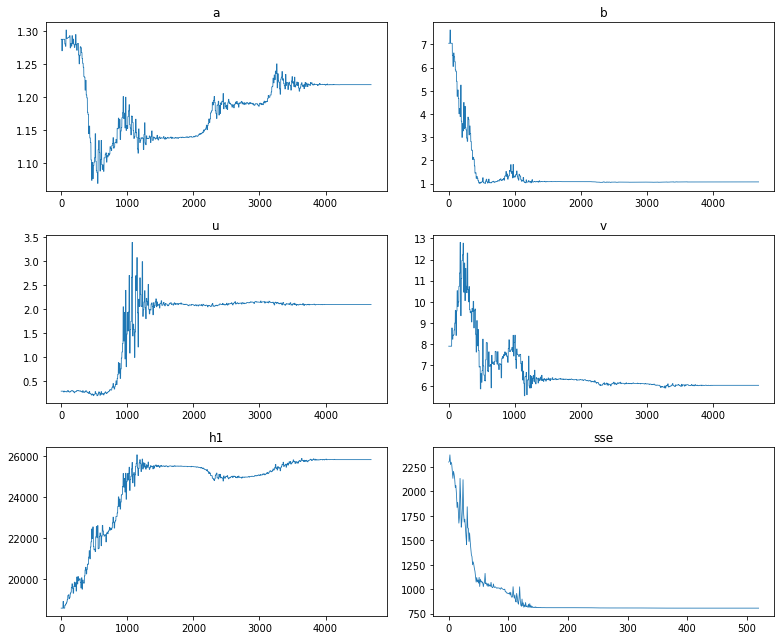

Run 15 Time: 0.78880 minutes

Avg time per run: 1.03262 minutes

Est time remaining: 86.73984 minutes

========Run 16========
{'a': 2.3821402966803045, 'b': 7.464989295384737, 'h1': 21150.6911021696, 'u': 5.026005548793612, 'v': 0.5185579944634001}
a* = -1.43608	b* = -2.08708	            h1* = 3.18087	u* = 0.74163	v* = 1.71877
a = 1.23786	b = 1.12405	            h1 = 28779.05923	u = 2.09935	v = 5.57768
Success: True, Optimization terminated successfully.
Iterations: 341
SSE: 749.9795642530532


Height  Suspended Mass
0    4430.75    2.005731e+09
1    5776.50    2.348617e+09
2    7122.25    2.567139e+09
3    8468.00    2.727162e+09
4    9813.75    2.851468e+09
5   11159.50    2.950783e+09
6   12505.25    3.030964e+09
7   13851.00    3.095456e+09
8   15196.75    3.146314e+09
9   16542.50    3.184672e+09
10  17888.25    3.210950e+09
11  19234.00    3.224900e+09
12  20579.75    3.225502e+09
13  21925.50    3.210659e+09
14  23271.25    3.176467e+09
15  24617.00    3.115431e+09
16  25962.75    3.011193e+09
17  27308.50    2.816027e+09
18  28654.25    2.100567e+09
19  30000.00    0.000000e+00

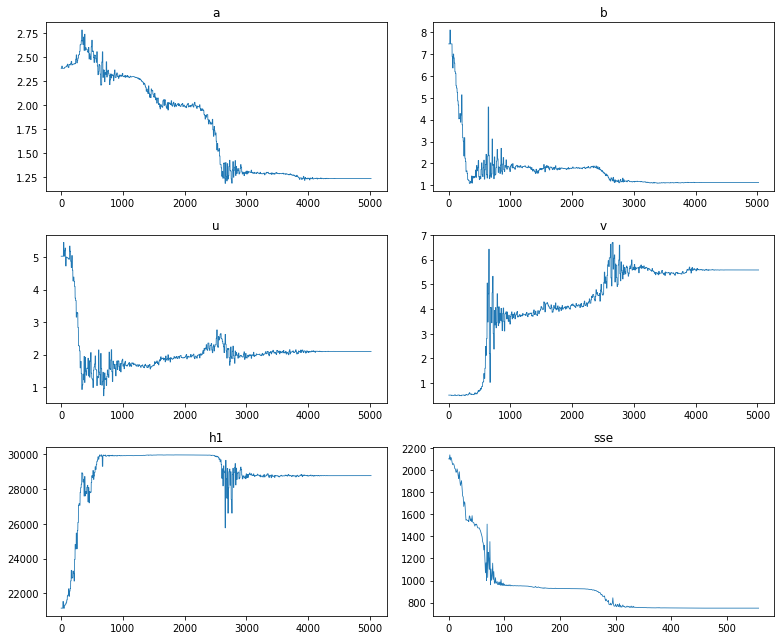

Run 16 Time: 0.85026 minutes

Avg time per run: 1.02189 minutes

Est time remaining: 84.81690 minutes

========Run 17========
{'a': 1.4445782786472647, 'b': 2.782670527517361, 'h1': 24052.21936755404, 'u': 1.0118916464737548, 'v': 2.4018459932333034}
a* = -1.43612	b* = -2.08717	            h1* = 3.18093	u* = 0.74163	v* = 1.71877
a = 1.23785	b = 1.12404	            h1 = 28779.12643	u = 2.09936	v = 5.57765
Success: True, Optimization terminated successfully.
Iterations: 422
SSE: 749.9795641138741


Height  Suspended Mass
0    4430.75    2.005745e+09
1    5776.50    2.348618e+09
2    7122.25    2.567131e+09
3    8468.00    2.727147e+09
4    9813.75    2.851449e+09
5   11159.50    2.950760e+09
6   12505.25    3.030938e+09
7   13851.00    3.095428e+09
8   15196.75    3.146285e+09
9   16542.50    3.184644e+09
10  17888.25    3.210923e+09
11  19234.00    3.224874e+09
12  20579.75    3.225480e+09
13  21925.50    3.210641e+09
14  23271.25    3.176456e+09
15  24617.00    3.115429e+09
16  25962.75    3.011205e+09
17  27308.50    2.816065e+09
18  28654.25    2.100780e+09
19  30000.00    0.000000e+00

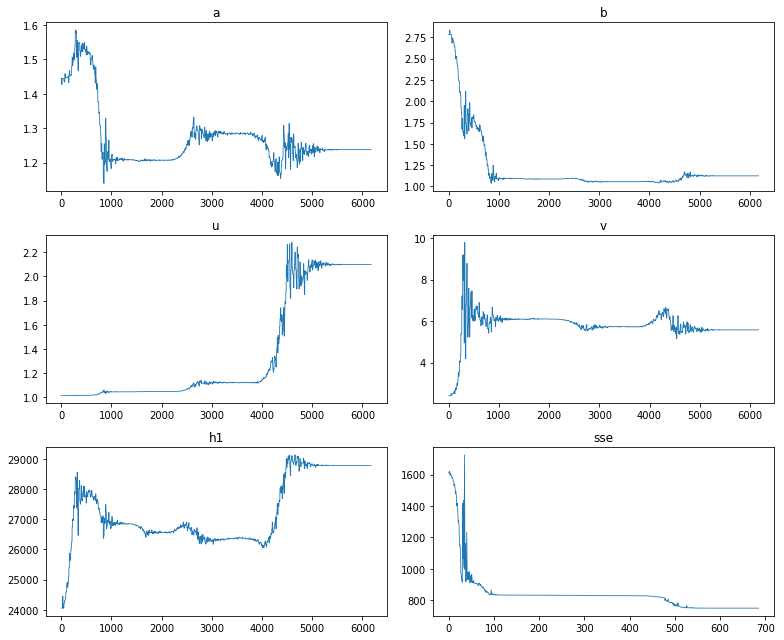

Run 17 Time: 1.03698 minutes

Avg time per run: 1.02273 minutes

Est time remaining: 83.86374 minutes

========Run 18========
{'a': 4.371559388091196, 'b': 7.78461924904215, 'h1': 12405.454840048129, 'u': 7.185185123502116, 'v': 0.6919080768559692}
a* = 15.65688	b* = -18.96704	            h1* = 0.51875	u* = 0.30570	v* = 0.82972
a = 6305175.02689	b = 1.00000	            h1 = 16542.50000	u = 1.35758	v = 2.29269
Success: True, Optimization terminated successfully.
Iterations: 311
SSE: 1399.9316676919657


Height  Suspended Mass
0    4430.75    0.000000e+00
1    5776.50    0.000000e+00
2    7122.25    0.000000e+00
3    8468.00    0.000000e+00
4    9813.75    0.000000e+00
5   11159.50    0.000000e+00
6   12505.25    0.000000e+00
7   13851.00    0.000000e+00
8   15196.75    0.000000e+00
9   16542.50    5.500000e+10
10  17888.25    0.000000e+00
11  19234.00    0.000000e+00
12  20579.75    0.000000e+00
13  21925.50    0.000000e+00
14  23271.25    0.000000e+00
15  24617.00    0.000000e+00
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

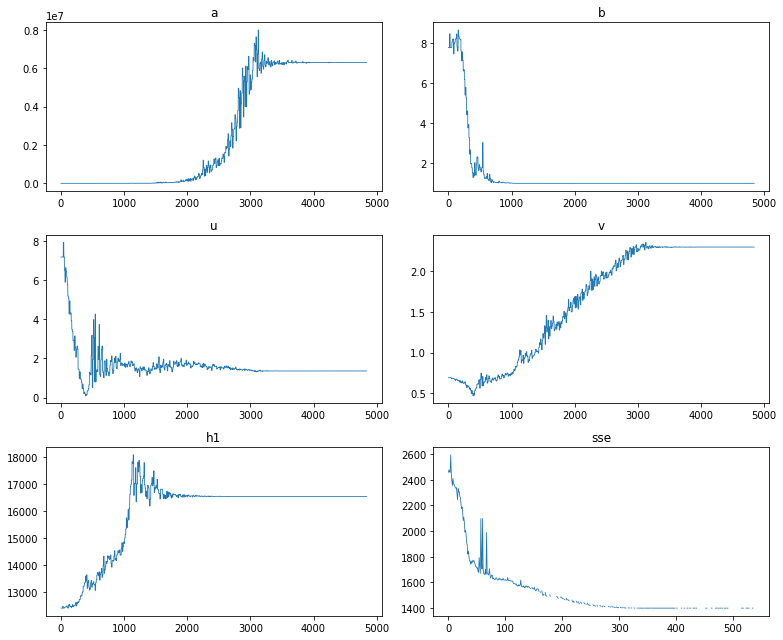

Run 18 Time: 0.81797 minutes

Avg time per run: 1.01195 minutes

Est time remaining: 81.96809 minutes

========Run 19========
{'a': 1.3830988136751894, 'b': 1.5938013198022642, 'h1': 12596.179208458821, 'u': 1.5507019935375812, 'v': 5.4321820689030185}
a* = -1.11534	b* = -3.07778	            h1* = 1.79279	u* = 0.74754	v* = 1.62334
a = 1.32781	b = 1.04606	            h1 = 25398.79750	u = 2.11180	v = 5.07002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 629
SSE: 822.8881474267157


Height  Suspended Mass
0    4430.75    1.871958e+09
1    5776.50    2.342331e+09
2    7122.25    2.666555e+09
3    8468.00    2.919955e+09
4    9813.75    3.129587e+09
5   11159.50    3.308541e+09
6   12505.25    3.464144e+09
7   13851.00    3.600816e+09
8   15196.75    3.721263e+09
9   16542.50    3.827015e+09
10  17888.25    3.918607e+09
11  19234.00    3.995482e+09
12  20579.75    4.055438e+09
13  21925.50    4.092957e+09
14  23271.25    4.093121e+09
15  24617.00    3.992231e+09
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

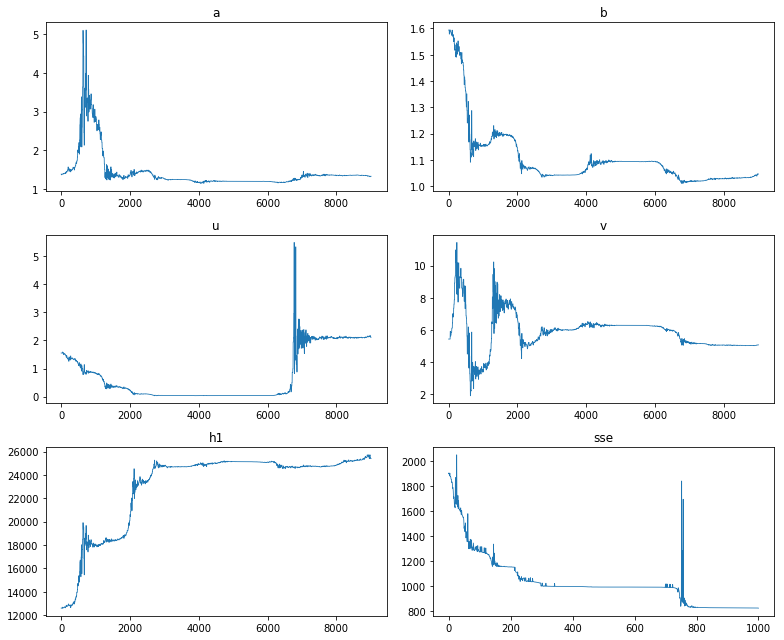

Run 19 Time: 1.51146 minutes

Avg time per run: 1.03693 minutes

Est time remaining: 82.95417 minutes

========Run 20========
{'a': 2.086642262049473, 'b': 7.018916080378479, 'h1': 27544.452659809373, 'u': 2.569137991469737, 'v': 5.198489861884116}
a* = -1.43610	b* = -2.08709	            h1* = 3.18095	u* = 0.74161	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.14691	u = 2.09931	v = 5.57771
Success: True, Optimization terminated successfully.
Iterations: 310
SSE: 749.9795639311674


Height  Suspended Mass
0    4430.75    2.005742e+09
1    5776.50    2.348622e+09
2    7122.25    2.567139e+09
3    8468.00    2.727159e+09
4    9813.75    2.851462e+09
5   11159.50    2.950774e+09
6   12505.25    3.030953e+09
7   13851.00    3.095443e+09
8   15196.75    3.146299e+09
9   16542.50    3.184656e+09
10  17888.25    3.210933e+09
11  19234.00    3.224882e+09
12  20579.75    3.225484e+09
13  21925.50    3.210641e+09
14  23271.25    3.176450e+09
15  24617.00    3.115416e+09
16  25962.75    3.011182e+09
17  27308.50    2.816027e+09
18  28654.25    2.100738e+09
19  30000.00    0.000000e+00

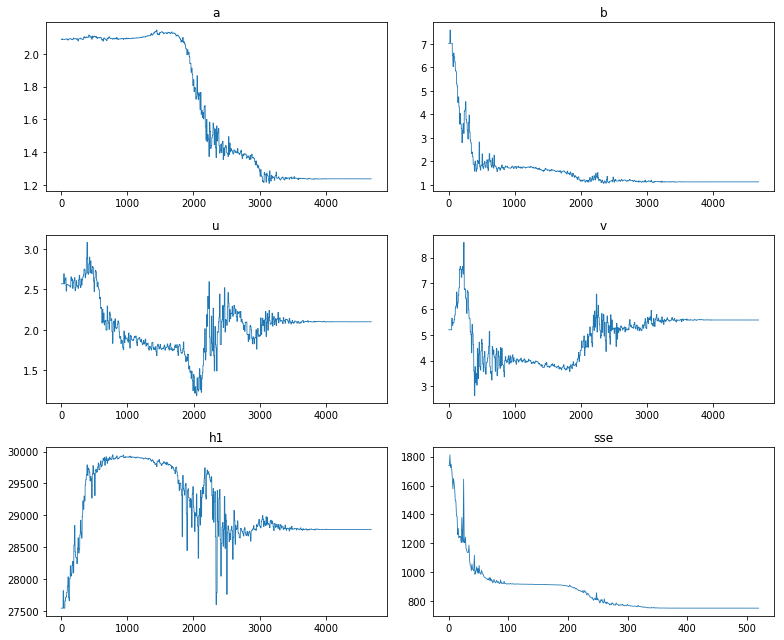

Run 20 Time: 0.79167 minutes

Avg time per run: 1.02525 minutes

Est time remaining: 80.99459 minutes

========Run 21========
{'a': 3.1381295363932438, 'b': 1.5843161245453596, 'h1': 15964.095059779276, 'u': 3.1813581347081756, 'v': 1.6625993345305083}
a* = -1.43609	b* = -2.08707	            h1* = 3.18097	u* = 0.74163	v* = 1.71877
a = 1.23785	b = 1.12405	            h1 = 28779.17429	u = 2.09935	v = 5.57769
Success: True, Optimization terminated successfully.
Iterations: 360
SSE: 749.9795640011714


Height  Suspended Mass
0    4430.75    2.005739e+09
1    5776.50    2.348620e+09
2    7122.25    2.567137e+09
3    8468.00    2.727157e+09
4    9813.75    2.851461e+09
5   11159.50    2.950773e+09
6   12505.25    3.030952e+09
7   13851.00    3.095442e+09
8   15196.75    3.146298e+09
9   16542.50    3.184654e+09
10  17888.25    3.210931e+09
11  19234.00    3.224880e+09
12  20579.75    3.225481e+09
13  21925.50    3.210638e+09
14  23271.25    3.176446e+09
15  24617.00    3.115412e+09
16  25962.75    3.011177e+09
17  27308.50    2.816023e+09
18  28654.25    2.100778e+09
19  30000.00    0.000000e+00

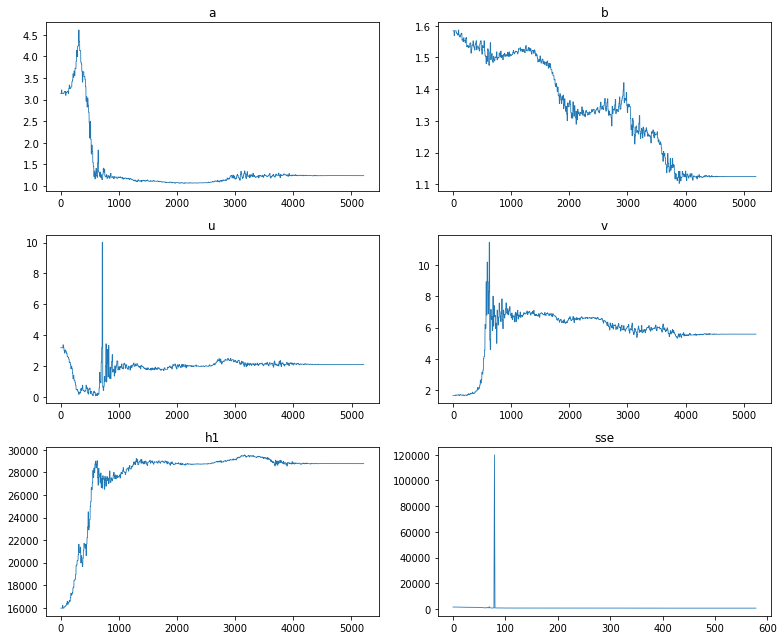

Run 21 Time: 0.88203 minutes

Avg time per run: 1.01874 minutes

Est time remaining: 79.46158 minutes

========Run 22========
{'a': 2.7370075481327176, 'b': 11.284727418253727, 'h1': 16590.36430414129, 'u': 4.203412404076108, 'v': 2.695408919665635}
a* = -1.51930	b* = -2.36793	            h1* = 2.51712	u* = 0.74492	v* = 1.74485
a = 1.21886	b = 1.09367	            h1 = 27674.34760	u = 2.10628	v = 5.72502
Success: True, Optimization terminated successfully.
Iterations: 269
SSE: 759.3917039409907


Height  Suspended Mass
0    4430.75    2.143118e+09
1    5776.50    2.480302e+09
2    7122.25    2.694414e+09
3    8468.00    2.851372e+09
4    9813.75    2.973779e+09
5   11159.50    3.072216e+09
6   12505.25    3.152434e+09
7   13851.00    3.217799e+09
8   15196.75    3.270299e+09
9   16542.50    3.311001e+09
10  17888.25    3.340234e+09
11  19234.00    3.357600e+09
12  20579.75    3.361794e+09
13  21925.50    3.350104e+09
14  23271.25    3.317161e+09
15  24617.00    3.251335e+09
16  25962.75    3.120495e+09
17  27308.50    2.734545e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

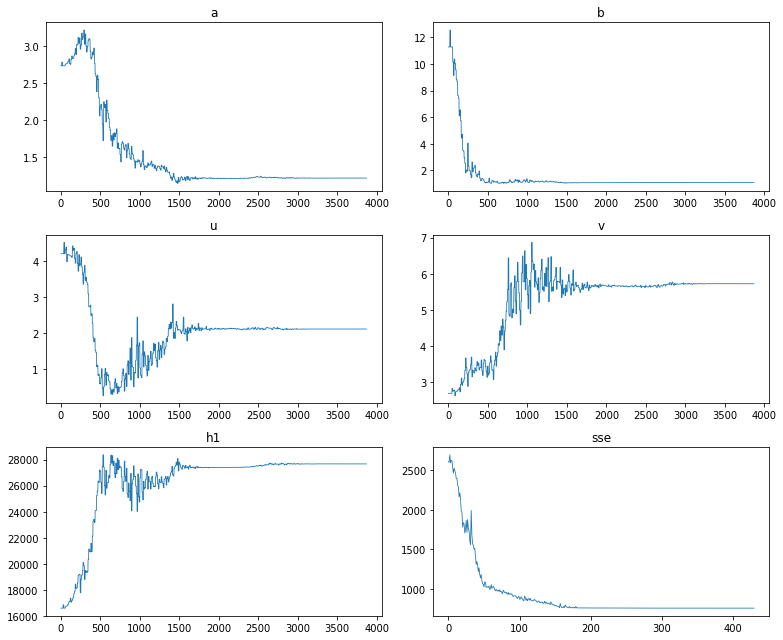

Run 22 Time: 0.65260 minutes

Avg time per run: 1.00282 minutes

Est time remaining: 77.21709 minutes

========Run 23========
{'a': 2.03610386493611, 'b': 1.900227604171903, 'h1': 26168.552817962016, 'u': 1.418146408075048, 'v': 1.9832880920855458}
a* = -1.43606	b* = -2.08711	            h1* = 3.18093	u* = 0.74161	v* = 1.71877
a = 1.23786	b = 1.12404	            h1 = 28779.13322	u = 2.09932	v = 5.57769
Success: True, Optimization terminated successfully.
Iterations: 461
SSE: 749.9795639310662


Height  Suspended Mass
0    4430.75    2.005702e+09
1    5776.50    2.348589e+09
2    7122.25    2.567112e+09
3    8468.00    2.727136e+09
4    9813.75    2.851445e+09
5   11159.50    2.950762e+09
6   12505.25    3.030944e+09
7   13851.00    3.095438e+09
8   15196.75    3.146298e+09
9   16542.50    3.184659e+09
10  17888.25    3.210939e+09
11  19234.00    3.224892e+09
12  20579.75    3.225497e+09
13  21925.50    3.210658e+09
14  23271.25    3.176470e+09
15  24617.00    3.115440e+09
16  25962.75    3.011210e+09
17  27308.50    2.816058e+09
18  28654.25    2.100752e+09
19  30000.00    0.000000e+00

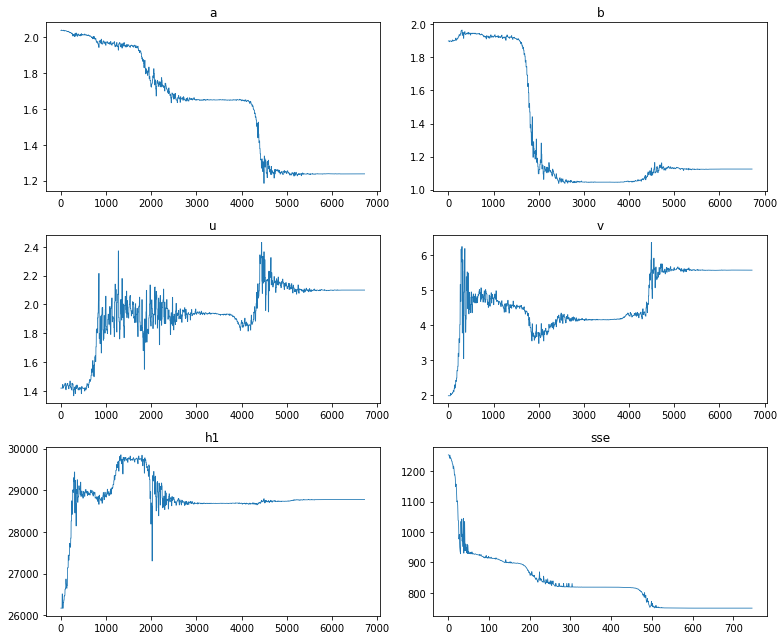

Run 23 Time: 1.12630 minutes

Avg time per run: 1.00796 minutes

Est time remaining: 76.60530 minutes

========Run 24========
{'a': 1.140372521897457, 'b': 1.9226616035028152, 'h1': 29730.649539384343, 'u': 2.9840441272434286, 'v': 3.655402753686956}
a* = -1.43612	b* = -2.08710	            h1* = 3.18094	u* = 0.74162	v* = 1.71877
a = 1.23785	b = 1.12405	            h1 = 28779.14191	u = 2.09933	v = 5.57767
Success: True, Optimization terminated successfully.
Iterations: 338
SSE: 749.9795639748597


Height  Suspended Mass
0    4430.75    2.005755e+09
1    5776.50    2.348631e+09
2    7122.25    2.567145e+09
3    8468.00    2.727162e+09
4    9813.75    2.851464e+09
5   11159.50    2.950774e+09
6   12505.25    3.030952e+09
7   13851.00    3.095441e+09
8   15196.75    3.146296e+09
9   16542.50    3.184652e+09
10  17888.25    3.210929e+09
11  19234.00    3.224877e+09
12  20579.75    3.225479e+09
13  21925.50    3.210636e+09
14  23271.25    3.176446e+09
15  24617.00    3.115413e+09
16  25962.75    3.011180e+09
17  27308.50    2.816029e+09
18  28654.25    2.100740e+09
19  30000.00    0.000000e+00

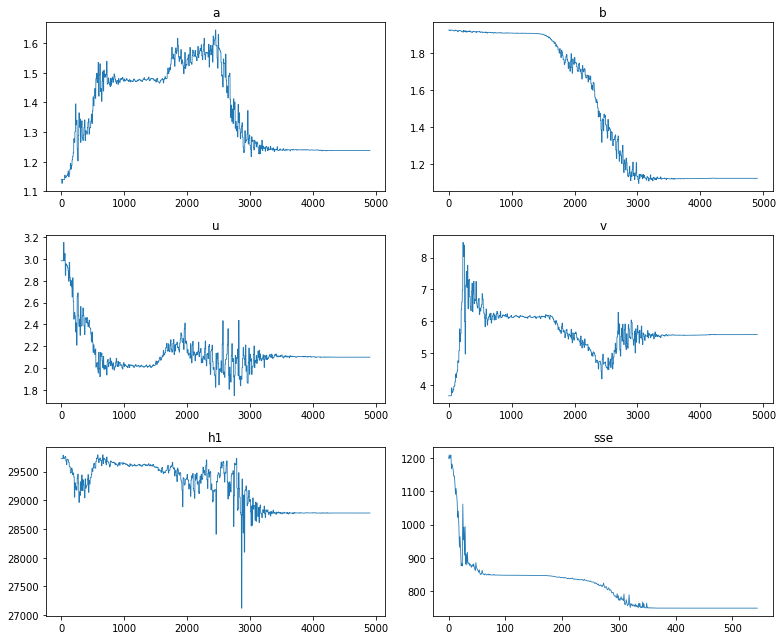

Run 24 Time: 0.82917 minutes

Avg time per run: 1.00081 minutes

Est time remaining: 75.06094 minutes

========Run 25========
{'a': 2.828232192894709, 'b': 1.48164329820429, 'h1': 25995.996046845765, 'u': 0.6394274037408026, 'v': 0.7082215390142198}
a* = -1.43611	b* = -2.08711	            h1* = 3.18094	u* = 0.74163	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.14242	u = 2.09936	v = 5.57772
Success: True, Optimization terminated successfully.
Iterations: 396
SSE: 749.9795639319933


Height  Suspended Mass
0    4430.75    2.005750e+09
1    5776.50    2.348627e+09
2    7122.25    2.567142e+09
3    8468.00    2.727160e+09
4    9813.75    2.851462e+09
5   11159.50    2.950773e+09
6   12505.25    3.030951e+09
7   13851.00    3.095440e+09
8   15196.75    3.146296e+09
9   16542.50    3.184652e+09
10  17888.25    3.210929e+09
11  19234.00    3.224878e+09
12  20579.75    3.225480e+09
13  21925.50    3.210638e+09
14  23271.25    3.176448e+09
15  24617.00    3.115415e+09
16  25962.75    3.011183e+09
17  27308.50    2.816032e+09
18  28654.25    2.100744e+09
19  30000.00    0.000000e+00

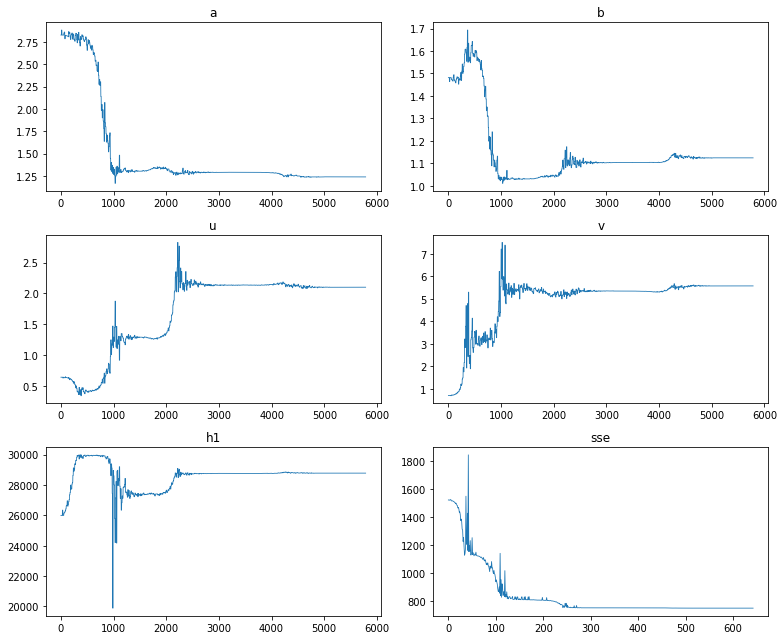

Run 25 Time: 0.97057 minutes

Avg time per run: 0.99965 minutes

Est time remaining: 73.97406 minutes

========Run 26========
{'a': 1.9351818575514783, 'b': 4.290811685829816, 'h1': 13127.193729329889, 'u': 4.007265413837892, 'v': 0.7486589075598827}
a* = -0.42717	b* = -3.05032	            h1* = 2.37938	u* = 0.62161	v* = 1.48731
a = 1.65235	b = 1.04734	            h1 = 27346.51342	u = 1.86192	v = 4.42516
Success: True, Optimization terminated successfully.
Iterations: 410
SSE: 824.2937941678424


Height  Suspended Mass
0    4430.75    7.890704e+08
1    5776.50    1.236658e+09
2    7122.25    1.606197e+09
3    8468.00    1.931467e+09
4    9813.75    2.226314e+09
5   11159.50    2.498035e+09
6   12505.25    2.750976e+09
7   13851.00    2.987884e+09
8   15196.75    3.210505e+09
9   16542.50    3.419871e+09
10  17888.25    3.616406e+09
11  19234.00    3.799907e+09
12  20579.75    3.969362e+09
13  21925.50    4.122468e+09
14  23271.25    4.254386e+09
15  24617.00    4.353920e+09
16  25962.75    4.386203e+09
17  27308.50    3.840371e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

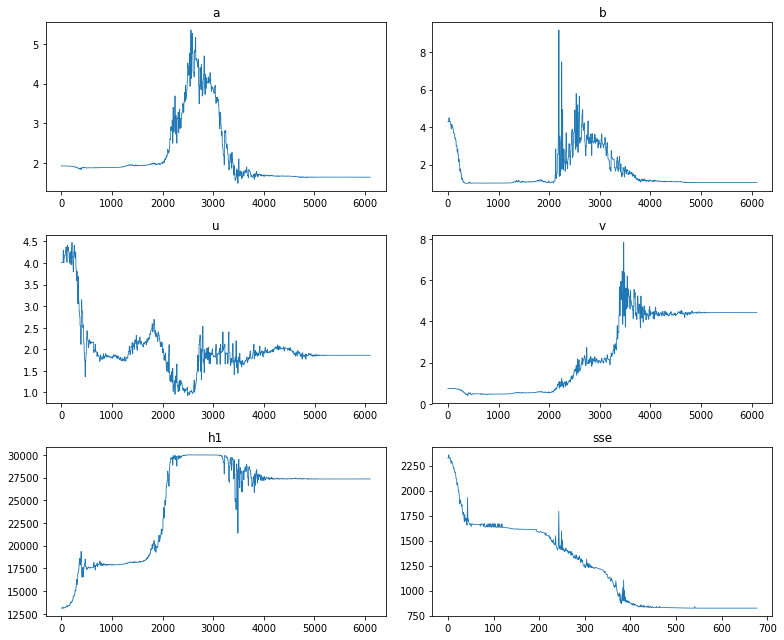

Run 26 Time: 1.02526 minutes

Avg time per run: 1.00061 minutes

Est time remaining: 73.04436 minutes

========Run 27========
{'a': 2.5582100383602278, 'b': 2.341154807318443, 'h1': 18314.352184770694, 'u': 0.07875932141402216, 'v': 8.025549254334038}
a* = -1.43612	b* = -2.08704	            h1* = 3.18087	u* = 0.74162	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.06098	u = 2.09934	v = 5.57770
Success: True, Optimization terminated successfully.
Iterations: 310
SSE: 749.9795644110377


Height  Suspended Mass
0    4430.75    2.005787e+09
1    5776.50    2.348665e+09
2    7122.25    2.567179e+09
3    8468.00    2.727195e+09
4    9813.75    2.851495e+09
5   11159.50    2.950804e+09
6   12505.25    3.030979e+09
7   13851.00    3.095466e+09
8   15196.75    3.146318e+09
9   16542.50    3.184671e+09
10  17888.25    3.210944e+09
11  19234.00    3.224889e+09
12  20579.75    3.225486e+09
13  21925.50    3.210637e+09
14  23271.25    3.176440e+09
15  24617.00    3.115398e+09
16  25962.75    3.011154e+09
17  27308.50    2.815980e+09
18  28654.25    2.100510e+09
19  30000.00    0.000000e+00

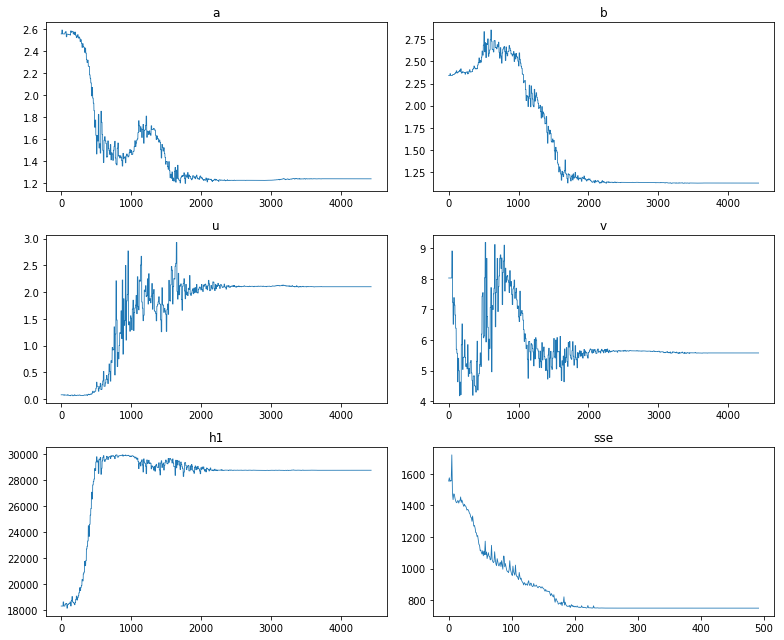

Run 27 Time: 0.75026 minutes

Avg time per run: 0.99167 minutes

Est time remaining: 71.40000 minutes

========Run 28========
{'a': 1.322048717727899, 'b': 1.8380798553345277, 'h1': 12244.345581435662, 'u': 10.798387883700773, 'v': 4.741072785793748}


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:675: RuntimeWarning: divide by zero encountered in double_scalars
  wind_speed = u/np.sin(wind_angle)
C:\Users\nmostert\Documents\repos\inversion_project\utils.py:680: RuntimeWarning: invalid value encountered in double_scalars
  v_wind_adj = np.sin(wind_angle)*windspeed_adj


a* = -1.36820	b* = -1.90266	            h1* = 2.77202	u* = -33.76911	v* = 1.74035
a = 1.25456	b = 1.14917	            h1 = 28181.38936	u = 0.00000	v = 5.69933
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 629
SSE: 947.2058592356727


Height  Suspended Mass
0    4430.75    2.079600e+09
1    5776.50    2.459419e+09
2    7122.25    2.701756e+09
3    8468.00    2.878545e+09
4    9813.75    3.014825e+09
5   11159.50    3.122407e+09
6   12505.25    3.207718e+09
7   13851.00    3.274492e+09
8   15196.75    3.324887e+09
9   16542.50    3.359981e+09
10  17888.25    3.379976e+09
11  19234.00    3.384200e+09
12  20579.75    3.370898e+09
13  21925.50    3.336692e+09
14  23271.25    3.275304e+09
15  24617.00    3.174211e+09
16  25962.75    3.003476e+09
17  27308.50    2.651614e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

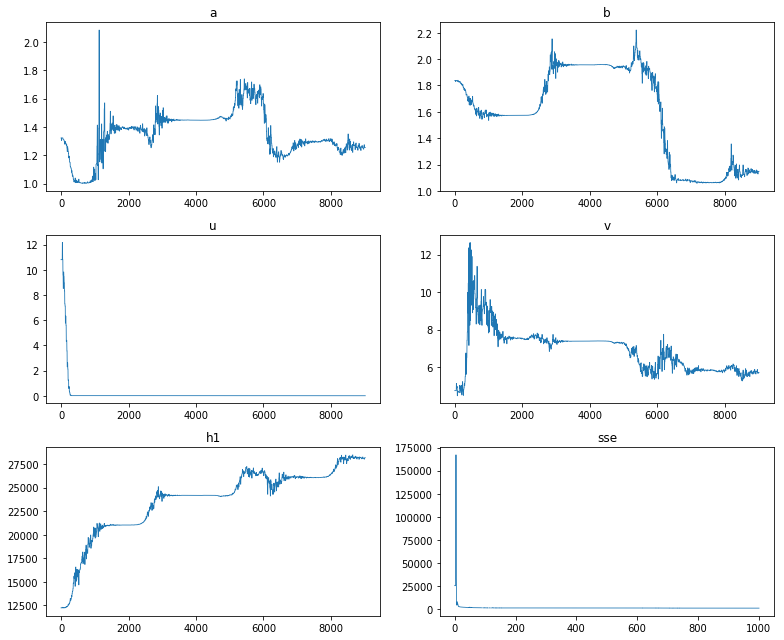

Run 28 Time: 1.50755 minutes

Avg time per run: 1.00946 minutes

Est time remaining: 71.67136 minutes

========Run 29========
{'a': 1.010201012852265, 'b': 9.835171829207077, 'h1': 25330.56183840926, 'u': 4.087625900502134, 'v': 1.3614809722635324}
a* = -1.51934	b* = -2.36784	            h1* = 2.51713	u* = 0.74492	v* = 1.74486
a = 1.21886	b = 1.09368	            h1 = 27674.36424	u = 2.10628	v = 5.72510
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 619
SSE: 759.3917038960021


Height  Suspended Mass
0    4430.75    2.143169e+09
1    5776.50    2.480347e+09
2    7122.25    2.694453e+09
3    8468.00    2.851406e+09
4    9813.75    2.973808e+09
5   11159.50    3.072239e+09
6   12505.25    3.152452e+09
7   13851.00    3.217812e+09
8   15196.75    3.270307e+09
9   16542.50    3.311003e+09
10  17888.25    3.340230e+09
11  19234.00    3.357590e+09
12  20579.75    3.361777e+09
13  21925.50    3.350079e+09
14  23271.25    3.317128e+09
15  24617.00    3.251292e+09
16  25962.75    3.120439e+09
17  27308.50    2.734469e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

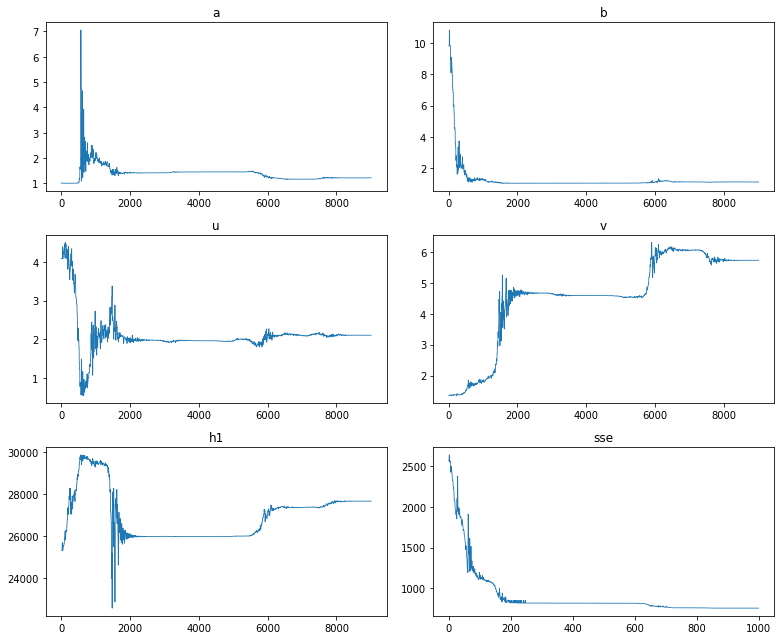

Run 29 Time: 1.52083 minutes

Avg time per run: 1.02650 minutes

Est time remaining: 71.85512 minutes

========Run 30========
{'a': 1.4018494597522329, 'b': 2.3967421300600353, 'h1': 26556.741442458107, 'u': 2.4585149259849386, 'v': 5.781591337256484}
a* = -1.43612	b* = -2.08718	            h1* = 3.18091	u* = 0.74162	v* = 1.71878
a = 1.23785	b = 1.12404	            h1 = 28779.10197	u = 2.09933	v = 5.57770
Success: True, Optimization terminated successfully.
Iterations: 273
SSE: 749.9795640493664


Height  Suspended Mass
0    4430.75    2.005745e+09
1    5776.50    2.348619e+09
2    7122.25    2.567131e+09
3    8468.00    2.727148e+09
4    9813.75    2.851450e+09
5   11159.50    2.950761e+09
6   12505.25    3.030940e+09
7   13851.00    3.095430e+09
8   15196.75    3.146287e+09
9   16542.50    3.184646e+09
10  17888.25    3.210925e+09
11  19234.00    3.224877e+09
12  20579.75    3.225483e+09
13  21925.50    3.210645e+09
14  23271.25    3.176460e+09
15  24617.00    3.115433e+09
16  25962.75    3.011209e+09
17  27308.50    2.816068e+09
18  28654.25    2.100741e+09
19  30000.00    0.000000e+00

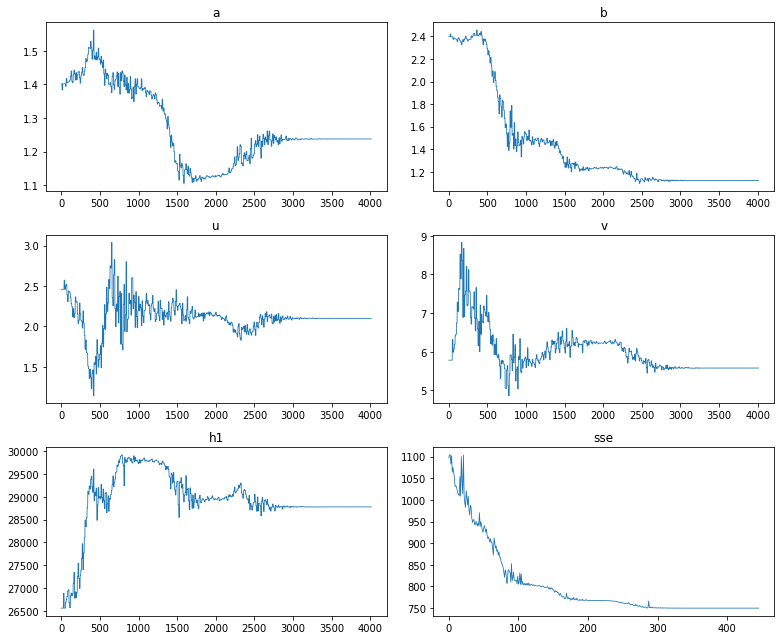

Run 30 Time: 0.67604 minutes

Avg time per run: 1.01520 minutes

Est time remaining: 70.04856 minutes

========Run 31========
{'a': 1.4558002050600973, 'b': 18.700620763076355, 'h1': 25522.73775857156, 'u': 6.887296919527799, 'v': 2.265652775405643}
a* = -1.43614	b* = -2.08711	            h1* = 3.18091	u* = 0.74162	v* = 1.71878
a = 1.23784	b = 1.12404	            h1 = 28779.10604	u = 2.09934	v = 5.57770
Success: True, Optimization terminated successfully.
Iterations: 204
SSE: 749.9795640325628


Height  Suspended Mass
0    4430.75    2.005784e+09
1    5776.50    2.348655e+09
2    7122.25    2.567164e+09
3    8468.00    2.727177e+09
4    9813.75    2.851476e+09
5   11159.50    2.950783e+09
6   12505.25    3.030958e+09
7   13851.00    3.095445e+09
8   15196.75    3.146298e+09
9   16542.50    3.184652e+09
10  17888.25    3.210927e+09
11  19234.00    3.224874e+09
12  20579.75    3.225474e+09
13  21925.50    3.210631e+09
14  23271.25    3.176439e+09
15  24617.00    3.115405e+09
16  25962.75    3.011172e+09
17  27308.50    2.816018e+09
18  28654.25    2.100669e+09
19  30000.00    0.000000e+00

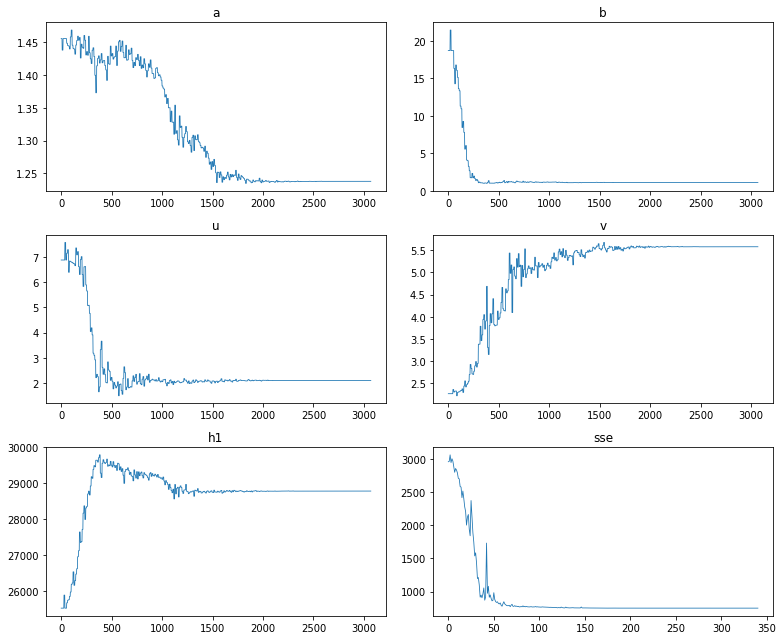

Run 31 Time: 0.52240 minutes

Avg time per run: 0.99980 minutes

Est time remaining: 67.98617 minutes

========Run 32========
{'a': 1.5615559564782204, 'b': 10.740204250302986, 'h1': 27042.27317708064, 'u': 1.1330808147405478, 'v': 3.926708812630559}
a* = -1.43616	b* = -2.08707	            h1* = 3.18095	u* = 0.74161	v* = 1.71878
a = 1.23784	b = 1.12405	            h1 = 28779.15268	u = 2.09932	v = 5.57774
Success: True, Optimization terminated successfully.
Iterations: 436
SSE: 749.9795641332959


Height  Suspended Mass
0    4430.75    2.005809e+09
1    5776.50    2.348677e+09
2    7122.25    2.567183e+09
3    8468.00    2.727193e+09
4    9813.75    2.851488e+09
5   11159.50    2.950793e+09
6   12505.25    3.030965e+09
7   13851.00    3.095448e+09
8   15196.75    3.146299e+09
9   16542.50    3.184650e+09
10  17888.25    3.210921e+09
11  19234.00    3.224865e+09
12  20579.75    3.225462e+09
13  21925.50    3.210615e+09
14  23271.25    3.176419e+09
15  24617.00    3.115381e+09
16  25962.75    3.011143e+09
17  27308.50    2.815985e+09
18  28654.25    2.100704e+09
19  30000.00    0.000000e+00

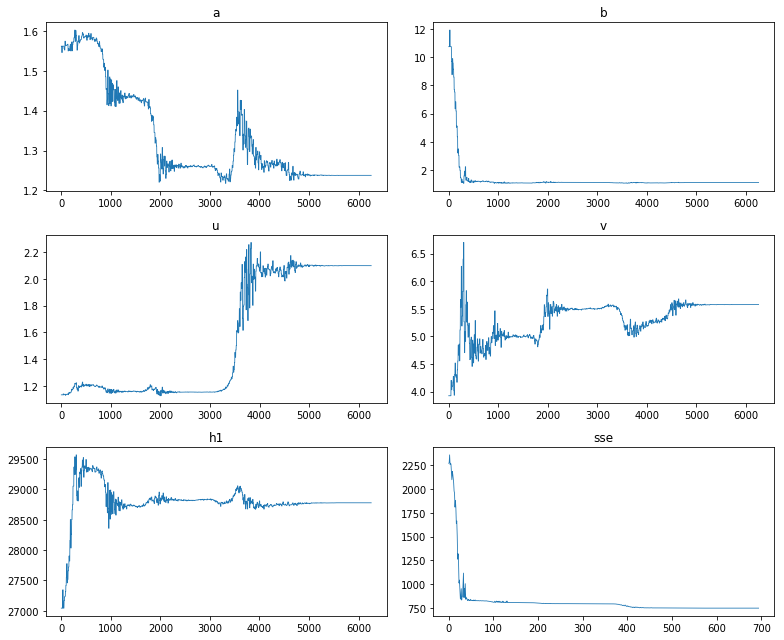

Run 32 Time: 1.04974 minutes

Avg time per run: 1.00131 minutes

Est time remaining: 67.08777 minutes

========Run 33========
{'a': 2.6602485208265487, 'b': 8.455092063281569, 'h1': 20933.28962827143, 'u': 1.5233567291701082, 'v': 1.4594370871128115}
a* = -1.43605	b* = -2.08709	            h1* = 3.18094	u* = 0.74162	v* = 1.71877
a = 1.23786	b = 1.12405	            h1 = 28779.13753	u = 2.09934	v = 5.57766
Success: True, Optimization terminated successfully.
Iterations: 350
SSE: 749.9795639309502


Height  Suspended Mass
0    4430.75    2.005697e+09
1    5776.50    2.348587e+09
2    7122.25    2.567111e+09
3    8468.00    2.727137e+09
4    9813.75    2.851446e+09
5   11159.50    2.950764e+09
6   12505.25    3.030947e+09
7   13851.00    3.095442e+09
8   15196.75    3.146302e+09
9   16542.50    3.184662e+09
10  17888.25    3.210943e+09
11  19234.00    3.224895e+09
12  20579.75    3.225500e+09
13  21925.50    3.210659e+09
14  23271.25    3.176471e+09
15  24617.00    3.115439e+09
16  25962.75    3.011206e+09
17  27308.50    2.816052e+09
18  28654.25    2.100743e+09
19  30000.00    0.000000e+00

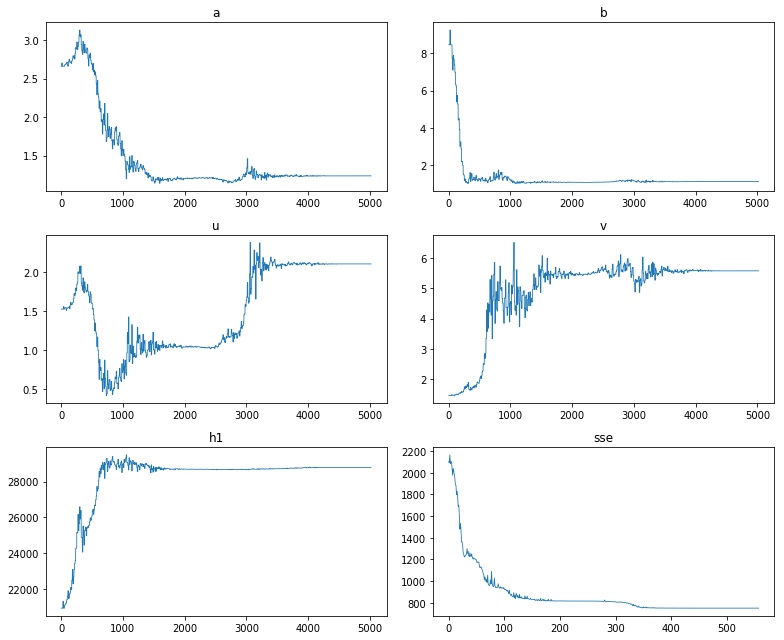

Run 33 Time: 0.83880 minutes

Avg time per run: 0.99653 minutes

Est time remaining: 65.77100 minutes

========Run 34========
{'a': 1.092735897615493, 'b': 7.149670602596677, 'h1': 24257.49611290083, 'u': 2.6398811149884436, 'v': 0.18127451140816833}
a* = -1.43615	b* = -2.08715	            h1* = 3.18097	u* = 0.74163	v* = 1.71878
a = 1.23784	b = 1.12404	            h1 = 28779.17372	u = 2.09936	v = 5.57771
Success: True, Optimization terminated successfully.
Iterations: 342
SSE: 749.9795643128172


Height  Suspended Mass
0    4430.75    2.005771e+09
1    5776.50    2.348639e+09
2    7122.25    2.567147e+09
3    8468.00    2.727160e+09
4    9813.75    2.851457e+09
5   11159.50    2.950765e+09
6   12505.25    3.030940e+09
7   13851.00    3.095428e+09
8   15196.75    3.146282e+09
9   16542.50    3.184637e+09
10  17888.25    3.210914e+09
11  19234.00    3.224863e+09
12  20579.75    3.225465e+09
13  21925.50    3.210624e+09
14  23271.25    3.176437e+09
15  24617.00    3.115408e+09
16  25962.75    3.011182e+09
17  27308.50    2.816043e+09
18  28654.25    2.100839e+09
19  30000.00    0.000000e+00

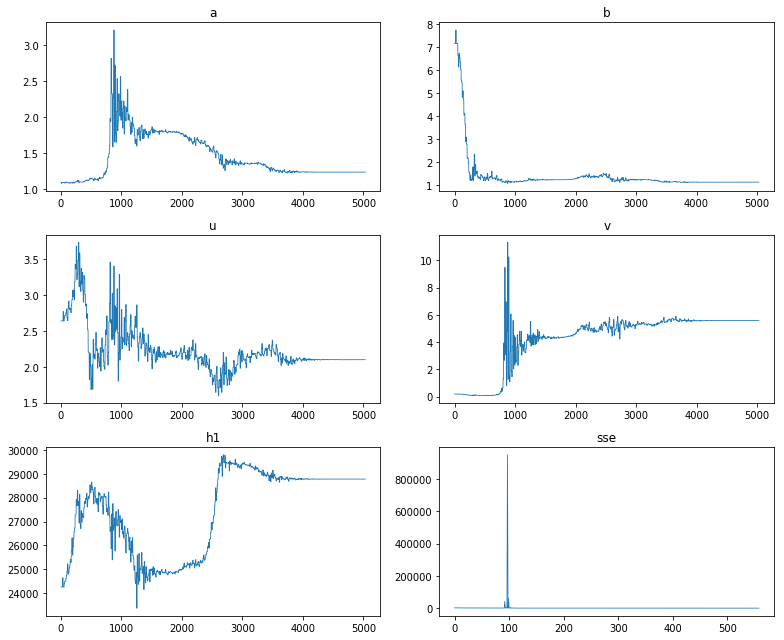

Run 34 Time: 0.84349 minutes

Avg time per run: 0.99216 minutes

Est time remaining: 64.49025 minutes

========Run 35========
{'a': 3.677533733594241, 'b': 2.7488852672261324, 'h1': 20044.063847454046, 'u': 1.348230346199283, 'v': 4.126724438536745}
a* = -1.43612	b* = -2.08707	            h1* = 3.18093	u* = 0.74163	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.12992	u = 2.09936	v = 5.57773
Success: True, Optimization terminated successfully.
Iterations: 242
SSE: 749.9795639079915


Height  Suspended Mass
0    4430.75    2.005765e+09
1    5776.50    2.348642e+09
2    7122.25    2.567156e+09
3    8468.00    2.727173e+09
4    9813.75    2.851475e+09
5   11159.50    2.950785e+09
6   12505.25    3.030961e+09
7   13851.00    3.095449e+09
8   15196.75    3.146304e+09
9   16542.50    3.184658e+09
10  17888.25    3.210933e+09
11  19234.00    3.224880e+09
12  20579.75    3.225480e+09
13  21925.50    3.210635e+09
14  23271.25    3.176441e+09
15  24617.00    3.115405e+09
16  25962.75    3.011168e+09
17  27308.50    2.816008e+09
18  28654.25    2.100681e+09
19  30000.00    0.000000e+00

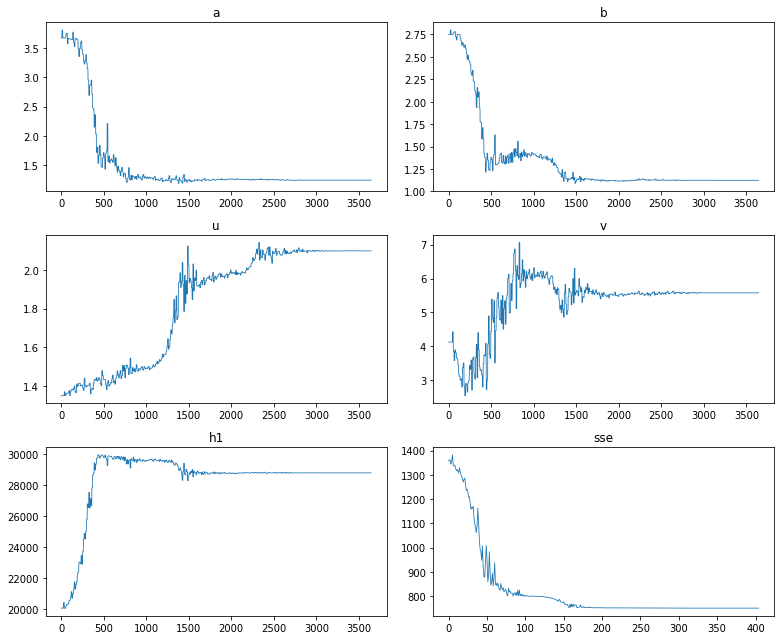

Run 35 Time: 0.61693 minutes

Avg time per run: 0.98173 minutes

Est time remaining: 62.83102 minutes

========Run 36========
{'a': 1.0851559891852214, 'b': 2.973220460072889, 'h1': 12736.995070756919, 'u': 3.652113095677727, 'v': 7.363260105139046}
a* = -1.51898	b* = -2.36814	            h1* = 2.51725	u* = 0.74492	v* = 1.74484
a = 1.21894	b = 1.09365	            h1 = 27674.62425	u = 2.10628	v = 5.72496
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 637
SSE: 759.3917107623324


Height  Suspended Mass
0    4430.75    2.142741e+09
1    5776.50    2.479991e+09
2    7122.25    2.694158e+09
3    8468.00    2.851164e+09
4    9813.75    2.973614e+09
5   11159.50    3.072091e+09
6   12505.25    3.152346e+09
7   13851.00    3.217747e+09
8   15196.75    3.270281e+09
9   16542.50    3.311016e+09
10  17888.25    3.340281e+09
11  19234.00    3.357680e+09
12  20579.75    3.361906e+09
13  21925.50    3.350250e+09
14  23271.25    3.317345e+09
15  24617.00    3.251562e+09
16  25962.75    3.120783e+09
17  27308.50    2.735045e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

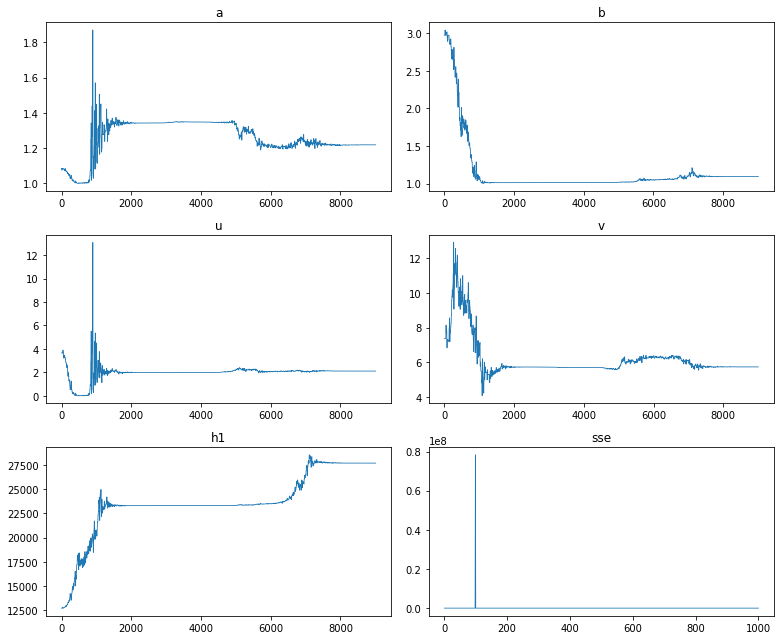

Run 36 Time: 1.50182 minutes

Avg time per run: 0.99579 minutes

Est time remaining: 62.73484 minutes

========Run 37========
{'a': 1.2665284242908246, 'b': 3.673538405808912, 'h1': 15153.741234590852, 'u': 2.58586091529512, 'v': 6.184255730037853}
a* = -1.51976	b* = -2.59895	            h1* = 1.89679	u* = 0.73674	v* = 1.80021
a = 1.21877	b = 1.07435	            h1 = 25819.97078	u = 2.08911	v = 6.05090
Success: True, Optimization terminated successfully.
Iterations: 307
SSE: 806.1631954286189


Height  Suspended Mass
0    4430.75    2.393529e+09
1    5776.50    2.772012e+09
2    7122.25    3.013516e+09
3    8468.00    3.191492e+09
4    9813.75    3.331099e+09
5   11159.50    3.444085e+09
6   12505.25    3.536799e+09
7   13851.00    3.612903e+09
8   15196.75    3.674475e+09
9   16542.50    3.722473e+09
10  17888.25    3.756871e+09
11  19234.00    3.776499e+09
12  20579.75    3.778446e+09
13  21925.50    3.756385e+09
14  23271.25    3.695174e+09
15  24617.00    3.544239e+09
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

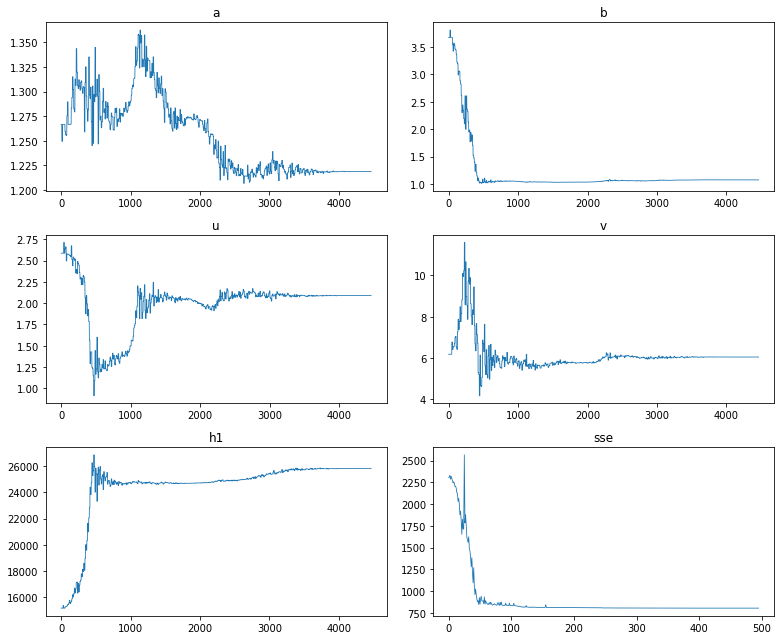

Run 37 Time: 0.75469 minutes

Avg time per run: 0.98945 minutes

Est time remaining: 61.34567 minutes

========Run 38========
{'a': 2.2859754493814943, 'b': 4.264681319736814, 'h1': 20881.82791663379, 'u': 4.9544476103173825, 'v': 2.459108370177756}
a* = -1.43612	b* = -2.08717	            h1* = 3.18087	u* = 0.74163	v* = 1.71878
a = 1.23785	b = 1.12404	            h1 = 28779.06063	u = 2.09935	v = 5.57770
Success: True, Optimization terminated successfully.
Iterations: 386
SSE: 749.979564170101


Height  Suspended Mass
0    4430.75    2.005747e+09
1    5776.50    2.348623e+09
2    7122.25    2.567136e+09
3    8468.00    2.727154e+09
4    9813.75    2.851456e+09
5   11159.50    2.950768e+09
6   12505.25    3.030947e+09
7   13851.00    3.095438e+09
8   15196.75    3.146295e+09
9   16542.50    3.184653e+09
10  17888.25    3.210933e+09
11  19234.00    3.224884e+09
12  20579.75    3.225490e+09
13  21925.50    3.210651e+09
14  23271.25    3.176464e+09
15  24617.00    3.115436e+09
16  25962.75    3.011210e+09
17  27308.50    2.816062e+09
18  28654.25    2.100653e+09
19  30000.00    0.000000e+00

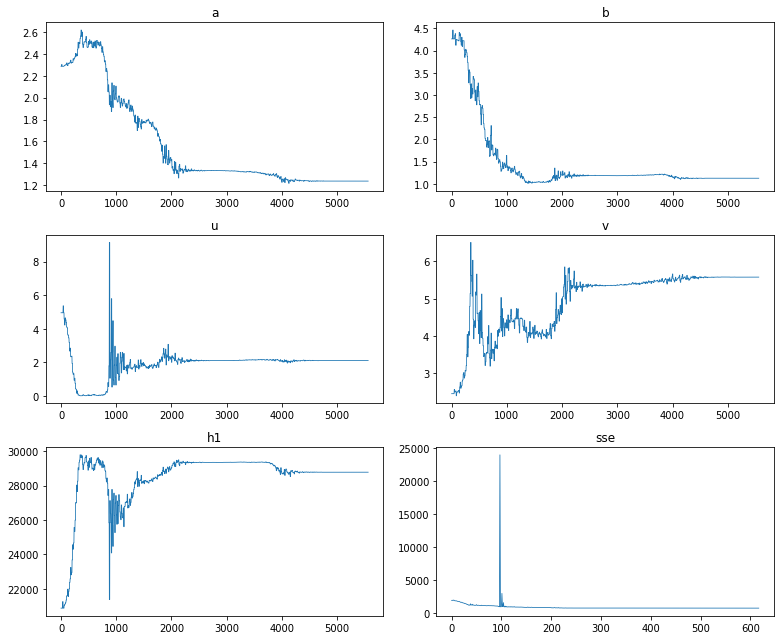

Run 38 Time: 0.94036 minutes

Avg time per run: 0.98819 minutes

Est time remaining: 60.27945 minutes

========Run 39========
{'a': 1.9897129912649463, 'b': 3.2985720070777815, 'h1': 21442.89228839166, 'u': 2.0312682813615255, 'v': 0.5190260923487225}
a* = -1.43608	b* = -2.08709	            h1* = 3.18093	u* = 0.74163	v* = 1.71876
a = 1.23786	b = 1.12405	            h1 = 28779.12479	u = 2.09936	v = 5.57762
Success: True, Optimization terminated successfully.
Iterations: 521
SSE: 749.9795640510301


Height  Suspended Mass
0    4430.75    2.005728e+09
1    5776.50    2.348611e+09
2    7122.25    2.567131e+09
3    8468.00    2.727153e+09
4    9813.75    2.851458e+09
5   11159.50    2.950772e+09
6   12505.25    3.030953e+09
7   13851.00    3.095444e+09
8   15196.75    3.146302e+09
9   16542.50    3.184660e+09
10  17888.25    3.210938e+09
11  19234.00    3.224888e+09
12  20579.75    3.225491e+09
13  21925.50    3.210649e+09
14  23271.25    3.176459e+09
15  24617.00    3.115426e+09
16  25962.75    3.011192e+09
17  27308.50    2.816036e+09
18  28654.25    2.100707e+09
19  30000.00    0.000000e+00

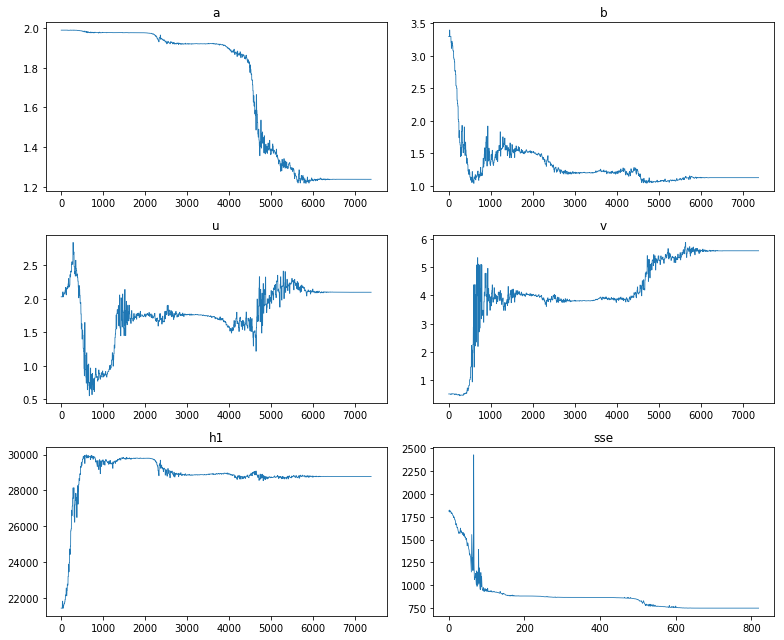

Run 39 Time: 1.24401 minutes

Avg time per run: 0.99458 minutes

Est time remaining: 59.67500 minutes

========Run 40========
{'a': 1.659637558937502, 'b': 1.0879904855850229, 'h1': 17927.61281273958, 'u': 0.6870216738077863, 'v': 0.8820964327761402}
a* = -1.47148	b* = -2.11273	            h1* = 3.14227	u* = 0.74183	v* = 1.71819
a = 1.22959	b = 1.12091	            h1 = 28732.03811	u = 2.09977	v = 5.57445
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 630
SSE: 750.2069136141029


Height  Suspended Mass
0    4430.75    2.040078e+09
1    5776.50    2.375568e+09
2    7122.25    2.588351e+09
3    8468.00    2.743664e+09
4    9813.75    2.863992e+09
5   11159.50    2.959892e+09
6   12505.25    3.037122e+09
7   13851.00    3.099062e+09
8   15196.75    3.147726e+09
9   16542.50    3.184222e+09
10  17888.25    3.208955e+09
11  19234.00    3.221673e+09
12  20579.75    3.221362e+09
13  21925.50    3.205939e+09
14  23271.25    3.171517e+09
15  24617.00    3.110604e+09
16  25962.75    3.006718e+09
17  27308.50    2.810928e+09
18  28654.25    2.002628e+09
19  30000.00    0.000000e+00

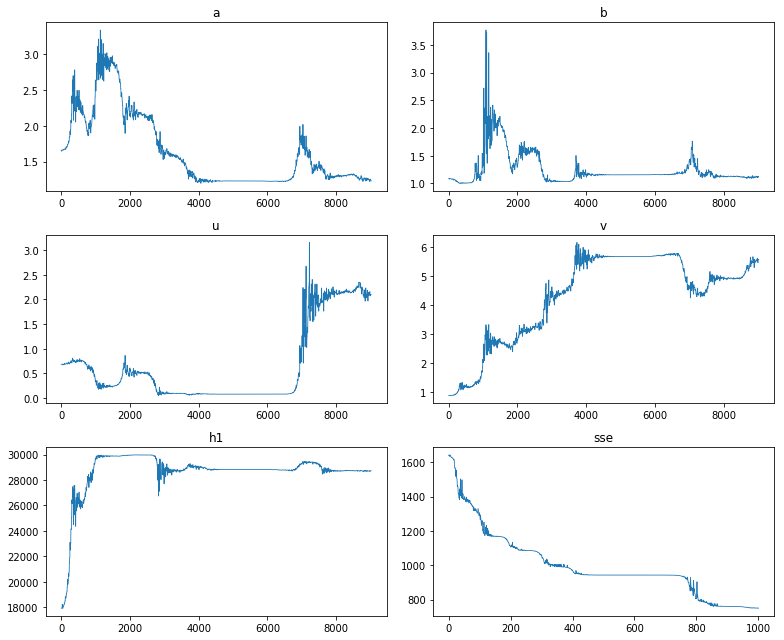

Run 40 Time: 1.50937 minutes

Avg time per run: 1.00714 minutes

Est time remaining: 59.42121 minutes

========Run 41========
{'a': 2.1154858804045222, 'b': 5.564492112268926, 'h1': 13501.556740500302, 'u': 2.2221632084799214, 'v': 0.08752589912457295}
a* = -1.43609	b* = -2.08707	            h1* = 3.18094	u* = 0.74163	v* = 1.71877
a = 1.23786	b = 1.12405	            h1 = 28779.14199	u = 2.09935	v = 5.57766
Success: True, Optimization terminated successfully.
Iterations: 582
SSE: 749.9795639455853


Height  Suspended Mass
0    4430.75    2.005737e+09
1    5776.50    2.348620e+09
2    7122.25    2.567138e+09
3    8468.00    2.727159e+09
4    9813.75    2.851464e+09
5   11159.50    2.950777e+09
6   12505.25    3.030956e+09
7   13851.00    3.095446e+09
8   15196.75    3.146303e+09
9   16542.50    3.184660e+09
10  17888.25    3.210937e+09
11  19234.00    3.224886e+09
12  20579.75    3.225487e+09
13  21925.50    3.210643e+09
14  23271.25    3.176452e+09
15  24617.00    3.115416e+09
16  25962.75    3.011181e+09
17  27308.50    2.816022e+09
18  28654.25    2.100716e+09
19  30000.00    0.000000e+00

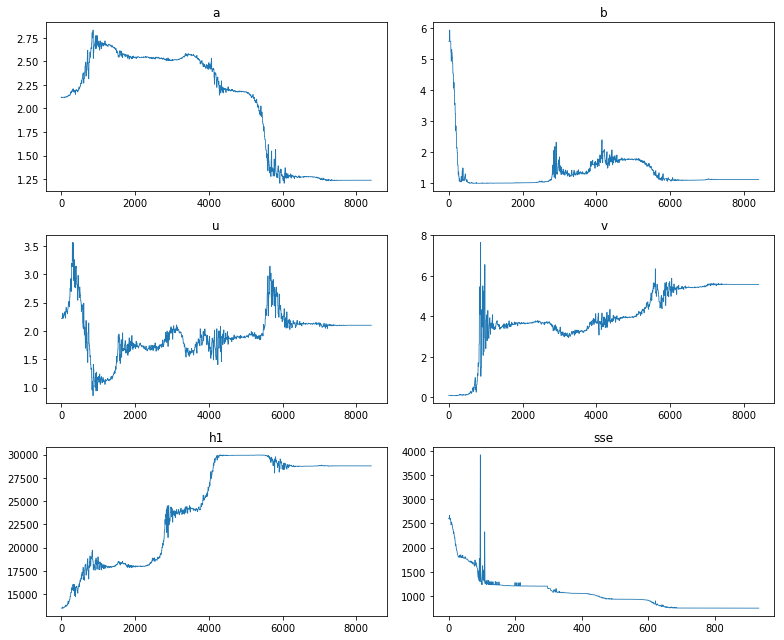

Run 41 Time: 1.40964 minutes

Avg time per run: 1.01672 minutes

Est time remaining: 58.96990 minutes

========Run 42========
{'a': 1.1004180940440516, 'b': 6.92645592506395, 'h1': 28007.954827192032, 'u': 2.6102967677276427, 'v': 3.746349401622165}
a* = -1.43613	b* = -2.08709	            h1* = 3.18091	u* = 0.74162	v* = 1.71879
a = 1.23785	b = 1.12405	            h1 = 28779.10909	u = 2.09933	v = 5.57776
Success: True, Optimization terminated successfully.
Iterations: 217
SSE: 749.9795639633685


Height  Suspended Mass
0    4430.75    2.005776e+09
1    5776.50    2.348650e+09
2    7122.25    2.567162e+09
3    8468.00    2.727177e+09
4    9813.75    2.851477e+09
5   11159.50    2.950786e+09
6   12505.25    3.030961e+09
7   13851.00    3.095448e+09
8   15196.75    3.146302e+09
9   16542.50    3.184656e+09
10  17888.25    3.210931e+09
11  19234.00    3.224878e+09
12  20579.75    3.225478e+09
13  21925.50    3.210633e+09
14  23271.25    3.176441e+09
15  24617.00    3.115405e+09
16  25962.75    3.011170e+09
17  27308.50    2.816012e+09
18  28654.25    2.100657e+09
19  30000.00    0.000000e+00

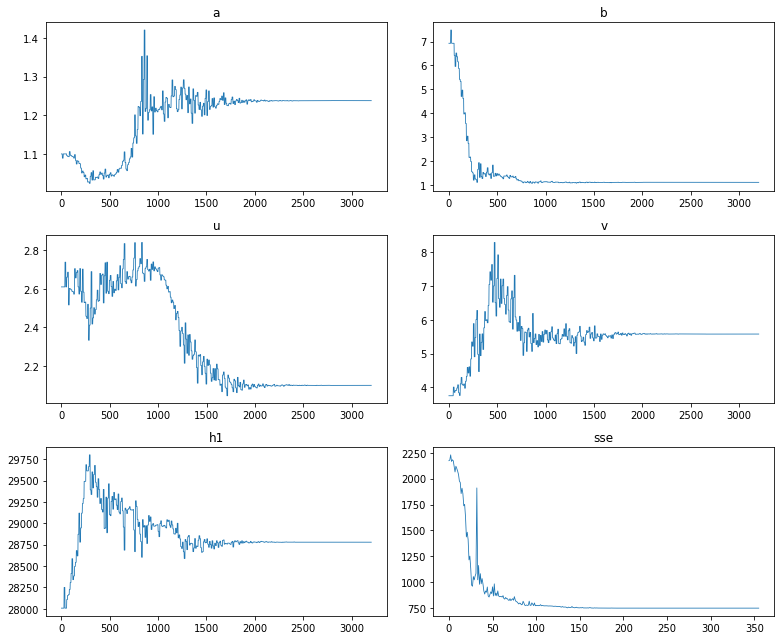

Run 42 Time: 0.54349 minutes

Avg time per run: 1.00572 minutes

Est time remaining: 57.32587 minutes

========Run 43========
{'a': 1.0034784455709065, 'b': 5.124050928794145, 'h1': 10524.356203398856, 'u': 1.7513288758537389, 'v': 9.719850777412024}
a* = 24.94022	b* = 23.82244	            h1* = 0.08864	u* = -2.55044	v* = 0.88658
a = 67826454830.39643	b = 22179604654.71181	            h1 = 12013.42791	u = 0.07805	v = 2.42683
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 592
SSE: 1752.6474592807485


Height  Suspended Mass
0    4430.75    0.000000e+00
1    5776.50    0.000000e+00
2    7122.25    0.000000e+00
3    8468.00    0.000000e+00
4    9813.75    5.500000e+10
5   11159.50    0.000000e+00
6   12505.25    0.000000e+00
7   13851.00    0.000000e+00
8   15196.75    0.000000e+00
9   16542.50    0.000000e+00
10  17888.25    0.000000e+00
11  19234.00    0.000000e+00
12  20579.75    0.000000e+00
13  21925.50    0.000000e+00
14  23271.25    0.000000e+00
15  24617.00    0.000000e+00
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

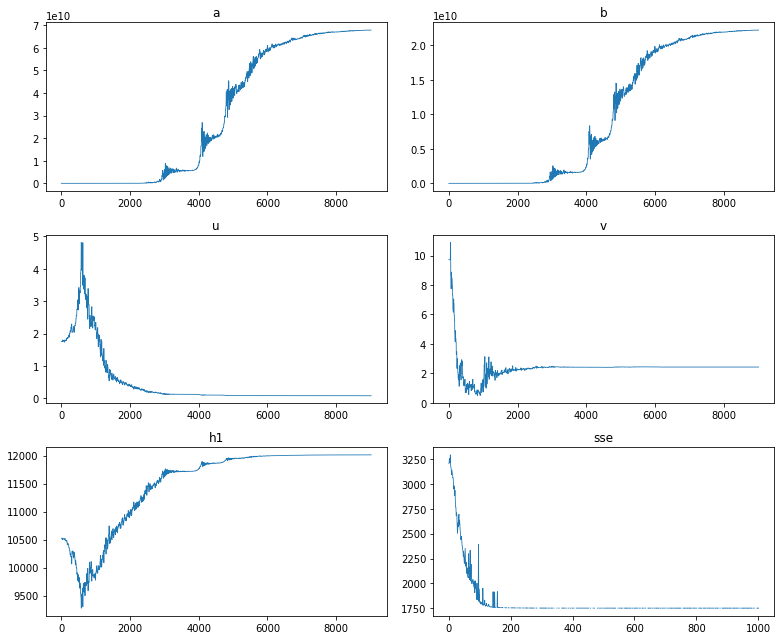

Run 43 Time: 1.52969 minutes

Avg time per run: 1.01763 minutes

Est time remaining: 56.98703 minutes

========Run 44========
{'a': 1.8458779974285897, 'b': 4.696705280867424, 'h1': 12952.047970599997, 'u': 0.1930019306507919, 'v': 15.293791207475037}
a* = -1.53465	b* = -2.49745	            h1* = 2.14817	u* = 0.74273	v* = 1.77264
a = 1.21553	b = 1.08229	            h1 = 26695.61729	u = 2.10166	v = 5.88639
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 627
SSE: 779.3809673317244


Height  Suspended Mass
0    4430.75    2.270371e+09
1    5776.50    2.622709e+09
2    7122.25    2.846603e+09
3    8468.00    3.010989e+09
4    9813.75    3.139462e+09
5   11159.50    3.243039e+09
6   12505.25    3.327692e+09
7   13851.00    3.396888e+09
8   15196.75    3.452634e+09
9   16542.50    3.495942e+09
10  17888.25    3.526986e+09
11  19234.00    3.545048e+09
12  20579.75    3.548185e+09
13  21925.50    3.532328e+09
14  23271.25    3.488774e+09
15  24617.00    3.395252e+09
16  25962.75    3.157097e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

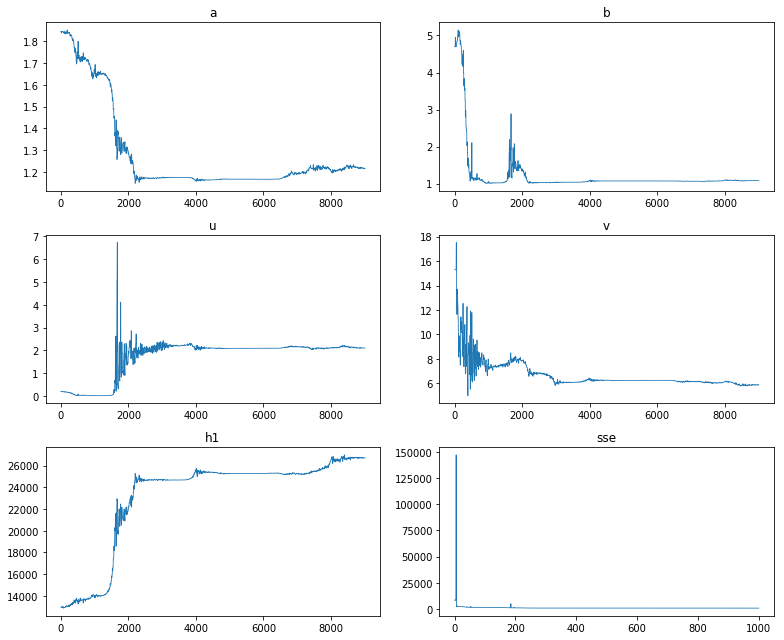

Run 44 Time: 1.51615 minutes

Avg time per run: 1.02870 minutes

Est time remaining: 56.57870 minutes

========Run 45========
{'a': 3.4604559994371824, 'b': 2.602181904309502, 'h1': 27936.557278410084, 'u': 1.251328563142784, 'v': 2.9570136763508246}
a* = -1.43610	b* = -2.08703	            h1* = 3.18097	u* = 0.74164	v* = 1.71876
a = 1.23785	b = 1.12405	            h1 = 28779.17104	u = 2.09938	v = 5.57760
Success: True, Optimization terminated successfully.
Iterations: 274
SSE: 749.9795644809693


Height  Suspended Mass
0    4430.75    2.005758e+09
1    5776.50    2.348639e+09
2    7122.25    2.567155e+09
3    8468.00    2.727173e+09
4    9813.75    2.851475e+09
5   11159.50    2.950786e+09
6   12505.25    3.030963e+09
7   13851.00    3.095451e+09
8   15196.75    3.146305e+09
9   16542.50    3.184659e+09
10  17888.25    3.210934e+09
11  19234.00    3.224880e+09
12  20579.75    3.225478e+09
13  21925.50    3.210632e+09
14  23271.25    3.176436e+09
15  24617.00    3.115397e+09
16  25962.75    3.011157e+09
17  27308.50    2.815995e+09
18  28654.25    2.100726e+09
19  30000.00    0.000000e+00

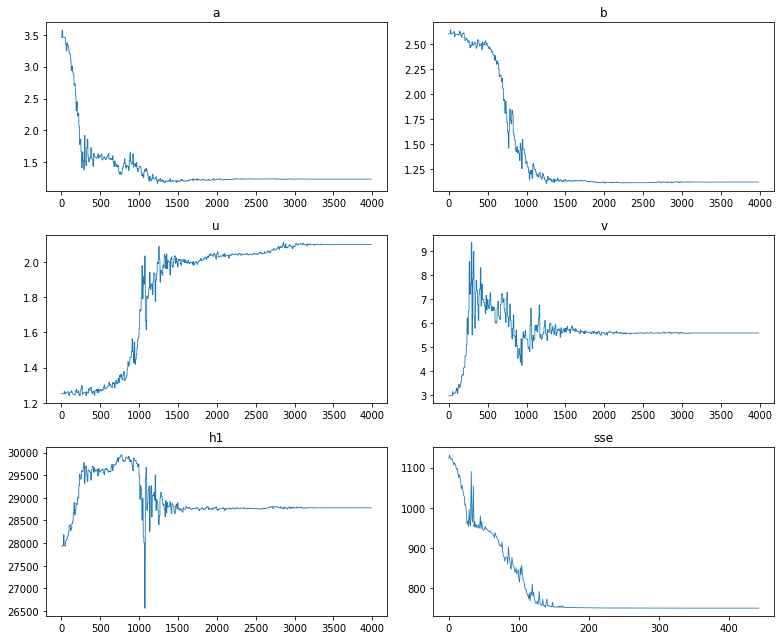

Run 45 Time: 0.67500 minutes

Avg time per run: 1.02101 minutes

Est time remaining: 55.13478 minutes

========Run 46========
{'a': 1.2917843662799098, 'b': 1.4025959030450086, 'h1': 22668.382240012463, 'u': 1.3831219336895035, 'v': 2.9127187237566803}
a* = -1.43613	b* = -2.08707	            h1* = 3.18093	u* = 0.74163	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.13143	u = 2.09935	v = 5.57772
Success: True, Optimization terminated successfully.
Iterations: 531
SSE: 749.9795639106817


Height  Suspended Mass
0    4430.75    2.005775e+09
1    5776.50    2.348650e+09
2    7122.25    2.567162e+09
3    8468.00    2.727178e+09
4    9813.75    2.851478e+09
5   11159.50    2.950787e+09
6   12505.25    3.030962e+09
7   13851.00    3.095449e+09
8   15196.75    3.146302e+09
9   16542.50    3.184656e+09
10  17888.25    3.210931e+09
11  19234.00    3.224877e+09
12  20579.75    3.225476e+09
13  21925.50    3.210631e+09
14  23271.25    3.176437e+09
15  24617.00    3.115400e+09
16  25962.75    3.011163e+09
17  27308.50    2.816004e+09
18  28654.25    2.100682e+09
19  30000.00    0.000000e+00

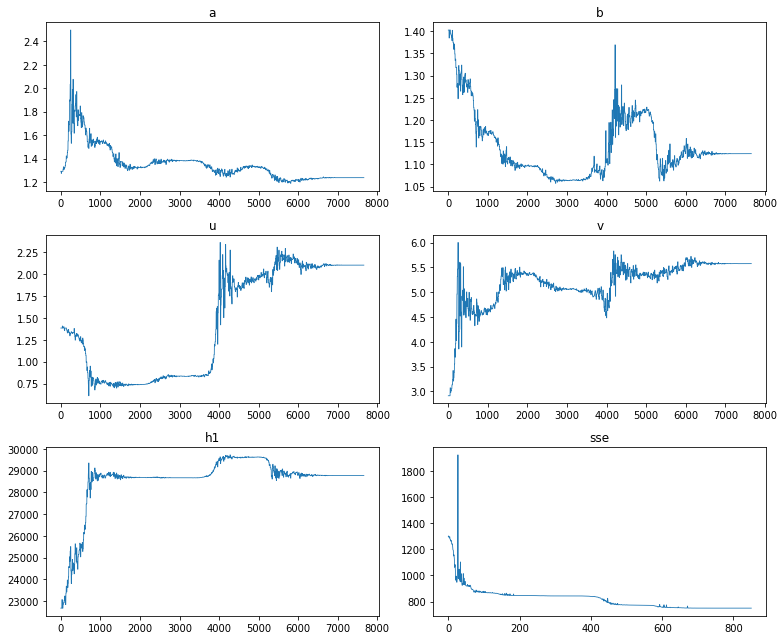

Run 46 Time: 1.27865 minutes

Avg time per run: 1.02650 minutes

Est time remaining: 54.40429 minutes

========Run 47========
{'a': 1.9187039470665286, 'b': 1.1205668852028356, 'h1': 27644.43915336205, 'u': 14.462857246185827, 'v': 4.388752876696034}
a* = -1.43612	b* = -2.08712	            h1* = 3.18095	u* = 0.74163	v* = 1.71878
a = 1.23785	b = 1.12404	            h1 = 28779.14966	u = 2.09935	v = 5.57771
Success: True, Optimization terminated successfully.
Iterations: 381
SSE: 749.9795639698842


Height  Suspended Mass
0    4430.75    2.005759e+09
1    5776.50    2.348633e+09
2    7122.25    2.567146e+09
3    8468.00    2.727162e+09
4    9813.75    2.851462e+09
5   11159.50    2.950772e+09
6   12505.25    3.030949e+09
7   13851.00    3.095437e+09
8   15196.75    3.146292e+09
9   16542.50    3.184648e+09
10  17888.25    3.210925e+09
11  19234.00    3.224873e+09
12  20579.75    3.225475e+09
13  21925.50    3.210633e+09
14  23271.25    3.176443e+09
15  24617.00    3.115411e+09
16  25962.75    3.011181e+09
17  27308.50    2.816032e+09
18  28654.25    2.100764e+09
19  30000.00    0.000000e+00

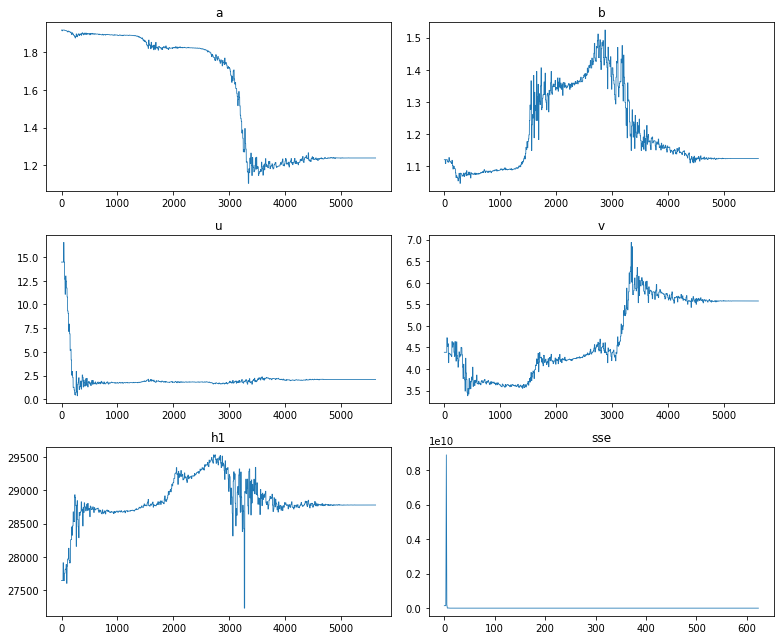

Run 47 Time: 0.94714 minutes

Avg time per run: 1.02484 minutes

Est time remaining: 53.29182 minutes

========Run 48========
{'a': 2.1275870753230697, 'b': 2.8236625598156984, 'h1': 16360.54800334158, 'u': 0.0009441234372247953, 'v': 0.07991719522750487}
a* = -0.28210	b* = -0.80167	            h1* = 4.54246	u* = -33.94640	v* = 1.52303
a = 1.75420	b = 1.44858	            h1 = 29682.27847	u = 0.00000	v = 4.58608
Success: True, Optimization terminated successfully.
Iterations: 562
SSE: 1001.529249515739


Height  Suspended Mass
0    4430.75    8.585493e+08
1    5776.50    1.412969e+09
2    7122.25    1.869189e+09
3    8468.00    2.258914e+09
4    9813.75    2.595503e+09
5   11159.50    2.885869e+09
6   12505.25    3.133815e+09
7   13851.00    3.341310e+09
8   15196.75    3.509046e+09
9   16542.50    3.636669e+09
10  17888.25    3.722821e+09
11  19234.00    3.765037e+09
12  20579.75    3.759453e+09
13  21925.50    3.700248e+09
14  23271.25    3.578553e+09
15  24617.00    3.380230e+09
16  25962.75    3.080648e+09
17  27308.50    2.629479e+09
18  28654.25    1.881698e+09
19  30000.00    0.000000e+00

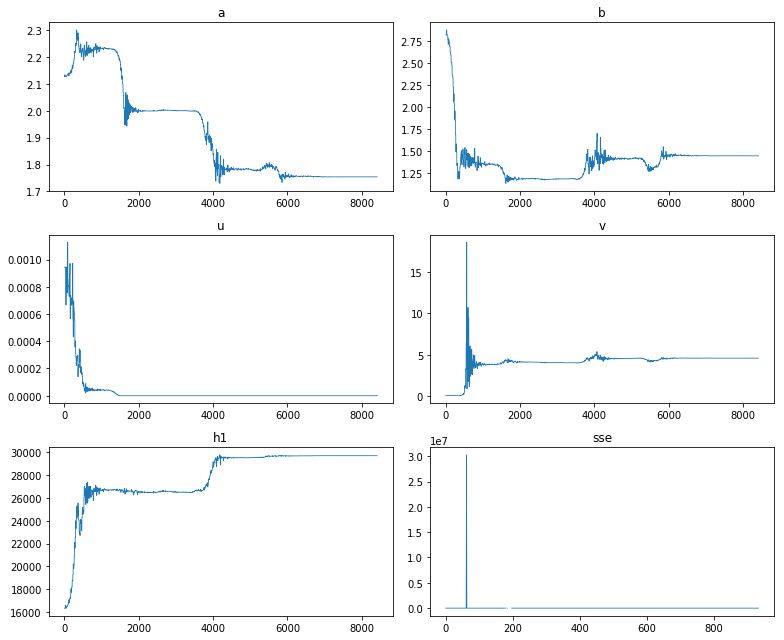

Run 48 Time: 1.41380 minutes

Avg time per run: 1.03278 minutes

Est time remaining: 52.67181 minutes

========Run 49========
{'a': 1.5065793399311946, 'b': 1.532238820274533, 'h1': 25400.447740295305, 'u': 2.6751366921295117, 'v': 0.19867636108459458}
a* = -1.43612	b* = -2.08706	            h1* = 3.18090	u* = 0.74163	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.09741	u = 2.09935	v = 5.57773
Success: True, Optimization terminated successfully.
Iterations: 282
SSE: 749.9795639923127


Height  Suspended Mass
0    4430.75    2.005775e+09
1    5776.50    2.348652e+09
2    7122.25    2.567167e+09
3    8468.00    2.727183e+09
4    9813.75    2.851484e+09
5   11159.50    2.950794e+09
6   12505.25    3.030970e+09
7   13851.00    3.095457e+09
8   15196.75    3.146311e+09
9   16542.50    3.184665e+09
10  17888.25    3.210939e+09
11  19234.00    3.224885e+09
12  20579.75    3.225483e+09
13  21925.50    3.210636e+09
14  23271.25    3.176441e+09
15  24617.00    3.115402e+09
16  25962.75    3.011161e+09
17  27308.50    2.815995e+09
18  28654.25    2.100600e+09
19  30000.00    0.000000e+00

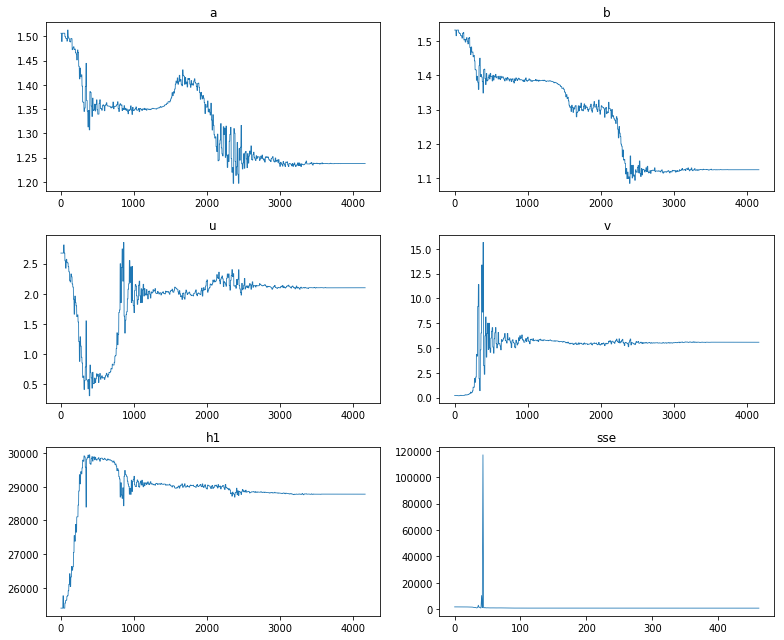

Run 49 Time: 0.70547 minutes

Avg time per run: 1.02623 minutes

Est time remaining: 51.31172 minutes

========Run 50========
{'a': 2.3771468826908926, 'b': 1.5824855037258563, 'h1': 20433.904818425406, 'u': 3.6457742318760484, 'v': 1.7670682023243547}
a* = -1.43609	b* = -2.08712	            h1* = 3.18093	u* = 0.74163	v* = 1.71877
a = 1.23786	b = 1.12404	            h1 = 28779.13055	u = 2.09935	v = 5.57765
Success: True, Optimization terminated successfully.
Iterations: 373
SSE: 749.9795639476787


Height  Suspended Mass
0    4430.75    2.005726e+09
1    5776.50    2.348608e+09
2    7122.25    2.567126e+09
3    8468.00    2.727147e+09
4    9813.75    2.851452e+09
5   11159.50    2.950766e+09
6   12505.25    3.030946e+09
7   13851.00    3.095438e+09
8   15196.75    3.146296e+09
9   16542.50    3.184655e+09
10  17888.25    3.210934e+09
11  19234.00    3.224885e+09
12  20579.75    3.225489e+09
13  21925.50    3.210649e+09
14  23271.25    3.176461e+09
15  24617.00    3.115430e+09
16  25962.75    3.011200e+09
17  27308.50    2.816050e+09
18  28654.25    2.100745e+09
19  30000.00    0.000000e+00

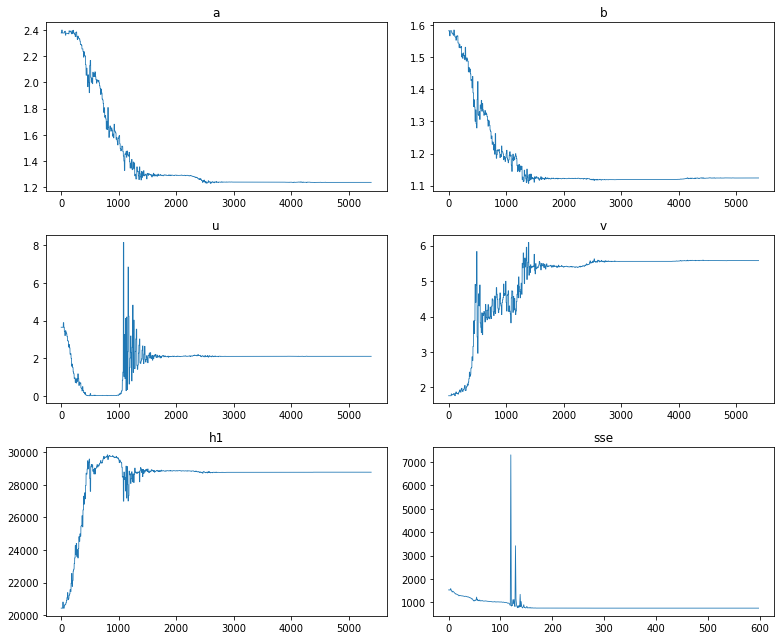

Run 50 Time: 0.91406 minutes

Avg time per run: 1.02403 minutes

Est time remaining: 50.17771 minutes

========Run 51========
{'a': 1.0901773346276062, 'b': 7.598442491890623, 'h1': 15536.623711254977, 'u': 2.6347060526025325, 'v': 1.1629215301791032}
a* = -1.59832	b* = -2.17037	            h1* = 2.13950	u* = -4.74621	v* = 1.80573
a = 1.20224	b = 1.11413	            h1 = 26668.51441	u = 0.00868	v = 6.08442
Success: True, Optimization terminated successfully.
Iterations: 512
SSE: 974.9053033579372


Height  Suspended Mass
0    4430.75    2.406877e+09
1    5776.50    2.749403e+09
2    7122.25    2.961760e+09
3    8468.00    3.113730e+09
4    9813.75    3.229028e+09
5   11159.50    3.318642e+09
6   12505.25    3.388442e+09
7   13851.00    3.441750e+09
8   15196.75    3.480373e+09
9   16542.50    3.505052e+09
10  17888.25    3.515580e+09
11  19234.00    3.510689e+09
12  20579.75    3.487581e+09
13  21925.50    3.440745e+09
14  23271.25    3.358699e+09
15  24617.00    3.212459e+09
16  25962.75    2.879191e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

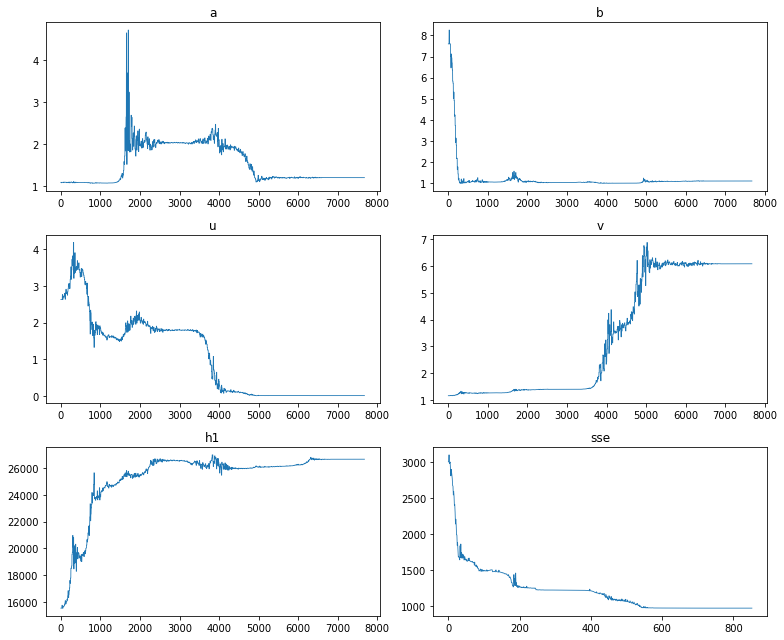

Run 51 Time: 1.29010 minutes

Avg time per run: 1.02915 minutes

Est time remaining: 49.39928 minutes

========Run 52========
{'a': 1.219865282261318, 'b': 3.4573463294520197, 'h1': 25776.819302670956, 'u': 0.17395393137981735, 'v': 0.9853252528030927}
a* = -1.52114	b* = -2.36623	            h1* = 2.51732	u* = 0.74355	v* = 1.74537
a = 1.21846	b = 1.09383	            h1 = 27674.78404	u = 2.10338	v = 5.72802
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 614
SSE: 759.3922939131674


Height  Suspended Mass
0    4430.75    2.145255e+09
1    5776.50    2.482060e+09
2    7122.25    2.695858e+09
3    8468.00    2.852540e+09
4    9813.75    2.974696e+09
5   11159.50    3.072900e+09
6   12505.25    3.152899e+09
7   13851.00    3.218055e+09
8   15196.75    3.270352e+09
9   16542.50    3.310856e+09
10  17888.25    3.339892e+09
11  19234.00    3.357062e+09
12  20579.75    3.361057e+09
13  21925.50    3.349162e+09
14  23271.25    3.316003e+09
15  24617.00    3.249940e+09
16  25962.75    3.118825e+09
17  27308.50    2.732587e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

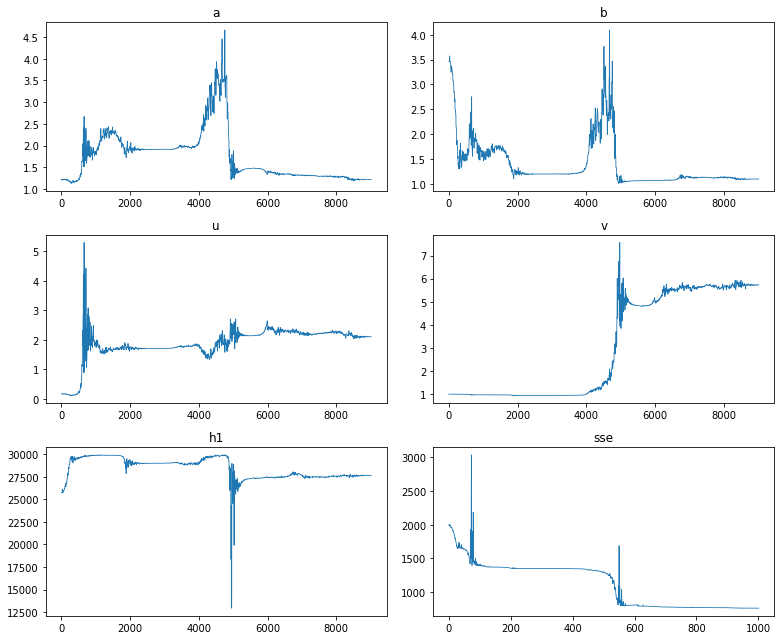

Run 52 Time: 1.51667 minutes

Avg time per run: 1.03835 minutes

Est time remaining: 48.80245 minutes

========Run 53========
{'a': 1.1572895856321392, 'b': 6.069836893498754, 'h1': 12640.662991487196, 'u': 0.3773144944274247, 'v': 0.04755322724382729}
a* = -0.18991	b* = -1.23825	            h1* = 1.84850	u* = 0.57779	v* = -19.26657
a = 1.82703	b = 1.28989	            h1 = 25628.97789	u = 1.78210	v = 0.00000
Success: True, Optimization terminated successfully.
Iterations: 468
SSE: 1721.8504675170998


Height  Suspended Mass
0    4430.75    8.372932e+08
1    5776.50    1.457409e+09
2    7122.25    1.996997e+09
3    8468.00    2.478568e+09
4    9813.75    2.911167e+09
5   11159.50    3.298801e+09
6   12505.25    3.642782e+09
7   13851.00    3.942515e+09
8   15196.75    4.195683e+09
9   16542.50    4.398023e+09
10  17888.25    4.542658e+09
11  19234.00    4.618681e+09
12  20579.75    4.608084e+09
13  21925.50    4.478311e+09
14  23271.25    4.159511e+09
15  24617.00    3.433516e+09
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

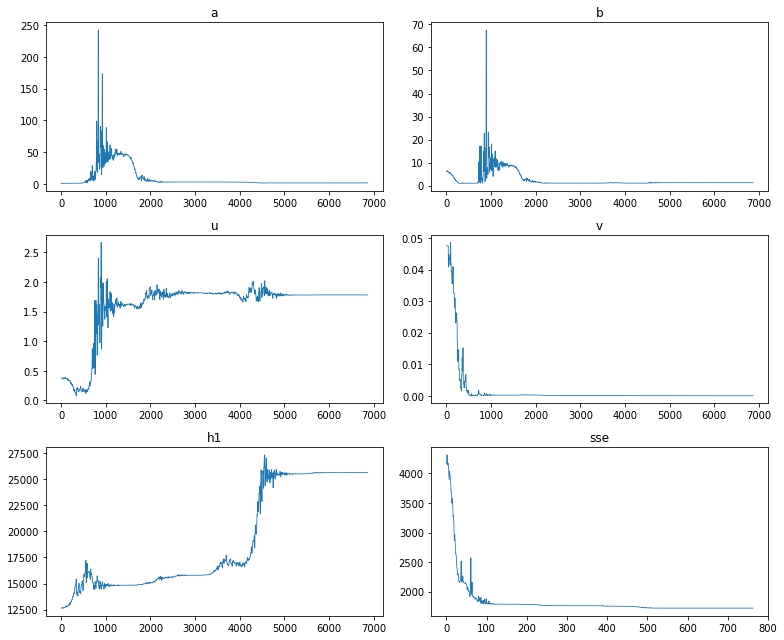

Run 53 Time: 1.16120 minutes

Avg time per run: 1.04062 minutes

Est time remaining: 47.86875 minutes

========Run 54========
{'a': 1.3923695354369077, 'b': 18.580649389192885, 'h1': 22720.196979431294, 'u': 6.238963891561614, 'v': 0.29295892081502284}
a* = -1.43610	b* = -2.08708	            h1* = 3.18096	u* = 0.74163	v* = 1.71877
a = 1.23785	b = 1.12405	            h1 = 28779.16233	u = 2.09936	v = 5.57769
Success: True, Optimization terminated successfully.
Iterations: 422
SSE: 749.9795639687184


Height  Suspended Mass
0    4430.75    2.005745e+09
1    5776.50    2.348624e+09
2    7122.25    2.567141e+09
3    8468.00    2.727159e+09
4    9813.75    2.851462e+09
5   11159.50    2.950774e+09
6   12505.25    3.030953e+09
7   13851.00    3.095442e+09
8   15196.75    3.146298e+09
9   16542.50    3.184654e+09
10  17888.25    3.210931e+09
11  19234.00    3.224879e+09
12  20579.75    3.225481e+09
13  21925.50    3.210637e+09
14  23271.25    3.176446e+09
15  24617.00    3.115412e+09
16  25962.75    3.011178e+09
17  27308.50    2.816023e+09
18  28654.25    2.100761e+09
19  30000.00    0.000000e+00

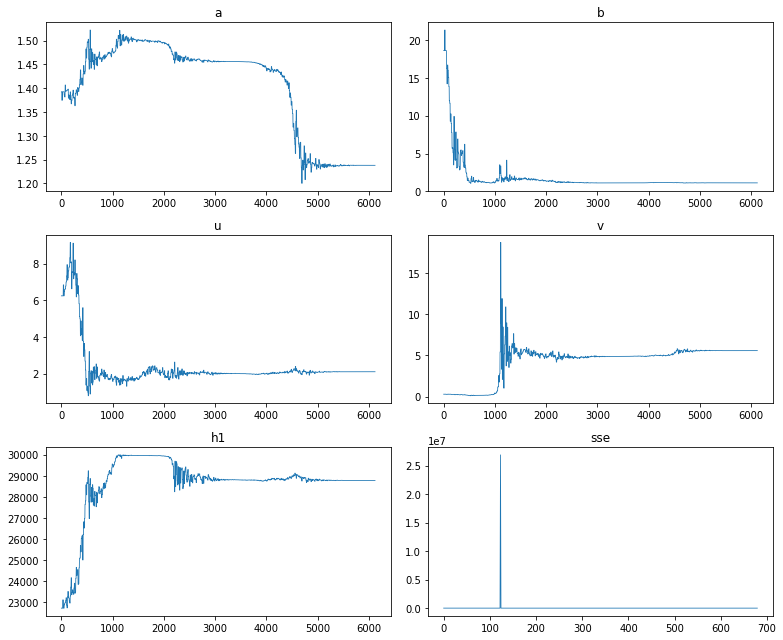

Run 54 Time: 1.03594 minutes

Avg time per run: 1.04054 minutes

Est time remaining: 46.82429 minutes

========Run 55========
{'a': 3.199836962440988, 'b': 1.4398883139519754, 'h1': 28619.641429619292, 'u': 2.202845834307823, 'v': 1.0996440663626406}
a* = -1.51934	b* = -2.36787	            h1* = 2.51709	u* = 0.74491	v* = 1.74487
a = 1.21886	b = 1.09368	            h1 = 27674.28587	u = 2.10625	v = 5.72513
Success: True, Optimization terminated successfully.
Iterations: 546
SSE: 759.3917039564836


Height  Suspended Mass
0    4430.75    2.143174e+09
1    5776.50    2.480350e+09
2    7122.25    2.694455e+09
3    8468.00    2.851407e+09
4    9813.75    2.973808e+09
5   11159.50    3.072240e+09
6   12505.25    3.152452e+09
7   13851.00    3.217812e+09
8   15196.75    3.270307e+09
9   16542.50    3.311004e+09
10  17888.25    3.340231e+09
11  19234.00    3.357592e+09
12  20579.75    3.361779e+09
13  21925.50    3.350082e+09
14  23271.25    3.317131e+09
15  24617.00    3.251296e+09
16  25962.75    3.120441e+09
17  27308.50    2.734438e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

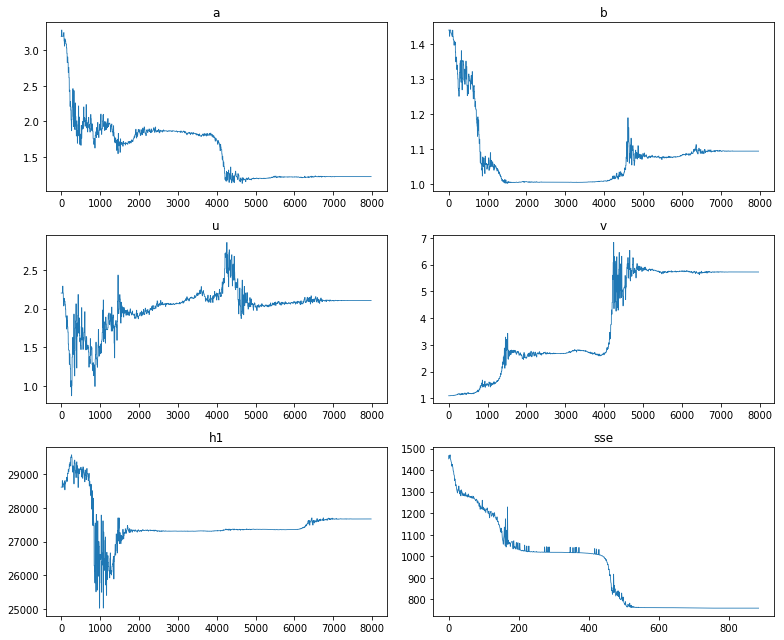

Run 55 Time: 1.35156 minutes

Avg time per run: 1.04609 minutes

Est time remaining: 46.02813 minutes

========Run 56========
{'a': 1.5062725748253014, 'b': 3.058015708441093, 'h1': 21570.018232265327, 'u': 0.5013701135033407, 'v': 4.696210826336429}
a* = -1.43609	b* = -2.08702	            h1* = 3.18095	u* = 0.74160	v* = 1.71877
a = 1.23786	b = 1.12406	            h1 = 28779.15312	u = 2.09929	v = 5.57768
Success: True, Optimization terminated successfully.
Iterations: 315
SSE: 749.9795641358814


Height  Suspended Mass
0    4430.75    2.005749e+09
1    5776.50    2.348633e+09
2    7122.25    2.567152e+09
3    8468.00    2.727172e+09
4    9813.75    2.851476e+09
5   11159.50    2.950788e+09
6   12505.25    3.030967e+09
7   13851.00    3.095456e+09
8   15196.75    3.146310e+09
9   16542.50    3.184665e+09
10  17888.25    3.210940e+09
11  19234.00    3.224887e+09
12  20579.75    3.225485e+09
13  21925.50    3.210638e+09
14  23271.25    3.176442e+09
15  24617.00    3.115402e+09
16  25962.75    3.011160e+09
17  27308.50    2.815993e+09
18  28654.25    2.100684e+09
19  30000.00    0.000000e+00

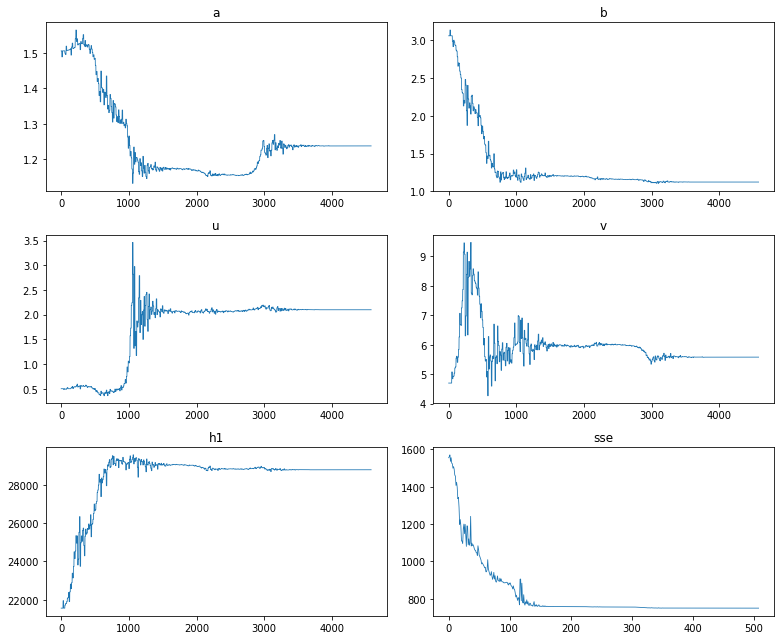

Run 56 Time: 0.77734 minutes

Avg time per run: 1.04138 minutes

Est time remaining: 44.77929 minutes

========Run 57========
{'a': 1.8082601206925633, 'b': 2.381438892975746, 'h1': 14586.767076747115, 'u': 5.90715035906358, 'v': 5.850066159721012}
a* = -1.41485	b* = -2.03906	            h1* = 3.17445	u* = 0.74210	v* = 1.71132
a = 1.24296	b = 1.13015	            h1 = 28771.35163	u = 2.10035	v = 5.53627
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 605
SSE: 750.1268536605256


Height  Suspended Mass
0    4430.75    1.997676e+09
1    5776.50    2.346653e+09
2    7122.25    2.569351e+09
3    8468.00    2.732443e+09
4    9813.75    2.859039e+09
5   11159.50    2.960030e+09
6   12505.25    3.041365e+09
7   13851.00    3.106541e+09
8   15196.75    3.157637e+09
9   16542.50    3.195791e+09
10  17888.25    3.221404e+09
11  19234.00    3.234190e+09
12  20579.75    3.233060e+09
13  21925.50    3.215802e+09
14  23271.25    3.178319e+09
15  24617.00    3.112765e+09
16  25962.75    3.002036e+09
17  27308.50    2.796255e+09
18  28654.25    2.039641e+09
19  30000.00    0.000000e+00

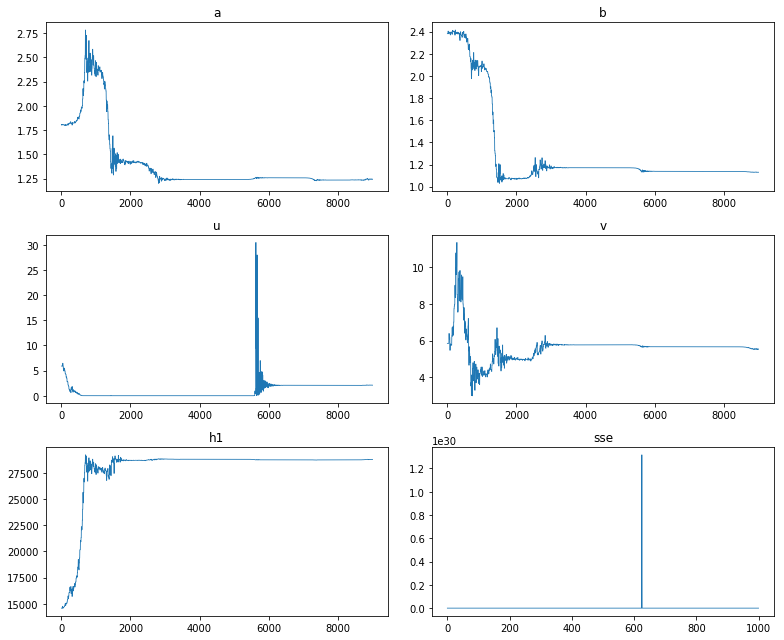

Run 57 Time: 1.51615 minutes

Avg time per run: 1.04956 minutes

Est time remaining: 44.08171 minutes

========Run 58========
{'a': 1.738220586485258, 'b': 5.115804251658646, 'h1': 14462.195104874241, 'u': 1.5417760572222874, 'v': 0.8950048214838564}
a* = -1.42196	b* = -2.03099	            h1* = 3.20750	u* = 0.72334	v* = 1.72511
a = 1.24124	b = 1.13121	            h1 = 28810.50133	u = 2.06130	v = 5.61313
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 616
SSE: 750.158629184052


Height  Suspended Mass
0    4430.75    2.003437e+09
1    5776.50    2.350502e+09
2    7122.25    2.571641e+09
3    8468.00    2.733383e+09
4    9813.75    2.858768e+09
5   11159.50    2.958651e+09
6   12505.25    3.038960e+09
7   13851.00    3.103176e+09
8   15196.75    3.153370e+09
9   16542.50    3.190674e+09
10  17888.25    3.215490e+09
11  19234.00    3.227533e+09
12  20579.75    3.225727e+09
13  21925.50    3.207885e+09
14  23271.25    3.169964e+09
15  24617.00    3.104249e+09
16  25962.75    2.994027e+09
17  27308.50    2.791201e+09
18  28654.25    2.101360e+09
19  30000.00    0.000000e+00

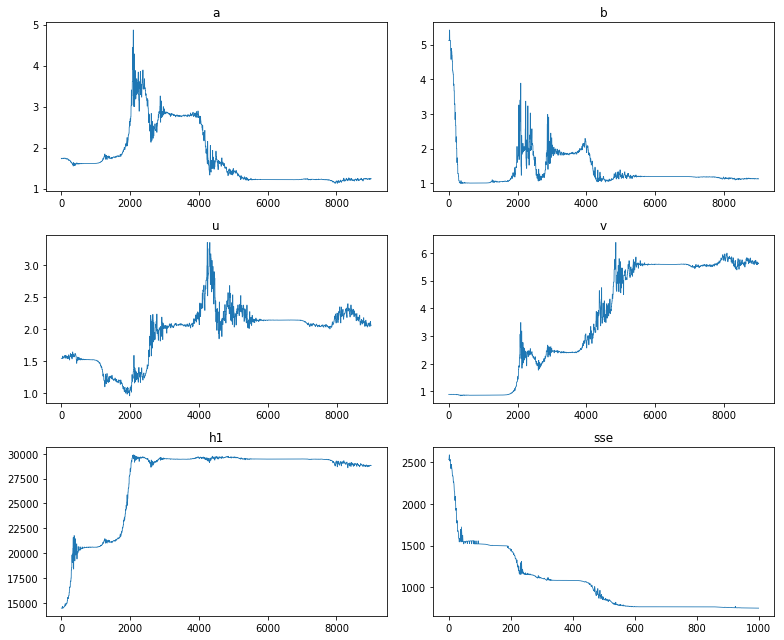

Run 58 Time: 1.52135 minutes

Avg time per run: 1.05756 minutes

Est time remaining: 43.36000 minutes

========Run 59========
{'a': 4.782954221565447, 'b': 11.725337334630058, 'h1': 19559.828414475553, 'u': 0.06609337833180425, 'v': 1.2162115804370066}
a* = -1.53305	b* = -2.51479	            h1* = 2.14588	u* = 0.74329	v* = 1.77168
a = 1.21588	b = 1.08088	            h1 = 26688.48809	u = 2.10284	v = 5.88071
Success: True, Optimization terminated successfully.
Iterations: 602
SSE: 779.37764749409


Height  Suspended Mass
0    4430.75    2.265824e+09
1    5776.50    2.618307e+09
2    7122.25    2.842483e+09
3    8468.00    3.007226e+09
4    9813.75    3.136111e+09
5   11159.50    3.240153e+09
6   12505.25    3.325321e+09
7   13851.00    3.395087e+09
8   15196.75    3.451466e+09
9   16542.50    3.495479e+09
10  17888.25    3.527313e+09
11  19234.00    3.546272e+09
12  20579.75    3.550446e+09
13  21925.50    3.535818e+09
14  23271.25    3.493776e+09
15  24617.00    3.402225e+09
16  25962.75    3.166692e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

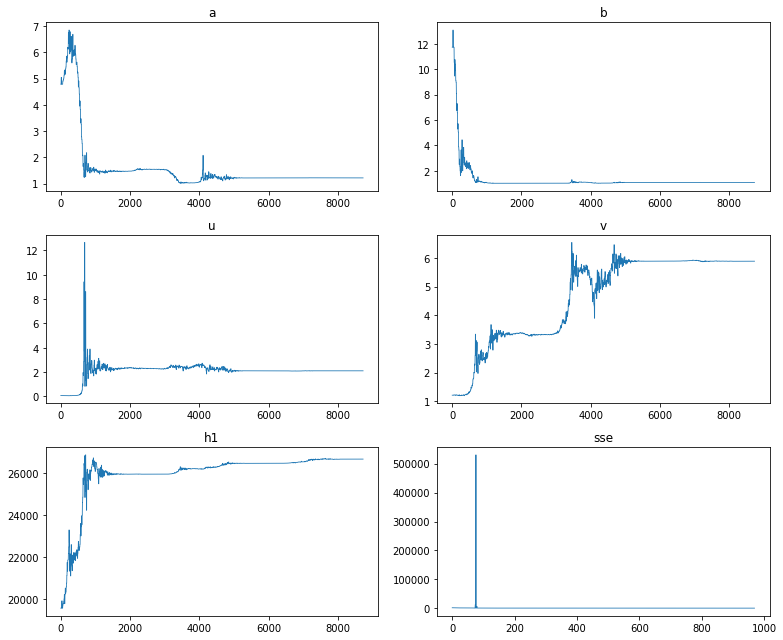

Run 59 Time: 1.45703 minutes

Avg time per run: 1.06422 minutes

Est time remaining: 42.56875 minutes

========Run 60========
{'a': 1.7183974803329791, 'b': 12.415853008120756, 'h1': 29808.770330003263, 'u': 2.8710546258988594, 'v': 0.1877518908909404}
a* = -1.43608	b* = -2.08667	            h1* = 3.18079	u* = 0.74162	v* = 1.71879
a = 1.23786	b = 1.12410	            h1 = 28778.96124	u = 2.09933	v = 5.57780
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 619
SSE: 749.9795715858849


Height  Suspended Mass
0    4430.75    2.005854e+09
1    5776.50    2.348753e+09
2    7122.25    2.567277e+09
3    8468.00    2.727299e+09
4    9813.75    2.851601e+09
5   11159.50    2.950909e+09
6   12505.25    3.031080e+09
7   13851.00    3.095560e+09
8   15196.75    3.146404e+09
9   16542.50    3.184745e+09
10  17888.25    3.211004e+09
11  19234.00    3.224931e+09
12  20579.75    3.225508e+09
13  21925.50    3.210634e+09
14  23271.25    3.176405e+09
15  24617.00    3.115324e+09
16  25962.75    3.011025e+09
17  27308.50    2.815766e+09
18  28654.25    2.099922e+09
19  30000.00    0.000000e+00

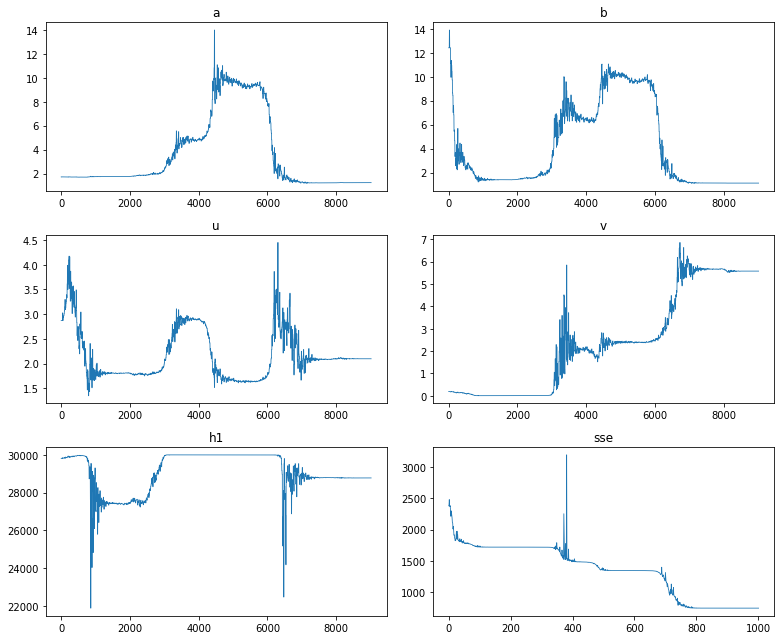

Run 60 Time: 1.51380 minutes

Avg time per run: 1.07159 minutes

Est time remaining: 41.79197 minutes

========Run 61========
{'a': 2.0088770779861, 'b': 5.042742408976383, 'h1': 10416.443539051155, 'u': 2.0633174943398362, 'v': 2.5237947174176534}
a* = 0.06531	b* = -2.79330	            h1* = 1.34015	u* = 0.56942	v* = 1.38373
a = 2.06749	b = 1.06122	            h1 = 23089.82525	u = 1.76725	v = 3.98976
Success: True, Optimization terminated successfully.
Iterations: 530
SSE: 1001.2813337484716


Height  Suspended Mass
0    4430.75    4.881069e+08
1    5776.50    1.018292e+09
2    7122.25    1.562059e+09
3    8468.00    2.112165e+09
4    9813.75    2.664475e+09
5   11159.50    3.215848e+09
6   12505.25    3.763386e+09
7   13851.00    4.303972e+09
8   15196.75    4.833802e+09
9   16542.50    5.347673e+09
10  17888.25    5.837592e+09
11  19234.00    6.289459e+09
12  20579.75    6.672806e+09
13  21925.50    6.890363e+09
14  23271.25    0.000000e+00
15  24617.00    0.000000e+00
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

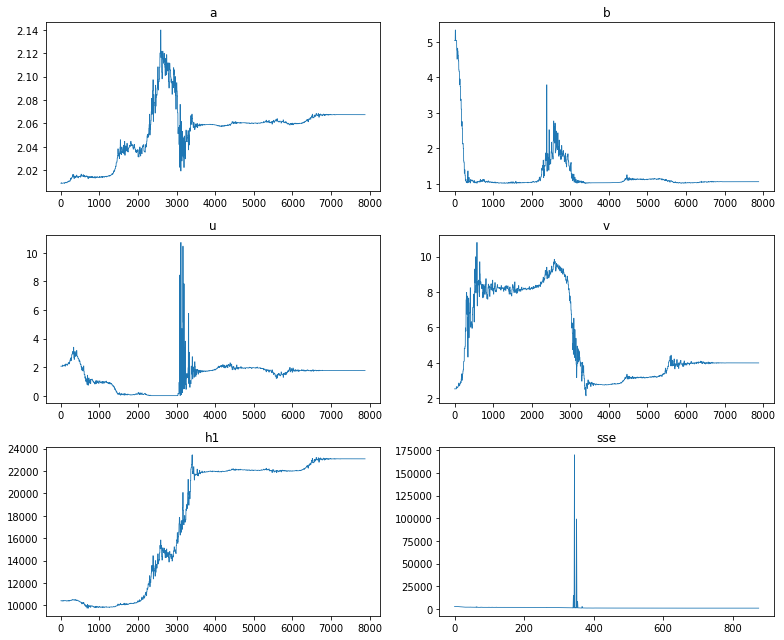

Run 61 Time: 1.32552 minutes

Avg time per run: 1.07568 minutes

Est time remaining: 40.87602 minutes

========Run 62========
{'a': 2.156785494907167, 'b': 5.971951025418785, 'h1': 24611.863355769296, 'u': 5.241955913146471, 'v': 3.1740147350354144}
a* = -1.43608	b* = -2.08706	            h1* = 3.18099	u* = 0.74161	v* = 1.71877
a = 1.23786	b = 1.12405	            h1 = 28779.19398	u = 2.09932	v = 5.57765
Success: True, Optimization terminated successfully.
Iterations: 298
SSE: 749.9795642081368


Height  Suspended Mass
0    4430.75    2.005728e+09
1    5776.50    2.348612e+09
2    7122.25    2.567131e+09
3    8468.00    2.727153e+09
4    9813.75    2.851458e+09
5   11159.50    2.950771e+09
6   12505.25    3.030951e+09
7   13851.00    3.095442e+09
8   15196.75    3.146298e+09
9   16542.50    3.184655e+09
10  17888.25    3.210933e+09
11  19234.00    3.224881e+09
12  20579.75    3.225483e+09
13  21925.50    3.210639e+09
14  23271.25    3.176447e+09
15  24617.00    3.115412e+09
16  25962.75    3.011177e+09
17  27308.50    2.816022e+09
18  28654.25    2.100807e+09
19  30000.00    0.000000e+00

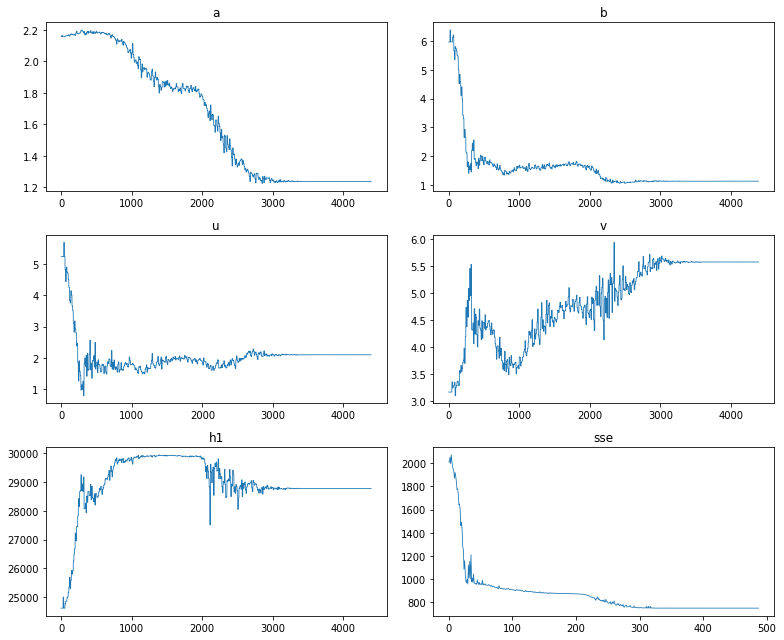

Run 62 Time: 0.74245 minutes

Avg time per run: 1.07040 minutes

Est time remaining: 39.60462 minutes

========Run 63========
{'a': 1.3204626410046458, 'b': 9.0016069992097, 'h1': 26597.11389791353, 'u': 0.1298051489240503, 'v': 0.2766047033587615}
a* = -1.68961	b* = -2.01351	            h1* = 3.19499	u* = 0.74452	v* = 1.75448
a = 1.18459	b = 1.13352	            h1 = 28795.82755	u = 2.10543	v = 5.78044
Success: True, Optimization terminated successfully.
Iterations: 376
SSE: 752.0750549605273


Height  Suspended Mass
0    4430.75    2.265314e+09
1    5776.50    2.555061e+09
2    7122.25    2.731575e+09
3    8468.00    2.856003e+09
4    9813.75    2.949006e+09
5   11159.50    3.020145e+09
6   12505.25    3.074560e+09
7   13851.00    3.115216e+09
8   15196.75    3.143827e+09
9   16542.50    3.161277e+09
10  17888.25    3.167796e+09
11  19234.00    3.162984e+09
12  20579.75    3.145705e+09
13  21925.50    3.113768e+09
14  23271.25    3.063204e+09
15  24617.00    2.986491e+09
16  25962.75    2.867370e+09
17  27308.50    2.658890e+09
18  28654.25    1.961808e+09
19  30000.00    0.000000e+00

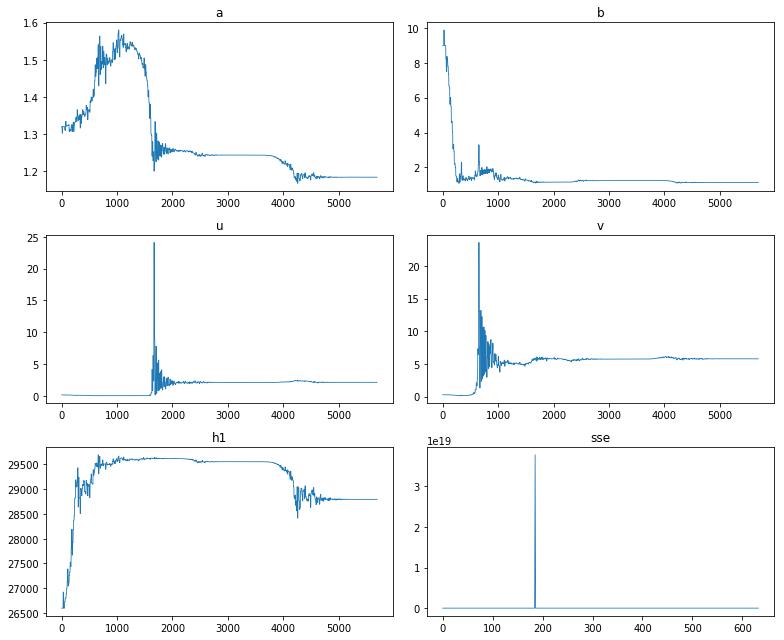

Run 63 Time: 0.95547 minutes

Avg time per run: 1.06860 minutes

Est time remaining: 38.46958 minutes

========Run 64========
{'a': 1.8830310657530485, 'b': 6.442330524511511, 'h1': 18594.652304982636, 'u': 6.3188866929861724, 'v': 3.074896790775734}
a* = -1.53303	b* = -2.51478	            h1* = 2.14588	u* = 0.74327	v* = 1.77168
a = 1.21588	b = 1.08088	            h1 = 26688.49869	u = 2.10279	v = 5.88073
Success: True, Optimization terminated successfully.
Iterations: 364
SSE: 779.3776474958876


Height  Suspended Mass
0    4430.75    2.265801e+09
1    5776.50    2.618289e+09
2    7122.25    2.842470e+09
3    8468.00    3.007217e+09
4    9813.75    3.136105e+09
5   11159.50    3.240149e+09
6   12505.25    3.325320e+09
7   13851.00    3.395088e+09
8   15196.75    3.451469e+09
9   16542.50    3.495483e+09
10  17888.25    3.527319e+09
11  19234.00    3.546279e+09
12  20579.75    3.550455e+09
13  21925.50    3.535828e+09
14  23271.25    3.493787e+09
15  24617.00    3.402236e+09
16  25962.75    3.166704e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

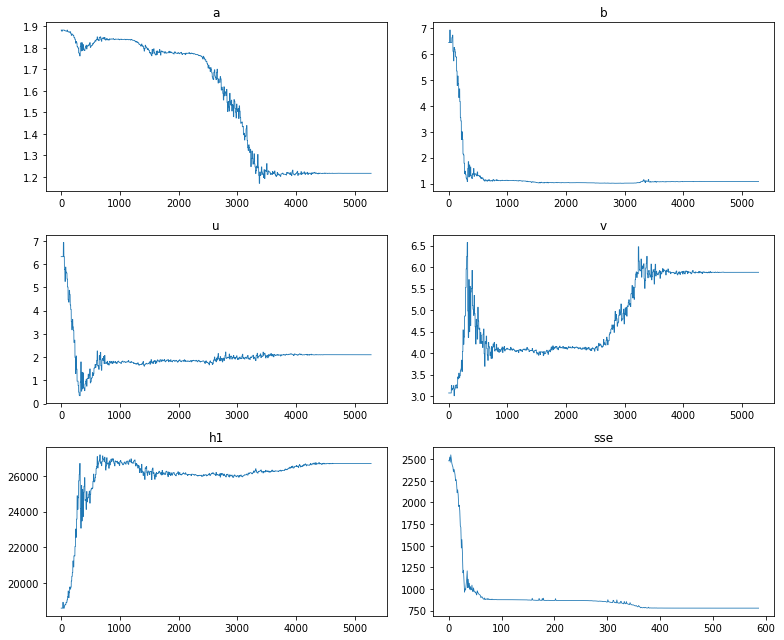

Run 64 Time: 0.89036 minutes

Avg time per run: 1.06586 minutes

Est time remaining: 37.30501 minutes

========Run 65========
{'a': 1.495868865727753, 'b': 1.047475072167402, 'h1': 16613.621276832004, 'u': 0.9870207783840559, 'v': 0.1795315380594964}
a* = -1.43610	b* = -2.08705	            h1* = 3.18092	u* = 0.74163	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.11807	u = 2.09935	v = 5.57770
Success: True, Optimization terminated successfully.
Iterations: 512
SSE: 749.9795639438933


Height  Suspended Mass
0    4430.75    2.005758e+09
1    5776.50    2.348639e+09
2    7122.25    2.567156e+09
3    8468.00    2.727175e+09
4    9813.75    2.851478e+09
5   11159.50    2.950789e+09
6   12505.25    3.030967e+09
7   13851.00    3.095455e+09
8   15196.75    3.146310e+09
9   16542.50    3.184665e+09
10  17888.25    3.210940e+09
11  19234.00    3.224886e+09
12  20579.75    3.225486e+09
13  21925.50    3.210639e+09
14  23271.25    3.176445e+09
15  24617.00    3.115406e+09
16  25962.75    3.011166e+09
17  27308.50    2.816000e+09
18  28654.25    2.100640e+09
19  30000.00    0.000000e+00

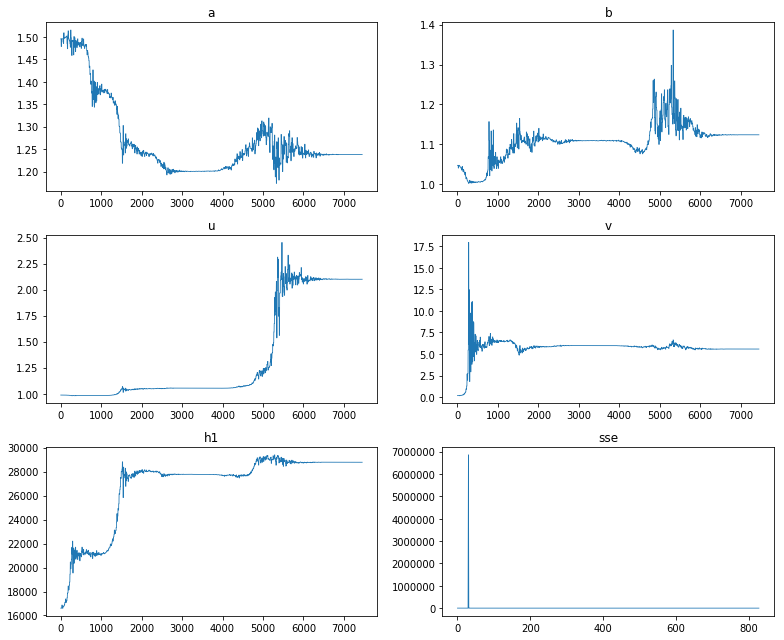

Run 65 Time: 1.25469 minutes

Avg time per run: 1.06872 minutes

Est time remaining: 36.33643 minutes

========Run 66========
{'a': 5.549074931033989, 'b': 3.915280988071904, 'h1': 13561.664188196031, 'u': 0.6604219261660715, 'v': 0.4655453997892099}
a* = 8.62798	b* = -1.60387	            h1* = 0.51875	u* = 0.30678	v* = 0.83015
a = 5586.80490	b = 1.20112	            h1 = 16542.52859	u = 1.35905	v = 2.29366
Success: True, Optimization terminated successfully.
Iterations: 276
SSE: 1397.0880188906206


Height  Suspended Mass
0    4430.75    0.000000e+00
1    5776.50    0.000000e+00
2    7122.25    0.000000e+00
3    8468.00    0.000000e+00
4    9813.75    0.000000e+00
5   11159.50    0.000000e+00
6   12505.25    0.000000e+00
7   13851.00    0.000000e+00
8   15196.75   1.223786e-244
9   16542.50    5.500000e+10
10  17888.25    0.000000e+00
11  19234.00    0.000000e+00
12  20579.75    0.000000e+00
13  21925.50    0.000000e+00
14  23271.25    0.000000e+00
15  24617.00    0.000000e+00
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

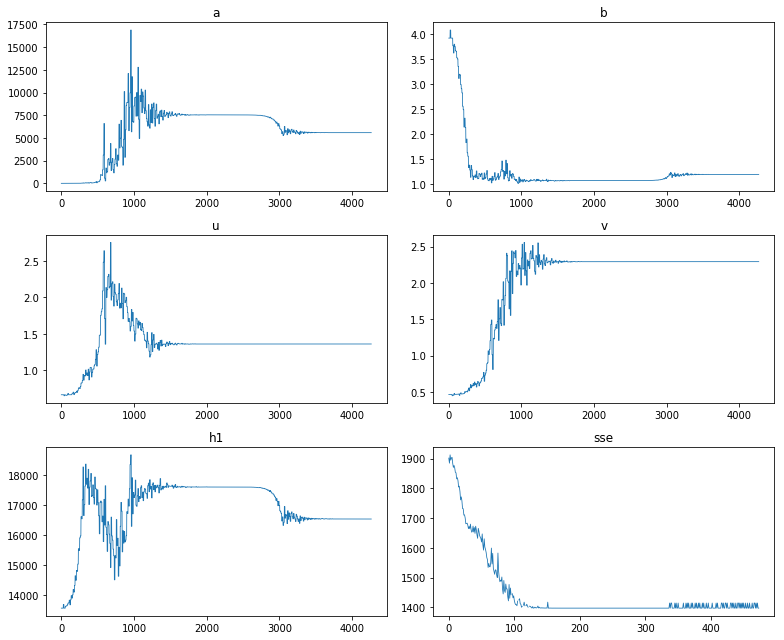

Run 66 Time: 0.72214 minutes

Avg time per run: 1.06355 minutes

Est time remaining: 35.09700 minutes

========Run 67========
{'a': 2.2202016277507552, 'b': 1.876471848638207, 'h1': 25795.842135515337, 'u': 4.7322220814679765, 'v': 1.1253876159719054}
a* = -1.43608	b* = -2.08706	            h1* = 3.18096	u* = 0.74164	v* = 1.71878
a = 1.23786	b = 1.12405	            h1 = 28779.16232	u = 2.09937	v = 5.57771
Success: True, Optimization terminated successfully.
Iterations: 404
SSE: 749.9795639820995


Height  Suspended Mass
0    4430.75    2.005731e+09
1    5776.50    2.348615e+09
2    7122.25    2.567134e+09
3    8468.00    2.727156e+09
4    9813.75    2.851461e+09
5   11159.50    2.950775e+09
6   12505.25    3.030955e+09
7   13851.00    3.095445e+09
8   15196.75    3.146302e+09
9   16542.50    3.184659e+09
10  17888.25    3.210936e+09
11  19234.00    3.224885e+09
12  20579.75    3.225487e+09
13  21925.50    3.210643e+09
14  23271.25    3.176451e+09
15  24617.00    3.115415e+09
16  25962.75    3.011179e+09
17  27308.50    2.816022e+09
18  28654.25    2.100749e+09
19  30000.00    0.000000e+00

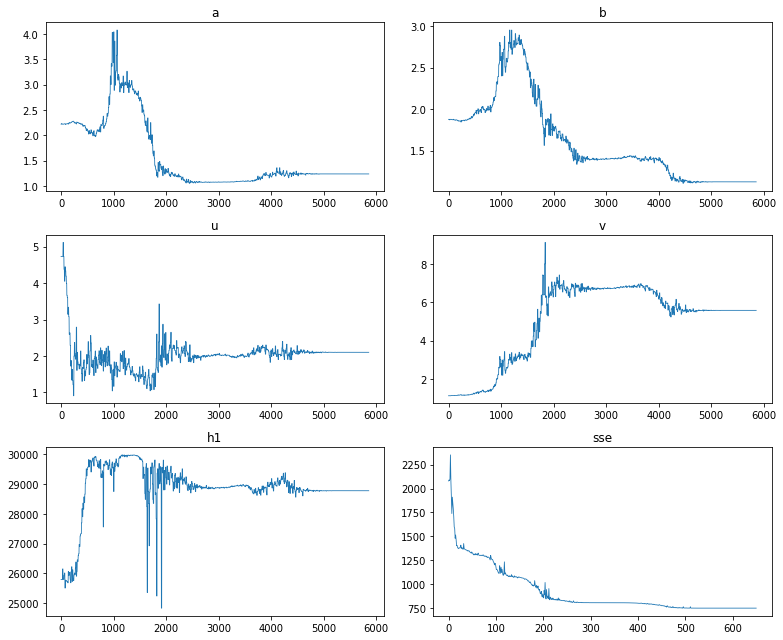

Run 67 Time: 0.98411 minutes

Avg time per run: 1.06238 minutes

Est time remaining: 33.99608 minutes

========Run 68========
{'a': 1.9119764565064958, 'b': 1.101700160844867, 'h1': 20211.751049463066, 'u': 1.2290384614592582, 'v': 6.659924865252611}
a* = -1.43613	b* = -2.08707	            h1* = 3.18091	u* = 0.74165	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.10472	u = 2.09939	v = 5.57770
Success: True, Optimization terminated successfully.
Iterations: 401
SSE: 749.9795641109762


Height  Suspended Mass
0    4430.75    2.005782e+09
1    5776.50    2.348657e+09
2    7122.25    2.567169e+09
3    8468.00    2.727184e+09
4    9813.75    2.851483e+09
5   11159.50    2.950792e+09
6   12505.25    3.030967e+09
7   13851.00    3.095454e+09
8   15196.75    3.146307e+09
9   16542.50    3.184660e+09
10  17888.25    3.210934e+09
11  19234.00    3.224880e+09
12  20579.75    3.225479e+09
13  21925.50    3.210632e+09
14  23271.25    3.176438e+09
15  24617.00    3.115400e+09
16  25962.75    3.011161e+09
17  27308.50    2.815998e+09
18  28654.25    2.100625e+09
19  30000.00    0.000000e+00

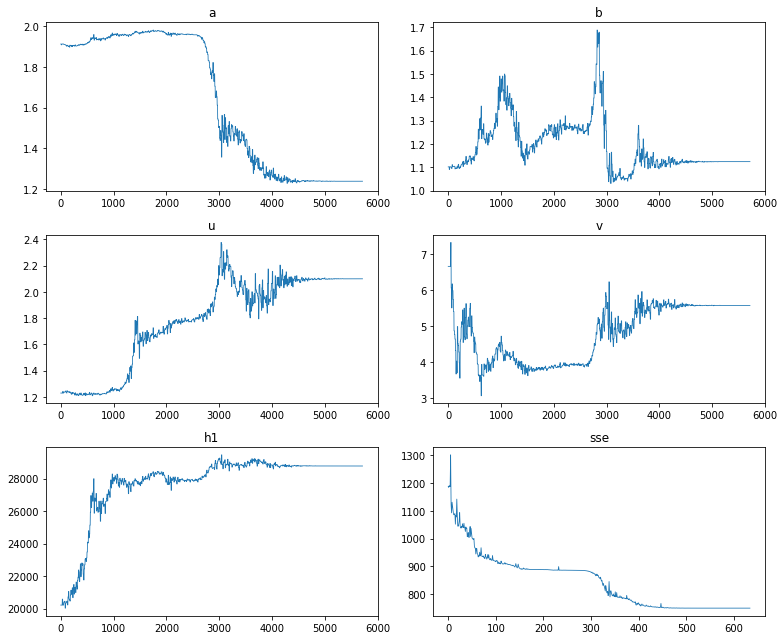

Run 68 Time: 0.96120 minutes

Avg time per run: 1.06091 minutes

Est time remaining: 32.88824 minutes

========Run 69========
{'a': 1.9800727939581049, 'b': 1.0856801034475065, 'h1': 15916.491112326112, 'u': 2.8168645669645653, 'v': 2.3873101536169954}
a* = -1.43604	b* = -2.08708	            h1* = 3.18095	u* = 0.74162	v* = 1.71877
a = 1.23787	b = 1.12405	            h1 = 28779.15100	u = 2.09933	v = 5.57768
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 631
SSE: 749.979563984577


Height  Suspended Mass
0    4430.75    2.005689e+09
1    5776.50    2.348581e+09
2    7122.25    2.567107e+09
3    8468.00    2.727134e+09
4    9813.75    2.851445e+09
5   11159.50    2.950763e+09
6   12505.25    3.030947e+09
7   13851.00    3.095442e+09
8   15196.75    3.146303e+09
9   16542.50    3.184664e+09
10  17888.25    3.210944e+09
11  19234.00    3.224896e+09
12  20579.75    3.225501e+09
13  21925.50    3.210660e+09
14  23271.25    3.176471e+09
15  24617.00    3.115439e+09
16  25962.75    3.011205e+09
17  27308.50    2.816049e+09
18  28654.25    2.100758e+09
19  30000.00    0.000000e+00

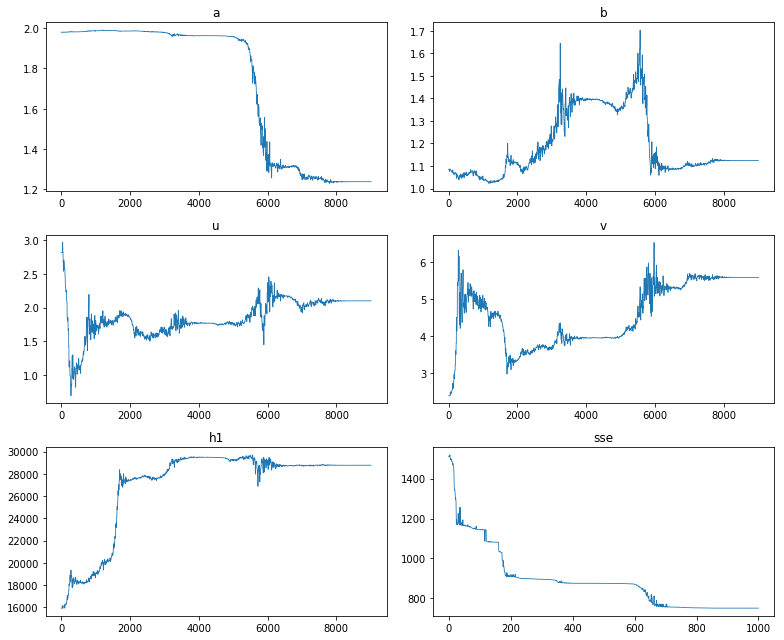

Run 69 Time: 1.52396 minutes

Avg time per run: 1.06753 minutes

Est time remaining: 32.02578 minutes

========Run 70========
{'a': 1.088811023301867, 'b': 1.5899337096315018, 'h1': 28022.798747245957, 'u': 0.7666914011022679, 'v': 1.5183635940171465}
a* = -1.43612	b* = -2.08708	            h1* = 3.18092	u* = 0.74162	v* = 1.71878
a = 1.23785	b = 1.12405	            h1 = 28779.11510	u = 2.09933	v = 5.57774
Success: True, Optimization terminated successfully.
Iterations: 341
SSE: 749.9795639090039


Height  Suspended Mass
0    4430.75    2.005764e+09
1    5776.50    2.348641e+09
2    7122.25    2.567156e+09
3    8468.00    2.727173e+09
4    9813.75    2.851474e+09
5   11159.50    2.950784e+09
6   12505.25    3.030961e+09
7   13851.00    3.095449e+09
8   15196.75    3.146304e+09
9   16542.50    3.184659e+09
10  17888.25    3.210934e+09
11  19234.00    3.224882e+09
12  20579.75    3.225482e+09
13  21925.50    3.210637e+09
14  23271.25    3.176444e+09
15  24617.00    3.115408e+09
16  25962.75    3.011172e+09
17  27308.50    2.816013e+09
18  28654.25    2.100663e+09
19  30000.00    0.000000e+00

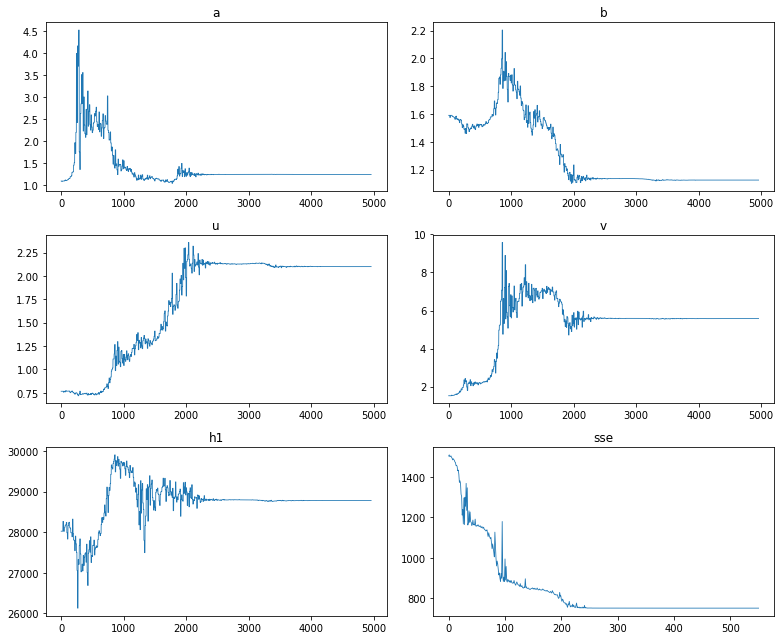

Run 70 Time: 0.83724 minutes

Avg time per run: 1.06428 minutes

Est time remaining: 30.86419 minutes

========Run 71========
{'a': 2.5414376889866257, 'b': 3.8014942675611882, 'h1': 15163.690467811248, 'u': 1.6989896774064719, 'v': 13.984333212238067}
a* = -1.51934	b* = -2.36789	            h1* = 2.51714	u* = 0.74491	v* = 1.74486
a = 1.21886	b = 1.09368	            h1 = 27674.38029	u = 2.10625	v = 5.72512
Success: True, Optimization terminated successfully.
Iterations: 593
SSE: 759.391703927323


Height  Suspended Mass
0    4430.75    2.143158e+09
1    5776.50    2.480335e+09
2    7122.25    2.694441e+09
3    8468.00    2.851394e+09
4    9813.75    2.973796e+09
5   11159.50    3.072229e+09
6   12505.25    3.152443e+09
7   13851.00    3.217804e+09
8   15196.75    3.270300e+09
9   16542.50    3.310998e+09
10  17888.25    3.340227e+09
11  19234.00    3.357589e+09
12  20579.75    3.361779e+09
13  21925.50    3.350085e+09
14  23271.25    3.317137e+09
15  24617.00    3.251307e+09
16  25962.75    3.120462e+09
17  27308.50    2.734516e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

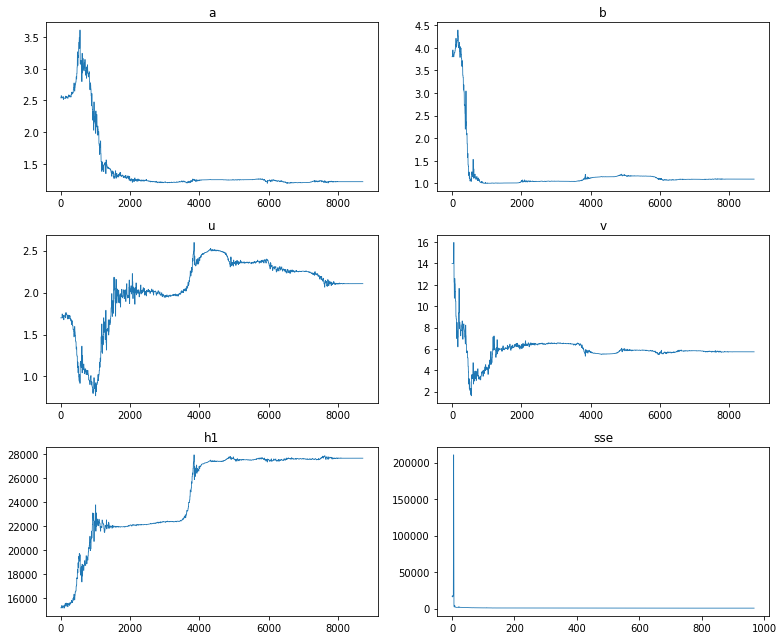

Run 71 Time: 1.47682 minutes

Avg time per run: 1.07001 minutes

Est time remaining: 29.96034 minutes

========Run 72========
{'a': 3.714954114460184, 'b': 5.567773625000343, 'h1': 24536.155043647093, 'u': 0.7713682331922503, 'v': 2.254934278333802}
a* = -1.43611	b* = -2.08718	            h1* = 3.18091	u* = 0.74164	v* = 1.71877
a = 1.23785	b = 1.12404	            h1 = 28779.10205	u = 2.09937	v = 5.57769
Success: True, Optimization terminated successfully.
Iterations: 338
SSE: 749.9795640806658


Height  Suspended Mass
0    4430.75    2.005735e+09
1    5776.50    2.348610e+09
2    7122.25    2.567125e+09
3    8468.00    2.727143e+09
4    9813.75    2.851446e+09
5   11159.50    2.950759e+09
6   12505.25    3.030938e+09
7   13851.00    3.095430e+09
8   15196.75    3.146288e+09
9   16542.50    3.184647e+09
10  17888.25    3.210927e+09
11  19234.00    3.224880e+09
12  20579.75    3.225486e+09
13  21925.50    3.210649e+09
14  23271.25    3.176464e+09
15  24617.00    3.115439e+09
16  25962.75    3.011215e+09
17  27308.50    2.816074e+09
18  28654.25    2.100746e+09
19  30000.00    0.000000e+00

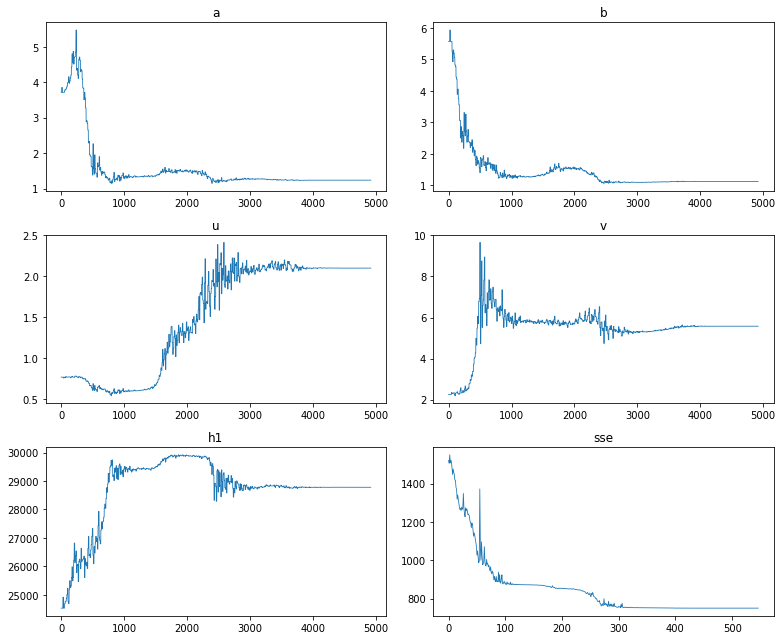

Run 72 Time: 0.82630 minutes

Avg time per run: 1.06667 minutes

Est time remaining: 28.80019 minutes

========Run 73========
{'a': 1.2775600094029604, 'b': 1.6737262631094867, 'h1': 19083.56111909054, 'u': 7.46181174290856, 'v': 0.698796562138903}
a* = -1.43610	b* = -2.08714	            h1* = 3.18094	u* = 0.74164	v* = 1.71877
a = 1.23785	b = 1.12404	            h1 = 28779.13904	u = 2.09937	v = 5.57765
Success: True, Optimization terminated successfully.
Iterations: 317
SSE: 749.9795640279087


Height  Suspended Mass
0    4430.75    2.005726e+09
1    5776.50    2.348605e+09
2    7122.25    2.567122e+09
3    8468.00    2.727142e+09
4    9813.75    2.851446e+09
5   11159.50    2.950760e+09
6   12505.25    3.030940e+09
7   13851.00    3.095431e+09
8   15196.75    3.146290e+09
9   16542.50    3.184649e+09
10  17888.25    3.210928e+09
11  19234.00    3.224880e+09
12  20579.75    3.225486e+09
13  21925.50    3.210647e+09
14  23271.25    3.176461e+09
15  24617.00    3.115433e+09
16  25962.75    3.011206e+09
17  27308.50    2.816062e+09
18  28654.25    2.100786e+09
19  30000.00    0.000000e+00

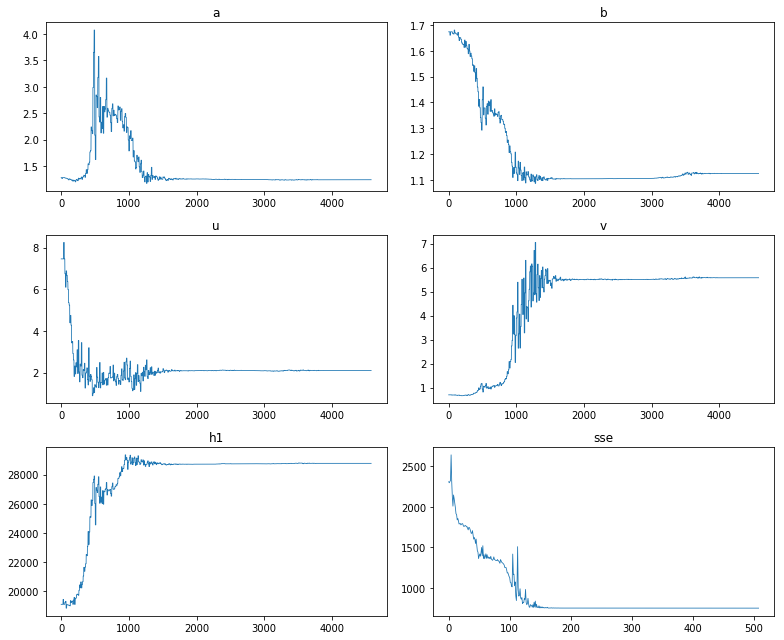

Run 73 Time: 0.77370 minutes

Avg time per run: 1.06271 minutes

Est time remaining: 27.63058 minutes

========Run 74========
{'a': 1.3184949882124113, 'b': 6.527237983385412, 'h1': 28743.062273567288, 'u': 0.8724637617327925, 'v': 1.34683008881646}
a* = -1.43679	b* = -2.08882	            h1* = 3.18108	u* = 0.74268	v* = 1.71855
a = 1.23769	b = 1.12383	            h1 = 28779.30643	u = 2.10156	v = 5.57646
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 615
SSE: 749.9799470909595


Height  Suspended Mass
0    4430.75    2.005977e+09
1    5776.50    2.348658e+09
2    7122.25    2.567039e+09
3    8468.00    2.726960e+09
4    9813.75    2.851192e+09
5   11159.50    2.950452e+09
6   12505.25    3.030597e+09
7   13851.00    3.095069e+09
8   15196.75    3.145922e+09
9   16542.50    3.184290e+09
10  17888.25    3.210594e+09
11  19234.00    3.224587e+09
12  20579.75    3.225253e+09
13  21925.50    3.210496e+09
14  23271.25    3.176422e+09
15  24617.00    3.115546e+09
16  25962.75    3.011536e+09
17  27308.50    2.816742e+09
18  28654.25    2.102668e+09
19  30000.00    0.000000e+00

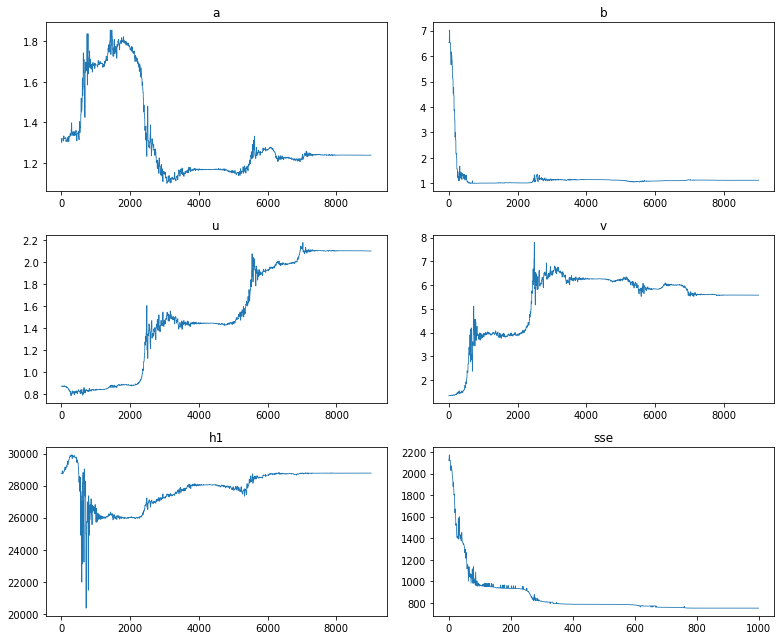

Run 74 Time: 1.51901 minutes

Avg time per run: 1.06880 minutes

Est time remaining: 26.71997 minutes

========Run 75========
{'a': 1.8586531786163856, 'b': 1.2704150362662934, 'h1': 23736.982561535267, 'u': 3.182382239237347, 'v': 1.8961187756862334}
a* = -1.43608	b* = -2.08712	            h1* = 3.18095	u* = 0.74162	v* = 1.71877
a = 1.23786	b = 1.12404	            h1 = 28779.15538	u = 2.09934	v = 5.57768
Success: True, Optimization terminated successfully.
Iterations: 373
SSE: 749.9795639645718


Height  Suspended Mass
0    4430.75    2.005714e+09
1    5776.50    2.348597e+09
2    7122.25    2.567116e+09
3    8468.00    2.727138e+09
4    9813.75    2.851444e+09
5   11159.50    2.950759e+09
6   12505.25    3.030940e+09
7   13851.00    3.095433e+09
8   15196.75    3.146292e+09
9   16542.50    3.184651e+09
10  17888.25    3.210931e+09
11  19234.00    3.224883e+09
12  20579.75    3.225489e+09
13  21925.50    3.210649e+09
14  23271.25    3.176462e+09
15  24617.00    3.115433e+09
16  25962.75    3.011205e+09
17  27308.50    2.816059e+09
18  28654.25    2.100803e+09
19  30000.00    0.000000e+00

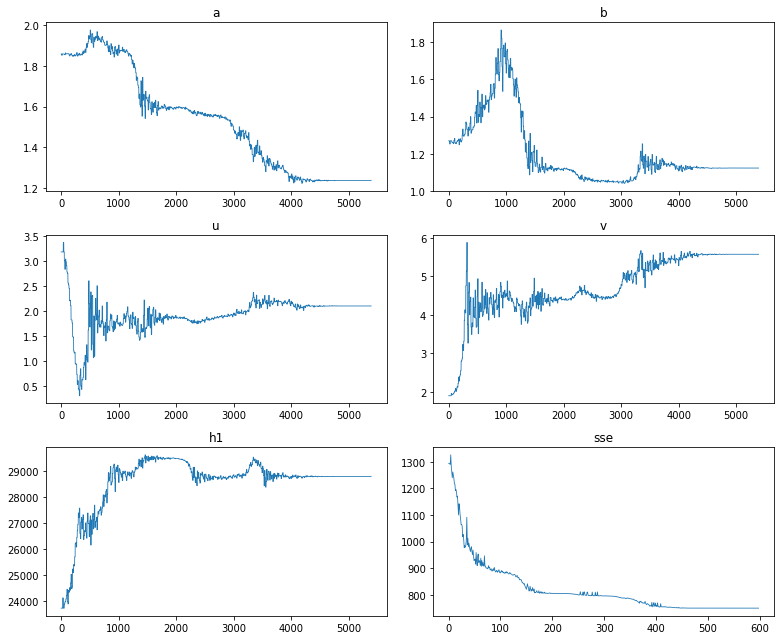

Run 75 Time: 0.90443 minutes

Avg time per run: 1.06664 minutes

Est time remaining: 25.59926 minutes

========Run 76========
{'a': 2.299408141742438, 'b': 1.1098296882020027, 'h1': 23742.815607316552, 'u': 2.416937871987039, 'v': 1.509221427620281}
a* = -1.43607	b* = -2.08706	            h1* = 3.18096	u* = 0.74163	v* = 1.71877
a = 1.23786	b = 1.12405	            h1 = 28779.15817	u = 2.09935	v = 5.57768
Success: True, Optimization terminated successfully.
Iterations: 326
SSE: 749.9795639437327


Height  Suspended Mass
0    4430.75    2.005720e+09
1    5776.50    2.348607e+09
2    7122.25    2.567129e+09
3    8468.00    2.727152e+09
4    9813.75    2.851459e+09
5   11159.50    2.950774e+09
6   12505.25    3.030955e+09
7   13851.00    3.095447e+09
8   15196.75    3.146304e+09
9   16542.50    3.184662e+09
10  17888.25    3.210940e+09
11  19234.00    3.224889e+09
12  20579.75    3.225491e+09
13  21925.50    3.210648e+09
14  23271.25    3.176456e+09
15  24617.00    3.115420e+09
16  25962.75    3.011183e+09
17  27308.50    2.816024e+09
18  28654.25    2.100739e+09
19  30000.00    0.000000e+00

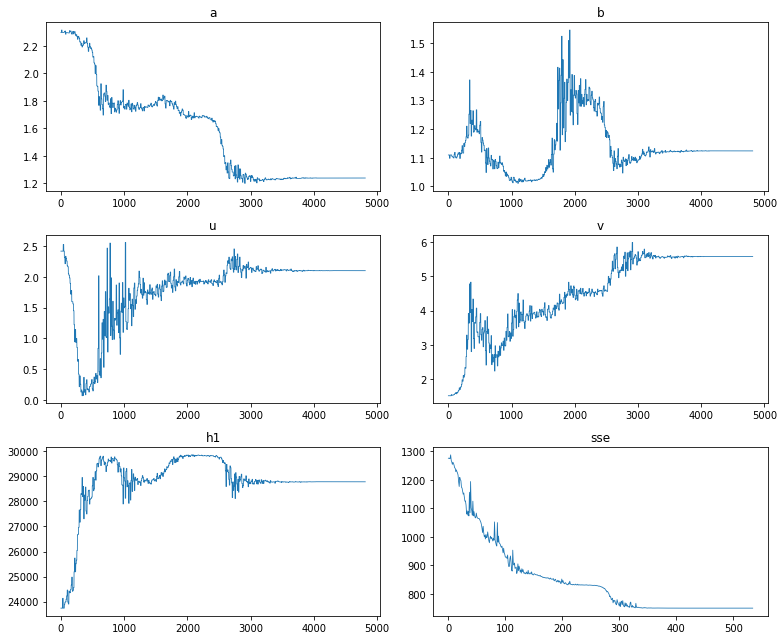

Run 76 Time: 0.81224 minutes

Avg time per run: 1.06333 minutes

Est time remaining: 24.45664 minutes

========Run 77========
{'a': 1.3594146140658225, 'b': 17.4181502851135, 'h1': 10848.85765724961, 'u': 0.944874413193326, 'v': 0.8690135598603901}
a* = 15.03941	b* = 8.72974	            h1* = -0.11036	u* = -0.58834	v* = 0.72729
a = 3400430.12956	b = 6185.10893	            h1 = 9820.91480	u = 0.55525	v = 2.06946
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 569
SSE: 1756.4015257137899


Height  Suspended Mass
0    4430.75    0.000000e+00
1    5776.50    0.000000e+00
2    7122.25    0.000000e+00
3    8468.00    0.000000e+00
4    9813.75    5.500000e+10
5   11159.50    0.000000e+00
6   12505.25    0.000000e+00
7   13851.00    0.000000e+00
8   15196.75    0.000000e+00
9   16542.50    0.000000e+00
10  17888.25    0.000000e+00
11  19234.00    0.000000e+00
12  20579.75    0.000000e+00
13  21925.50    0.000000e+00
14  23271.25    0.000000e+00
15  24617.00    0.000000e+00
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

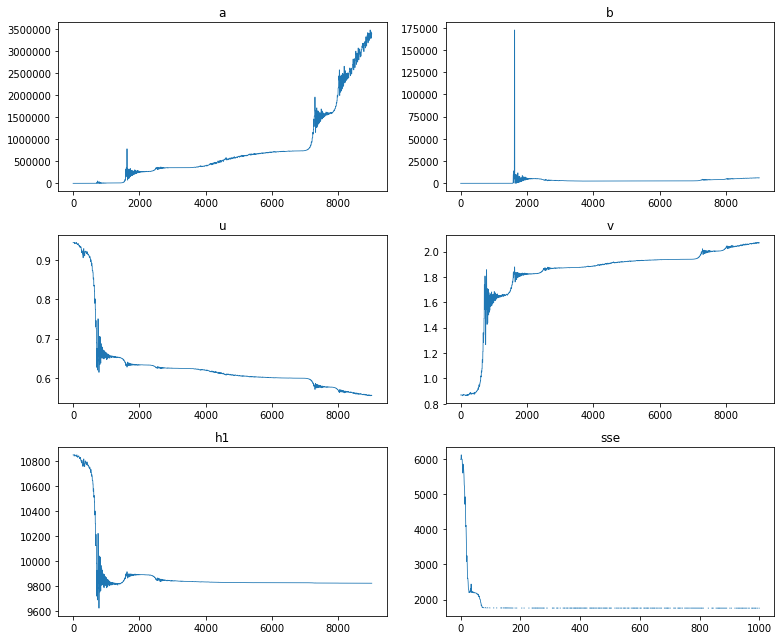

Run 77 Time: 1.50885 minutes

Avg time per run: 1.06904 minutes

Est time remaining: 23.51896 minutes

========Run 78========
{'a': 2.224298624583697, 'b': 2.605223329858909, 'h1': 23997.20584482122, 'u': 4.638336366533018, 'v': 5.478691778031862}
a* = -1.43608	b* = -2.08710	            h1* = 3.18090	u* = 0.74163	v* = 1.71877
a = 1.23786	b = 1.12405	            h1 = 28779.09002	u = 2.09936	v = 5.57768
Success: True, Optimization terminated successfully.
Iterations: 350
SSE: 749.979563995887


Height  Suspended Mass
0    4430.75    2.005720e+09
1    5776.50    2.348606e+09
2    7122.25    2.567127e+09
3    8468.00    2.727150e+09
4    9813.75    2.851457e+09
5   11159.50    2.950773e+09
6   12505.25    3.030954e+09
7   13851.00    3.095447e+09
8   15196.75    3.146305e+09
9   16542.50    3.184664e+09
10  17888.25    3.210944e+09
11  19234.00    3.224895e+09
12  20579.75    3.225499e+09
13  21925.50    3.210657e+09
14  23271.25    3.176468e+09
15  24617.00    3.115435e+09
16  25962.75    3.011201e+09
17  27308.50    2.816043e+09
18  28654.25    2.100652e+09
19  30000.00    0.000000e+00

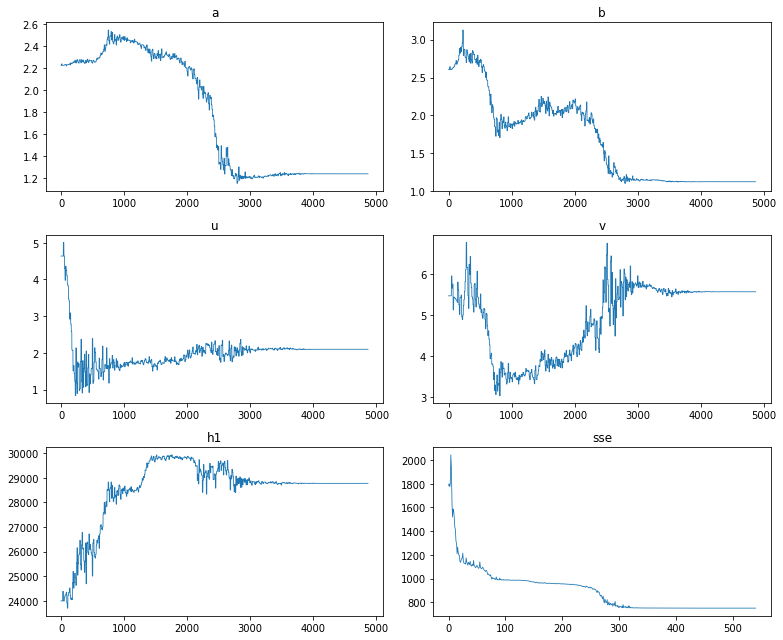

Run 78 Time: 0.82396 minutes

Avg time per run: 1.06594 minutes

Est time remaining: 22.38484 minutes

========Run 79========
{'a': 2.84637980316434, 'b': 20.452910301009968, 'h1': 18816.55069012894, 'u': 3.0715687863568326, 'v': 0.10473835417905017}
a* = -1.53302	b* = -2.51481	            h1* = 2.14590	u* = 0.74327	v* = 1.77167
a = 1.21588	b = 1.08088	            h1 = 26688.54836	u = 2.10281	v = 5.88068
Success: True, Optimization terminated successfully.
Iterations: 488
SSE: 779.3776474896625


Height  Suspended Mass
0    4430.75    2.265781e+09
1    5776.50    2.618272e+09
2    7122.25    2.842455e+09
3    8468.00    3.007204e+09
4    9813.75    3.136094e+09
5   11159.50    3.240140e+09
6   12505.25    3.325313e+09
7   13851.00    3.395083e+09
8   15196.75    3.451467e+09
9   16542.50    3.495483e+09
10  17888.25    3.527321e+09
11  19234.00    3.546284e+09
12  20579.75    3.550462e+09
13  21925.50    3.535839e+09
14  23271.25    3.493801e+09
15  24617.00    3.402257e+09
16  25962.75    3.166743e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

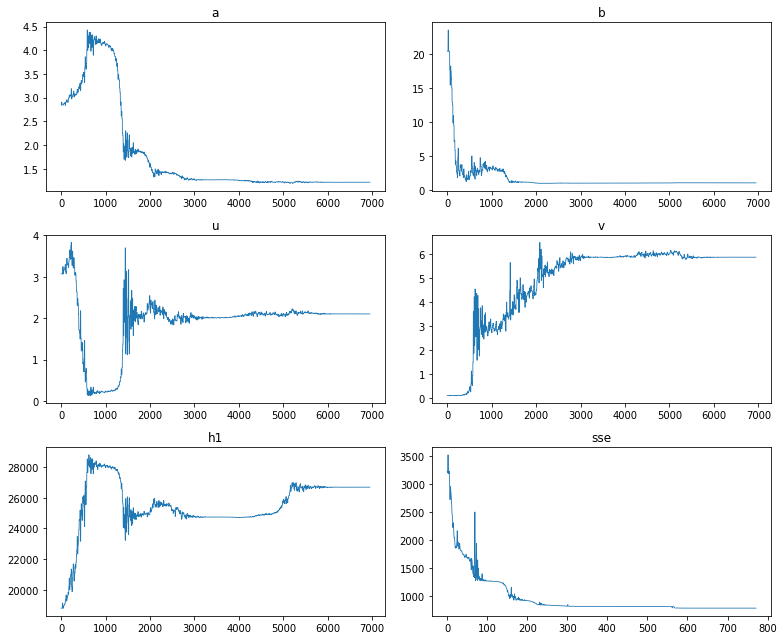

Run 79 Time: 1.16875 minutes

Avg time per run: 1.06723 minutes

Est time remaining: 21.34460 minutes

========Run 80========
{'a': 5.016472013623032, 'b': 1.6694579966887773, 'h1': 26160.3804505551, 'u': 7.359554154592955, 'v': 3.139374402505895}
a* = -1.43611	b* = -2.08712	            h1* = 3.18092	u* = 0.74164	v* = 1.71879
a = 1.23785	b = 1.12404	            h1 = 28779.11159	u = 2.09938	v = 5.57775
Success: True, Optimization terminated successfully.
Iterations: 268
SSE: 749.979564065666


Height  Suspended Mass
0    4430.75    2.005752e+09
1    5776.50    2.348629e+09
2    7122.25    2.567143e+09
3    8468.00    2.727160e+09
4    9813.75    2.851462e+09
5   11159.50    2.950774e+09
6   12505.25    3.030952e+09
7   13851.00    3.095441e+09
8   15196.75    3.146297e+09
9   16542.50    3.184654e+09
10  17888.25    3.210931e+09
11  19234.00    3.224881e+09
12  20579.75    3.225483e+09
13  21925.50    3.210642e+09
14  23271.25    3.176452e+09
15  24617.00    3.115421e+09
16  25962.75    3.011189e+09
17  27308.50    2.816037e+09
18  28654.25    2.100700e+09
19  30000.00    0.000000e+00

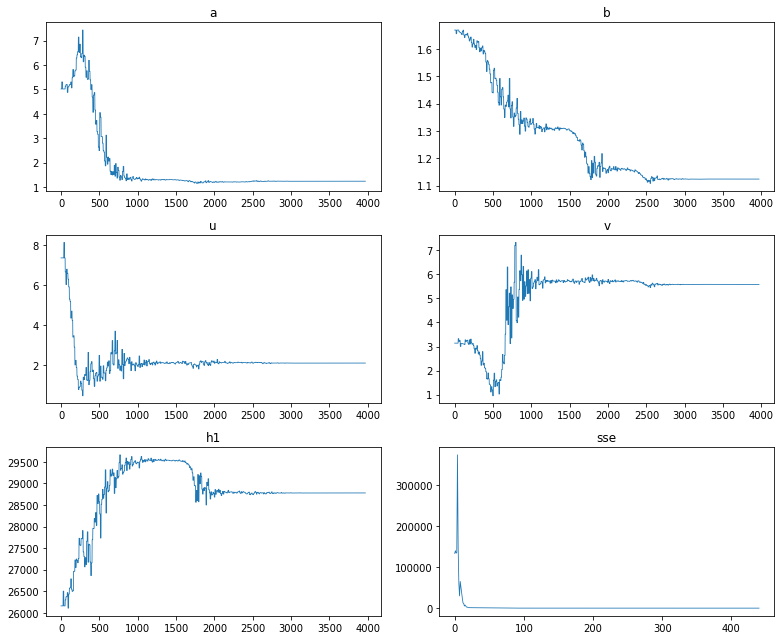

Run 80 Time: 0.67057 minutes

Avg time per run: 1.06233 minutes

Est time remaining: 20.18432 minutes

========Run 81========
{'a': 1.97748610542022, 'b': 5.249953321279086, 'h1': 25500.933381110168, 'u': 5.44851013025125, 'v': 9.57614622213608}
a* = -1.43608	b* = -2.08705	            h1* = 3.18093	u* = 0.74161	v* = 1.71878
a = 1.23786	b = 1.12405	            h1 = 28779.13031	u = 2.09931	v = 5.57772
Success: True, Optimization terminated successfully.
Iterations: 365
SSE: 749.979563965887


Height  Suspended Mass
0    4430.75    2.005730e+09
1    5776.50    2.348617e+09
2    7122.25    2.567138e+09
3    8468.00    2.727160e+09
4    9813.75    2.851466e+09
5   11159.50    2.950781e+09
6   12505.25    3.030961e+09
7   13851.00    3.095452e+09
8   15196.75    3.146309e+09
9   16542.50    3.184666e+09
10  17888.25    3.210943e+09
11  19234.00    3.224892e+09
12  20579.75    3.225493e+09
13  21925.50    3.210648e+09
14  23271.25    3.176455e+09
15  24617.00    3.115418e+09
16  25962.75    3.011179e+09
17  27308.50    2.816016e+09
18  28654.25    2.100676e+09
19  30000.00    0.000000e+00

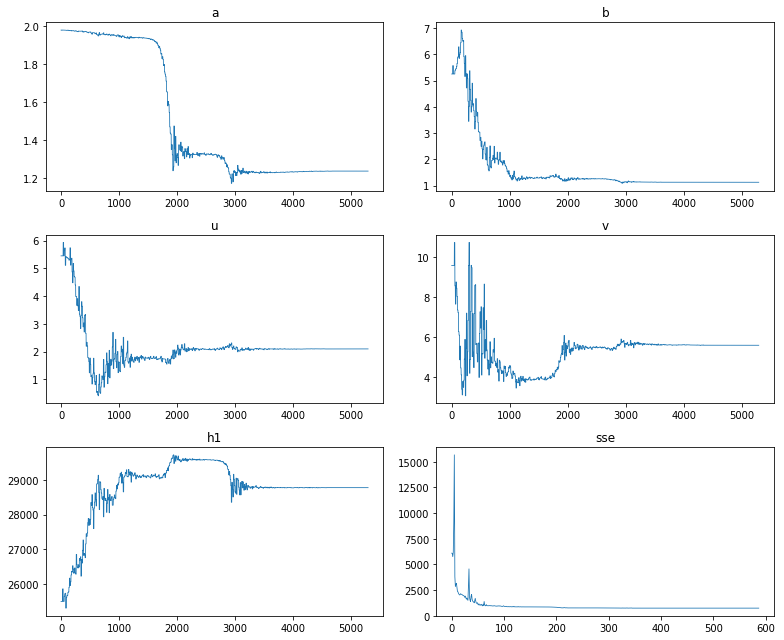

Run 81 Time: 0.89089 minutes

Avg time per run: 1.06024 minutes

Est time remaining: 19.08436 minutes

========Run 82========
{'a': 1.052769719960347, 'b': 2.3097052007079792, 'h1': 27919.742054195405, 'u': 0.3705421511580264, 'v': 1.0005874603563414}
a* = -1.42907	b* = -2.10587	            h1* = 3.13566	u* = 0.71983	v* = 1.72063
a = 1.23953	b = 1.12174	            h1 = 28723.80518	u = 2.05409	v = 5.58806
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 644
SSE: 750.3356389517987


Height  Suspended Mass
0    4430.75    2.000296e+09
1    5776.50    2.345239e+09
2    7122.25    2.565494e+09
3    8468.00    2.727074e+09
4    9813.75    2.852825e+09
5   11159.50    2.953509e+09
6   12505.25    3.035006e+09
7   13851.00    3.100778e+09
8   15196.75    3.152891e+09
9   16542.50    3.192486e+09
10  17888.25    3.219988e+09
11  19234.00    3.235149e+09
12  20579.75    3.236946e+09
13  21925.50    3.223261e+09
14  23271.25    3.190141e+09
15  24617.00    3.129954e+09
16  25962.75    3.025891e+09
17  27308.50    2.827922e+09
18  28654.25    1.985152e+09
19  30000.00    0.000000e+00

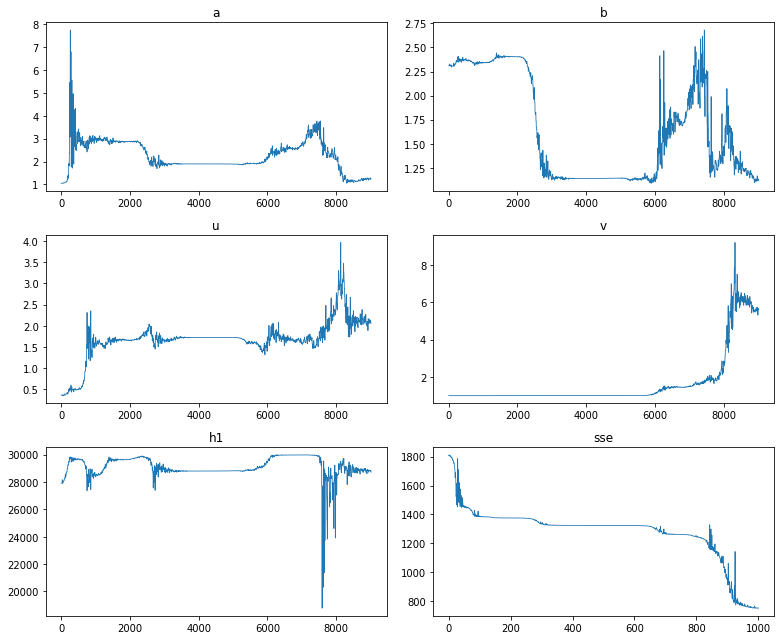

Run 82 Time: 1.50677 minutes

Avg time per run: 1.06562 minutes

Est time remaining: 18.11557 minutes

========Run 83========
{'a': 1.3462348782328288, 'b': 1.056121634141362, 'h1': 13931.793957427273, 'u': 2.4555622477474097, 'v': 8.005186509593052}
a* = -1.53304	b* = -2.51477	            h1* = 2.14587	u* = 0.74327	v* = 1.77168
a = 1.21588	b = 1.08088	            h1 = 26688.45509	u = 2.10280	v = 5.88074
Success: True, Optimization terminated successfully.
Iterations: 534
SSE: 779.377647514891


Height  Suspended Mass
0    4430.75    2.265818e+09
1    5776.50    2.618304e+09
2    7122.25    2.842482e+09
3    8468.00    3.007227e+09
4    9813.75    3.136113e+09
5   11159.50    3.240155e+09
6   12505.25    3.325324e+09
7   13851.00    3.395091e+09
8   15196.75    3.451470e+09
9   16542.50    3.495483e+09
10  17888.25    3.527317e+09
11  19234.00    3.546276e+09
12  20579.75    3.550449e+09
13  21925.50    3.535820e+09
14  23271.25    3.493776e+09
15  24617.00    3.402221e+09
16  25962.75    3.166676e+09
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

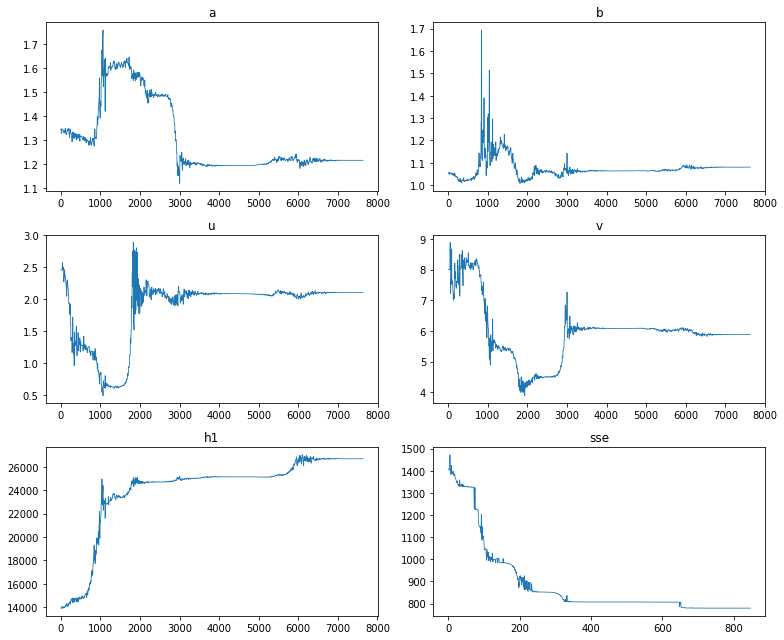

Run 83 Time: 1.29010 minutes

Avg time per run: 1.06829 minutes

Est time remaining: 17.09271 minutes

========Run 84========
{'a': 1.5050310571980123, 'b': 5.441481602475896, 'h1': 14103.936938340452, 'u': 1.2031786949394494, 'v': 0.0570590196749822}
a* = -1.21805	b* = -3.38092	            h1* = 1.39160	u* = 0.76989	v* = 1.78134
a = 1.29581	b = 1.03402	            h1 = 23394.93554	u = 2.15952	v = 5.93779
Success: True, Optimization terminated successfully.
Iterations: 334
SSE: 845.631701422991


Height  Suspended Mass
0    4430.75    2.157423e+09
1    5776.50    2.641770e+09
2    7122.25    2.970369e+09
3    8468.00    3.224727e+09
4    9813.75    3.433712e+09
5   11159.50    3.611144e+09
6   12505.25    3.764669e+09
7   13851.00    3.898815e+09
8   15196.75    4.016229e+09
9   16542.50    4.118177e+09
10  17888.25    4.204548e+09
11  19234.00    4.273244e+09
12  20579.75    4.317860e+09
13  21925.50    4.317023e+09
14  23271.25    4.050290e+09
15  24617.00    0.000000e+00
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

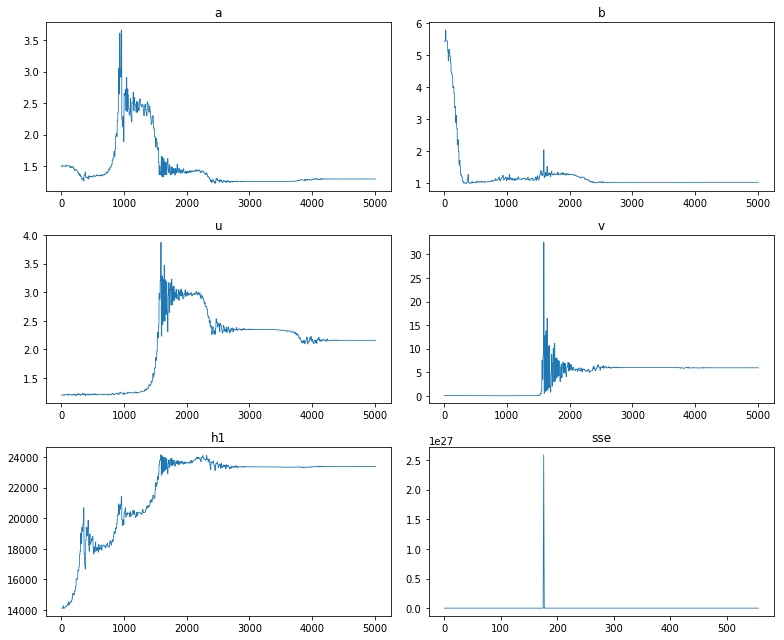

Run 84 Time: 0.84557 minutes

Avg time per run: 1.06567 minutes

Est time remaining: 15.98511 minutes

========Run 85========
{'a': 1.0305222877430518, 'b': 4.40845138874765, 'h1': 23768.937894452058, 'u': 4.7560615765450756, 'v': 3.9410419548107214}
a* = -1.43611	b* = -2.08711	            h1* = 3.18091	u* = 0.74162	v* = 1.71879
a = 1.23785	b = 1.12405	            h1 = 28779.09904	u = 2.09933	v = 5.57777
Success: True, Optimization terminated successfully.
Iterations: 259
SSE: 749.9795640546965


Height  Suspended Mass
0    4430.75    2.005751e+09
1    5776.50    2.348630e+09
2    7122.25    2.567145e+09
3    8468.00    2.727164e+09
4    9813.75    2.851466e+09
5   11159.50    2.950778e+09
6   12505.25    3.030956e+09
7   13851.00    3.095446e+09
8   15196.75    3.146302e+09
9   16542.50    3.184658e+09
10  17888.25    3.210936e+09
11  19234.00    3.224885e+09
12  20579.75    3.225487e+09
13  21925.50    3.210644e+09
14  23271.25    3.176454e+09
15  24617.00    3.115420e+09
16  25962.75    3.011186e+09
17  27308.50    2.816030e+09
18  28654.25    2.100661e+09
19  30000.00    0.000000e+00

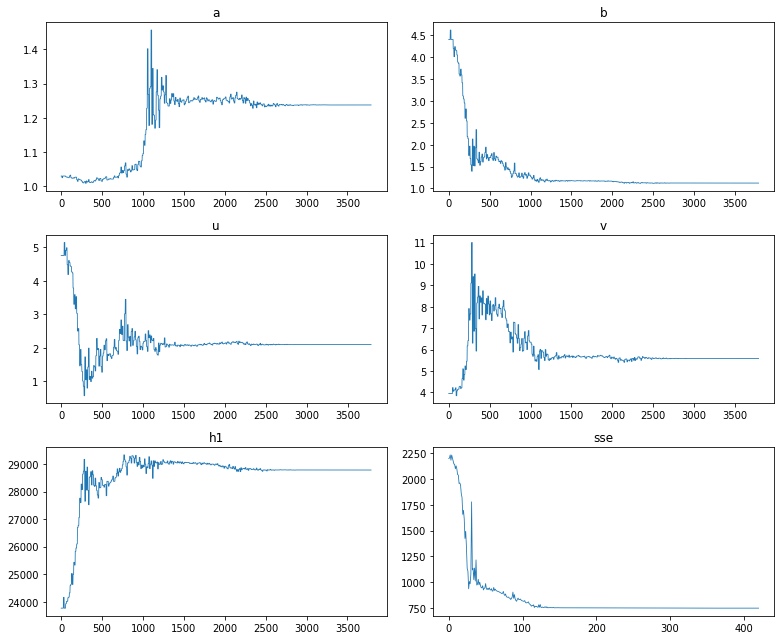

Run 85 Time: 0.64010 minutes

Avg time per run: 1.06073 minutes

Est time remaining: 14.85016 minutes

========Run 86========
{'a': 1.1115616157998358, 'b': 1.4944348745765046, 'h1': 14446.456690028372, 'u': 0.43939148036632125, 'v': 3.1059759403155223}
a* = -1.51932	b* = -2.36786	            h1* = 2.51715	u* = 0.74492	v* = 1.74486
a = 1.21886	b = 1.09368	            h1 = 27674.40345	u = 2.10626	v = 5.72511
Success: True, Optimization terminated successfully.
Iterations: 427
SSE: 759.3917039175857


Height  Suspended Mass
0    4430.75    2.143148e+09
1    5776.50    2.480328e+09
2    7122.25    2.694437e+09
3    8468.00    2.851392e+09
4    9813.75    2.973796e+09
5   11159.50    3.072230e+09
6   12505.25    3.152445e+09
7   13851.00    3.217807e+09
8   15196.75    3.270304e+09
9   16542.50    3.311002e+09
10  17888.25    3.340231e+09
11  19234.00    3.357593e+09
12  20579.75    3.361782e+09
13  21925.50    3.350087e+09
14  23271.25    3.317138e+09
15  24617.00    3.251306e+09
16  25962.75    3.120459e+09
17  27308.50    2.734516e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

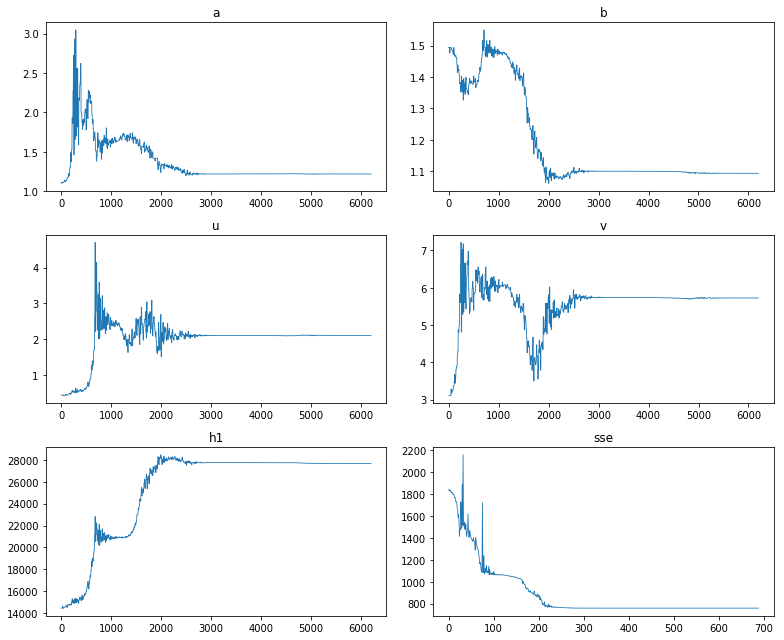

Run 86 Time: 1.05573 minutes

Avg time per run: 1.06067 minutes

Est time remaining: 13.78869 minutes

========Run 87========
{'a': 1.0046613656621919, 'b': 1.2531673156433696, 'h1': 23780.921763242783, 'u': 4.508807295880344, 'v': 0.14680818997714118}
a* = -1.43606	b* = -2.08715	            h1* = 3.18094	u* = 0.74162	v* = 1.71877
a = 1.23786	b = 1.12404	            h1 = 28779.13852	u = 2.09933	v = 5.57767
Success: True, Optimization terminated successfully.
Iterations: 576
SSE: 749.9795639913939


Height  Suspended Mass
0    4430.75    2.005691e+09
1    5776.50    2.348577e+09
2    7122.25    2.567099e+09
3    8468.00    2.727124e+09
4    9813.75    2.851432e+09
5   11159.50    2.950750e+09
6   12505.25    3.030934e+09
7   13851.00    3.095428e+09
8   15196.75    3.146290e+09
9   16542.50    3.184652e+09
10  17888.25    3.210934e+09
11  19234.00    3.224889e+09
12  20579.75    3.225497e+09
13  21925.50    3.210660e+09
14  23271.25    3.176476e+09
15  24617.00    3.115450e+09
16  25962.75    3.011226e+09
17  27308.50    2.816084e+09
18  28654.25    2.100807e+09
19  30000.00    0.000000e+00

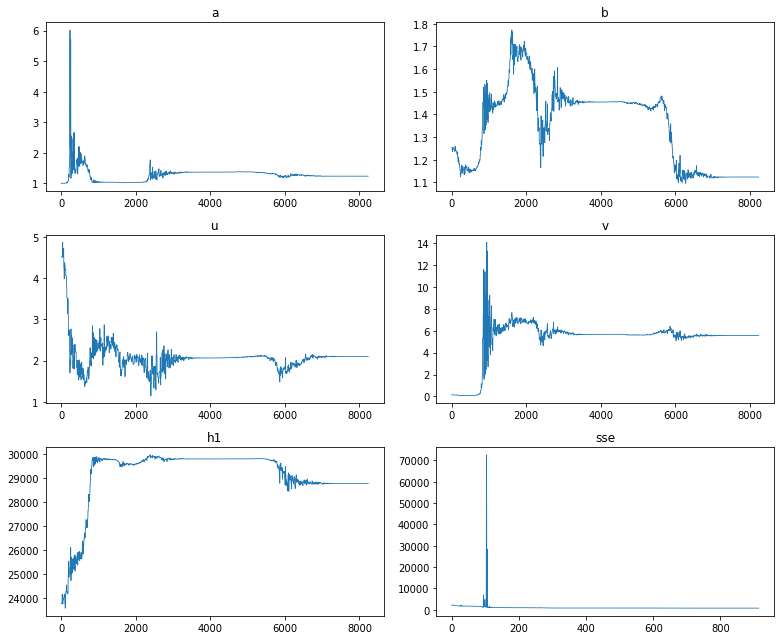

Run 87 Time: 1.38620 minutes

Avg time per run: 1.06437 minutes

Est time remaining: 12.77241 minutes

========Run 88========
{'a': 2.409040745948306, 'b': 5.423836483172581, 'h1': 27455.784833434835, 'u': 5.488782160981883, 'v': 1.2931288256042635}
a* = -1.04894	b* = -1.99853	            h1* = 3.65236	u* = 0.71548	v* = 1.69350
a = 1.35031	b = 1.13553	            h1 = 29232.10541	u = 2.04517	v = 5.43847
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 628
SSE: 762.7676134319006


Height  Suspended Mass
0    4430.75    1.570213e+09
1    5776.50    1.986680e+09
2    7122.25    2.271623e+09
3    8468.00    2.491190e+09
4    9813.75    2.669384e+09
5   11159.50    2.817872e+09
6   12505.25    2.943190e+09
7   13851.00    3.049273e+09
8   15196.75    3.138528e+09
9   16542.50    3.212345e+09
10  17888.25    3.271323e+09
11  19234.00    3.315339e+09
12  20579.75    3.343460e+09
13  21925.50    3.353666e+09
14  23271.25    3.342212e+09
15  24617.00    3.302107e+09
16  25962.75    3.219009e+09
17  27308.50    3.056315e+09
18  28654.25    2.646272e+09
19  30000.00    0.000000e+00

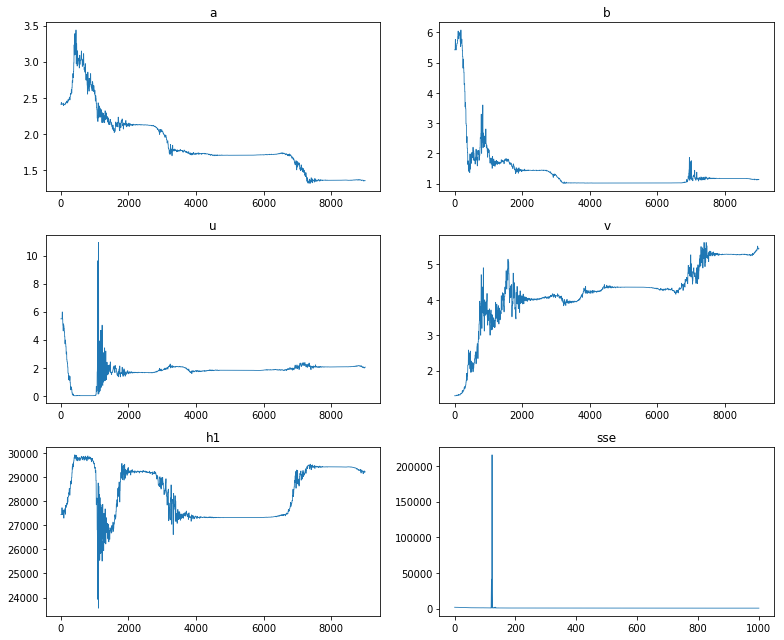

Run 88 Time: 1.52109 minutes

Avg time per run: 1.06950 minutes

Est time remaining: 11.76449 minutes

========Run 89========
{'a': 1.1429312905844793, 'b': 7.642927256331293, 'h1': 25283.590067714038, 'u': 6.012506260515233, 'v': 2.990383677304205}
a* = -1.51932	b* = -2.36785	            h1* = 2.51714	u* = 0.74491	v* = 1.74486
a = 1.21886	b = 1.09368	            h1 = 27674.38719	u = 2.10625	v = 5.72510
Success: True, Optimization terminated successfully.
Iterations: 335
SSE: 759.3917039122093


Height  Suspended Mass
0    4430.75    2.143150e+09
1    5776.50    2.480331e+09
2    7122.25    2.694440e+09
3    8468.00    2.851395e+09
4    9813.75    2.973799e+09
5   11159.50    3.072233e+09
6   12505.25    3.152448e+09
7   13851.00    3.217809e+09
8   15196.75    3.270306e+09
9   16542.50    3.311004e+09
10  17888.25    3.340233e+09
11  19234.00    3.357594e+09
12  20579.75    3.361782e+09
13  21925.50    3.350086e+09
14  23271.25    3.317137e+09
15  24617.00    3.251302e+09
16  25962.75    3.120452e+09
17  27308.50    2.734496e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

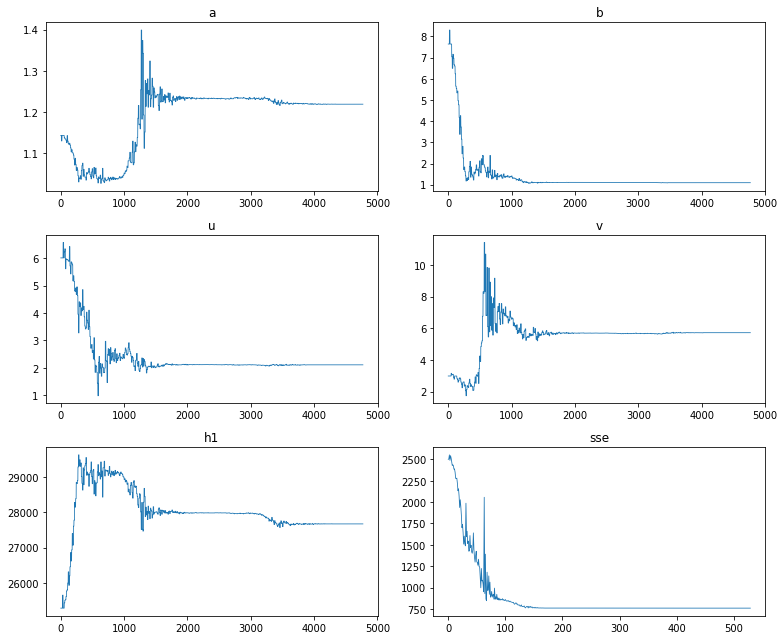

Run 89 Time: 0.80286 minutes

Avg time per run: 1.06654 minutes

Est time remaining: 10.66536 minutes

========Run 90========
{'a': 2.2574763308377506, 'b': 4.483754211739493, 'h1': 11970.758955931806, 'u': 3.0325270400293234, 'v': 3.3706607906194574}
a* = -1.51977	b* = -2.59888	            h1* = 1.89682	u* = 0.73676	v* = 1.80020
a = 1.21876	b = 1.07436	            h1 = 25820.09192	u = 2.08915	v = 6.05084
Success: True, Optimization terminated successfully.
Iterations: 435
SSE: 806.1631952756165


Height  Suspended Mass
0    4430.75    2.393549e+09
1    5776.50    2.772030e+09
2    7122.25    3.013531e+09
3    8468.00    3.191505e+09
4    9813.75    3.331109e+09
5   11159.50    3.444092e+09
6   12505.25    3.536804e+09
7   13851.00    3.612906e+09
8   15196.75    3.674474e+09
9   16542.50    3.722470e+09
10  17888.25    3.756865e+09
11  19234.00    3.776490e+09
12  20579.75    3.778433e+09
13  21925.50    3.756368e+09
14  23271.25    3.695154e+09
15  24617.00    3.544220e+09
16  25962.75    0.000000e+00
17  27308.50    0.000000e+00
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

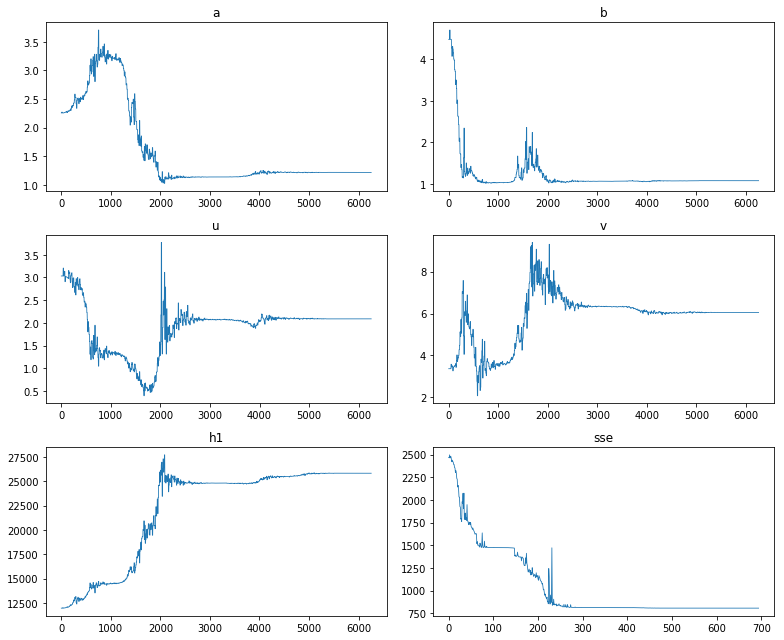

Run 90 Time: 1.05365 minutes

Avg time per run: 1.06639 minutes

Est time remaining: 9.59755 minutes

========Run 91========
{'a': 1.0664688336440604, 'b': 8.5178194551625, 'h1': 26943.308822357598, 'u': 1.8431762596840846, 'v': 4.509216795402782}
a* = -1.43613	b* = -2.08710	            h1* = 3.18091	u* = 0.74162	v* = 1.71879
a = 1.23785	b = 1.12405	            h1 = 28779.09974	u = 2.09934	v = 5.57775
Success: True, Optimization terminated successfully.
Iterations: 245
SSE: 749.9795639681785


Height  Suspended Mass
0    4430.75    2.005774e+09
1    5776.50    2.348648e+09
2    7122.25    2.567160e+09
3    8468.00    2.727176e+09
4    9813.75    2.851476e+09
5   11159.50    2.950785e+09
6   12505.25    3.030961e+09
7   13851.00    3.095448e+09
8   15196.75    3.146302e+09
9   16542.50    3.184657e+09
10  17888.25    3.210932e+09
11  19234.00    3.224880e+09
12  20579.75    3.225480e+09
13  21925.50    3.210636e+09
14  23271.25    3.176443e+09
15  24617.00    3.115408e+09
16  25962.75    3.011173e+09
17  27308.50    2.816015e+09
18  28654.25    2.100645e+09
19  30000.00    0.000000e+00

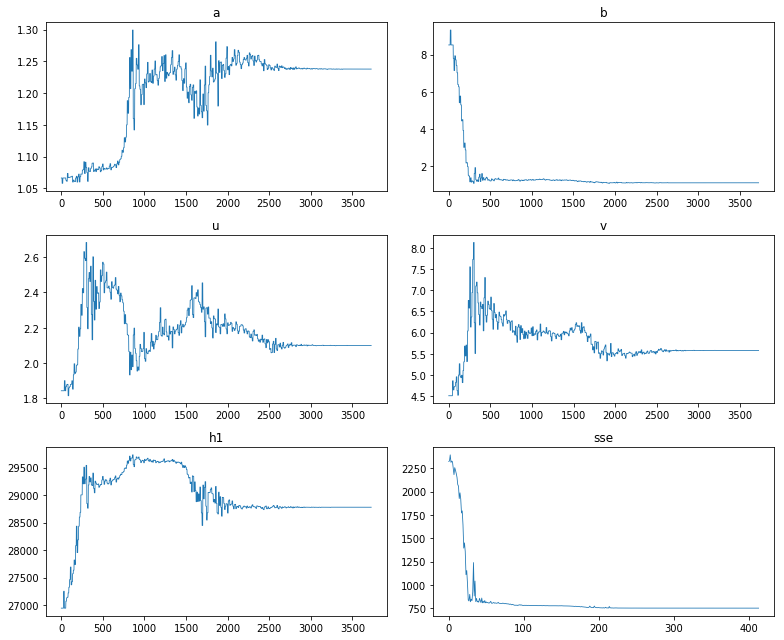

Run 91 Time: 0.62917 minutes

Avg time per run: 1.06164 minutes

Est time remaining: 8.49314 minutes

========Run 92========
{'a': 2.222019624775892, 'b': 1.3125136589903448, 'h1': 25467.106015418227, 'u': 1.044747729986679, 'v': 4.422636768150897}
a* = -1.43610	b* = -2.08712	            h1* = 3.18091	u* = 0.74162	v* = 1.71878
a = 1.23785	b = 1.12404	            h1 = 28779.10031	u = 2.09933	v = 5.57769
Success: True, Optimization terminated successfully.
Iterations: 528
SSE: 749.9795639244362


Height  Suspended Mass
0    4430.75    2.005740e+09
1    5776.50    2.348620e+09
2    7122.25    2.567136e+09
3    8468.00    2.727156e+09
4    9813.75    2.851460e+09
5   11159.50    2.950772e+09
6   12505.25    3.030952e+09
7   13851.00    3.095442e+09
8   15196.75    3.146299e+09
9   16542.50    3.184657e+09
10  17888.25    3.210936e+09
11  19234.00    3.224886e+09
12  20579.75    3.225489e+09
13  21925.50    3.210648e+09
14  23271.25    3.176459e+09
15  24617.00    3.115427e+09
16  25962.75    3.011196e+09
17  27308.50    2.816042e+09
18  28654.25    2.100682e+09
19  30000.00    0.000000e+00

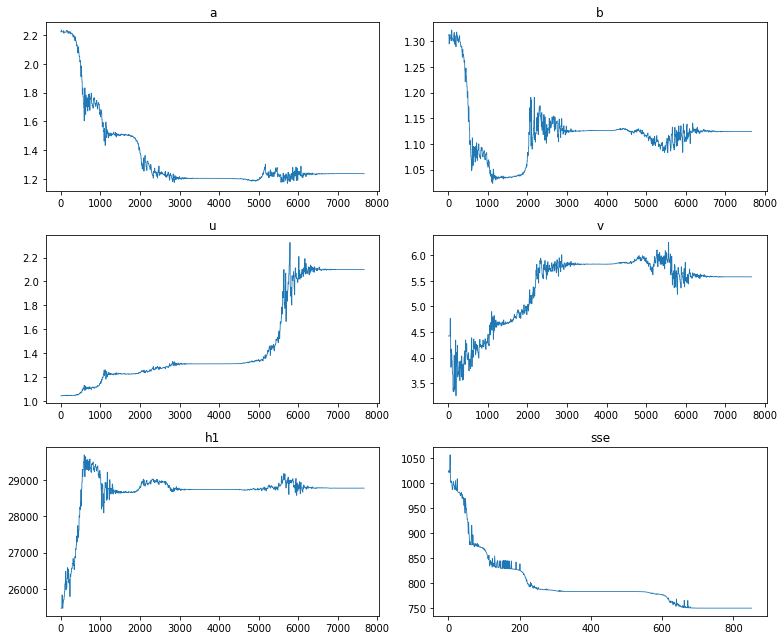

Run 92 Time: 1.29453 minutes

Avg time per run: 1.06415 minutes

Est time remaining: 7.44903 minutes

========Run 93========
{'a': 1.130397642092807, 'b': 1.9974425663521296, 'h1': 15789.524449818517, 'u': 0.8891025973910931, 'v': 0.2296749995627172}
a* = -1.43613	b* = -2.08697	            h1* = 3.18090	u* = 0.74165	v* = 1.71881
a = 1.23785	b = 1.12406	            h1 = 28779.09615	u = 2.09939	v = 5.57791
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 616
SSE: 749.9795653393103


Height  Suspended Mass
0    4430.75    2.005811e+09
1    5776.50    2.348689e+09
2    7122.25    2.567202e+09
3    8468.00    2.727216e+09
4    9813.75    2.851515e+09
5   11159.50    2.950821e+09
6   12505.25    3.030994e+09
7   13851.00    3.095478e+09
8   15196.75    3.146327e+09
9   16542.50    3.184676e+09
10  17888.25    3.210946e+09
11  19234.00    3.224886e+09
12  20579.75    3.225478e+09
13  21925.50    3.210624e+09
14  23271.25    3.176421e+09
15  24617.00    3.115372e+09
16  25962.75    3.011118e+09
17  27308.50    2.815933e+09
18  28654.25    2.100493e+09
19  30000.00    0.000000e+00

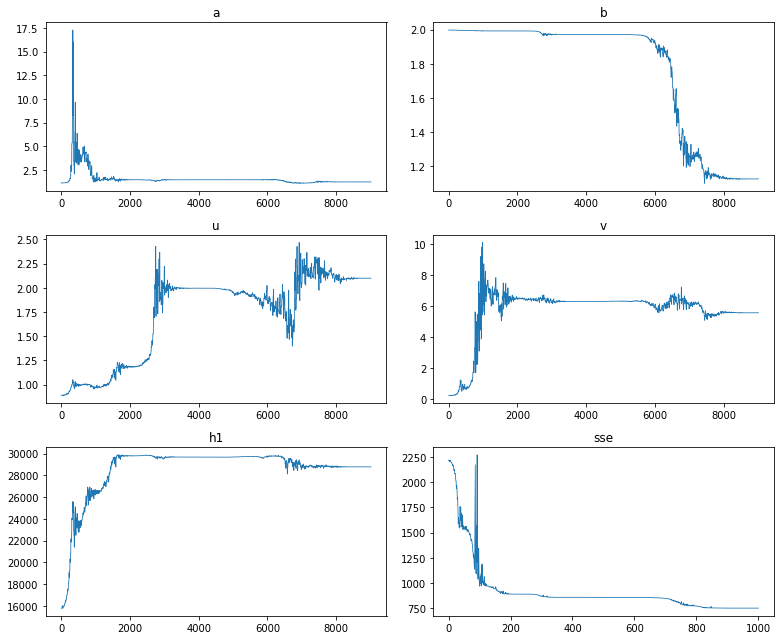

Run 93 Time: 1.51276 minutes

Avg time per run: 1.06892 minutes

Est time remaining: 6.41351 minutes

========Run 94========
{'a': 1.4267828604358685, 'b': 1.3037284872587183, 'h1': 18783.335484722542, 'u': 5.247553336659392, 'v': 1.5100150632710008}
a* = -1.42262	b* = -1.76638	            h1* = 3.18942	u* = -14.42406	v* = 1.75283
a = 1.24108	b = 1.17095	            h1 = 28789.24265	u = 0.00000	v = 5.77088
Success: True, Optimization terminated successfully.
Iterations: 244
SSE: 956.3326255489034


Height  Suspended Mass
0    4430.75    2.089642e+09
1    5776.50    2.445825e+09
2    7122.25    2.669341e+09
3    8468.00    2.829853e+09
4    9813.75    2.951481e+09
5   11159.50    3.045565e+09
6   12505.25    3.118259e+09
7   13851.00    3.173138e+09
8   15196.75    3.212269e+09
9   16542.50    3.236702e+09
10  17888.25    3.246680e+09
11  19234.00    3.241657e+09
12  20579.75    3.220161e+09
13  21925.50    3.179394e+09
14  23271.25    3.114334e+09
15  24617.00    3.015553e+09
16  25962.75    2.862878e+09
17  27308.50    2.598901e+09
18  28654.25    1.748367e+09
19  30000.00    0.000000e+00

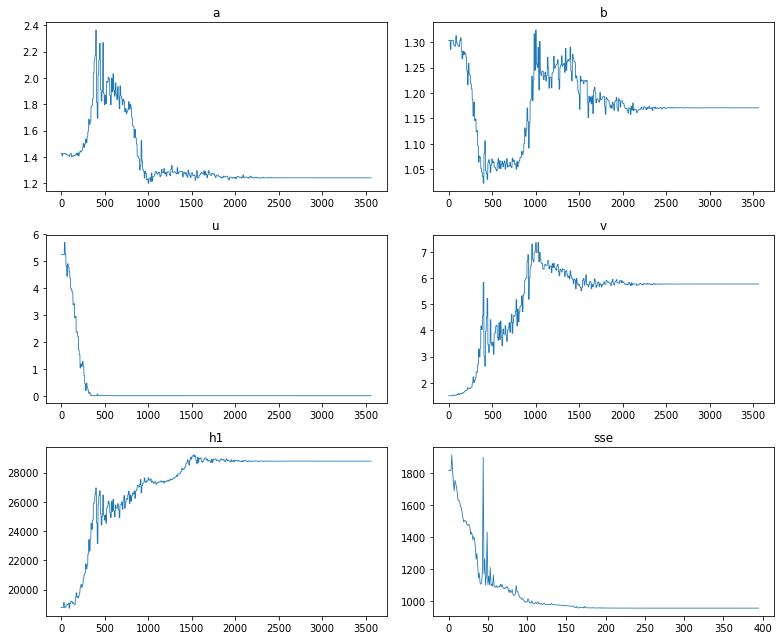

Run 94 Time: 0.60000 minutes

Avg time per run: 1.06398 minutes

Est time remaining: 5.31992 minutes

========Run 95========
{'a': 1.9679307551578338, 'b': 2.914891147909734, 'h1': 18951.496603261483, 'u': 0.5364613126219024, 'v': 1.490113147025878}
a* = -0.91622	b* = -3.26821	            h1* = 2.78455	u* = 0.70861	v* = 1.46554
a = 1.40003	b = 1.03807	            h1 = 28203.34836	u = 2.03116	v = 4.32990
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 626
SSE: 804.2223462462316


Height  Suspended Mass
0    4430.75    1.358808e+09
1    5776.50    1.789019e+09
2    7122.25    2.099100e+09
3    8468.00    2.349207e+09
4    9813.75    2.561652e+09
5   11159.50    2.747503e+09
6   12505.25    2.913122e+09
7   13851.00    3.062493e+09
8   15196.75    3.198229e+09
9   16542.50    3.322062e+09
10  17888.25    3.435091e+09
11  19234.00    3.537880e+09
12  20579.75    3.630453e+09
13  21925.50    3.712137e+09
14  23271.25    3.781123e+09
15  24617.00    3.833225e+09
16  25962.75    3.857611e+09
17  27308.50    3.811285e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

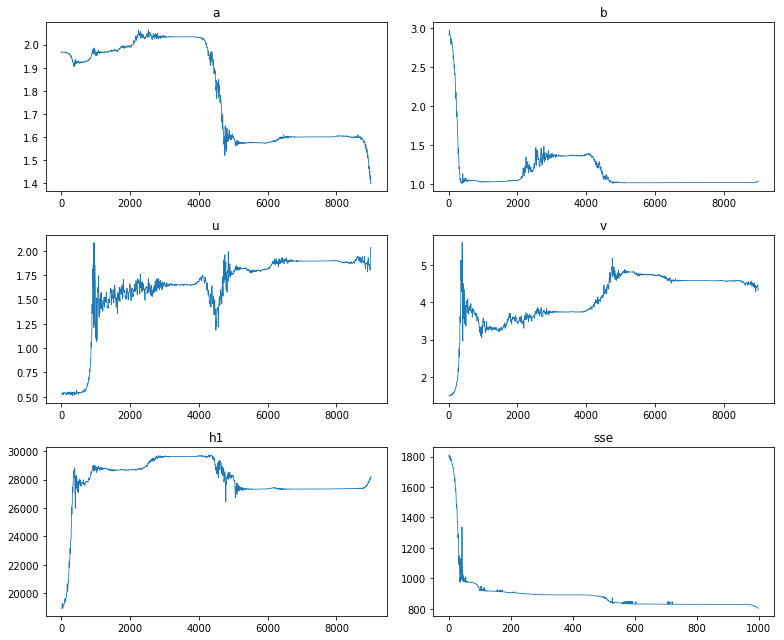

Run 95 Time: 1.51484 minutes

Avg time per run: 1.06868 minutes

Est time remaining: 4.27472 minutes

========Run 96========
{'a': 3.299141802637982, 'b': 2.260359512758753, 'h1': 28363.012860308503, 'u': 14.904657283825163, 'v': 2.5516163995859293}
a* = -1.43614	b* = -2.08713	            h1* = 3.18092	u* = 0.74160	v* = 1.71879
a = 1.23784	b = 1.12404	            h1 = 28779.12119	u = 2.09930	v = 5.57778
Success: True, Optimization terminated successfully.
Iterations: 340
SSE: 749.9795641580286


Height  Suspended Mass
0    4430.75    2.005774e+09
1    5776.50    2.348645e+09
2    7122.25    2.567155e+09
3    8468.00    2.727168e+09
4    9813.75    2.851467e+09
5   11159.50    2.950776e+09
6   12505.25    3.030951e+09
7   13851.00    3.095438e+09
8   15196.75    3.146292e+09
9   16542.50    3.184648e+09
10  17888.25    3.210924e+09
11  19234.00    3.224872e+09
12  20579.75    3.225474e+09
13  21925.50    3.210632e+09
14  23271.25    3.176442e+09
15  24617.00    3.115410e+09
16  25962.75    3.011181e+09
17  27308.50    2.816032e+09
18  28654.25    2.100720e+09
19  30000.00    0.000000e+00

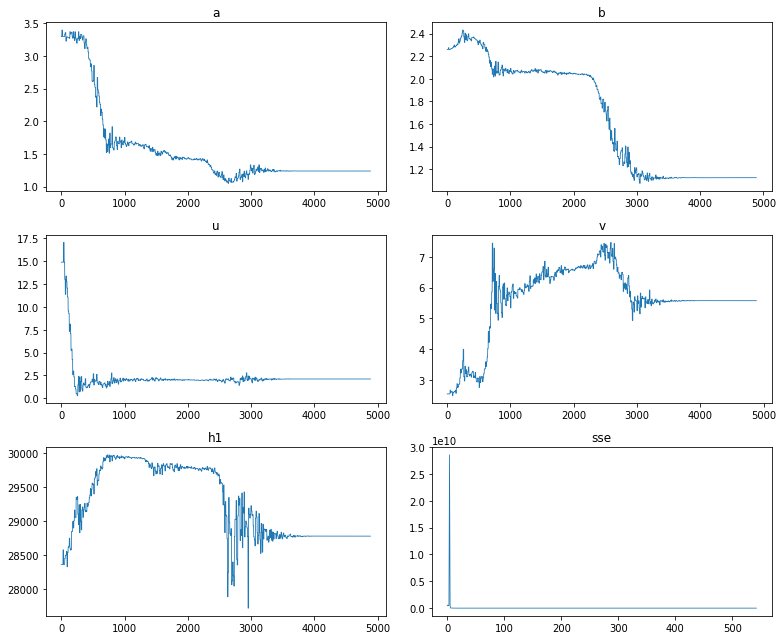

Run 96 Time: 0.82370 minutes

Avg time per run: 1.06615 minutes

Est time remaining: 3.19846 minutes

========Run 97========
{'a': 1.4563623693034284, 'b': 3.8002503306916053, 'h1': 17256.181998432152, 'u': 1.9226945505903528, 'v': 2.680661822055656}
a* = -1.51932	b* = -2.36785	            h1* = 2.51712	u* = 0.74493	v* = 1.74485
a = 1.21886	b = 1.09368	            h1 = 27674.35158	u = 2.10630	v = 5.72505
Success: True, Optimization terminated successfully.
Iterations: 290
SSE: 759.3917039718447


Height  Suspended Mass
0    4430.75    2.143150e+09
1    5776.50    2.480331e+09
2    7122.25    2.694441e+09
3    8468.00    2.851396e+09
4    9813.75    2.973801e+09
5   11159.50    3.072234e+09
6   12505.25    3.152449e+09
7   13851.00    3.217811e+09
8   15196.75    3.270308e+09
9   16542.50    3.311006e+09
10  17888.25    3.340235e+09
11  19234.00    3.357596e+09
12  20579.75    3.361784e+09
13  21925.50    3.350088e+09
14  23271.25    3.317138e+09
15  24617.00    3.251303e+09
16  25962.75    3.120451e+09
17  27308.50    2.734477e+09
18  28654.25    0.000000e+00
19  30000.00    0.000000e+00

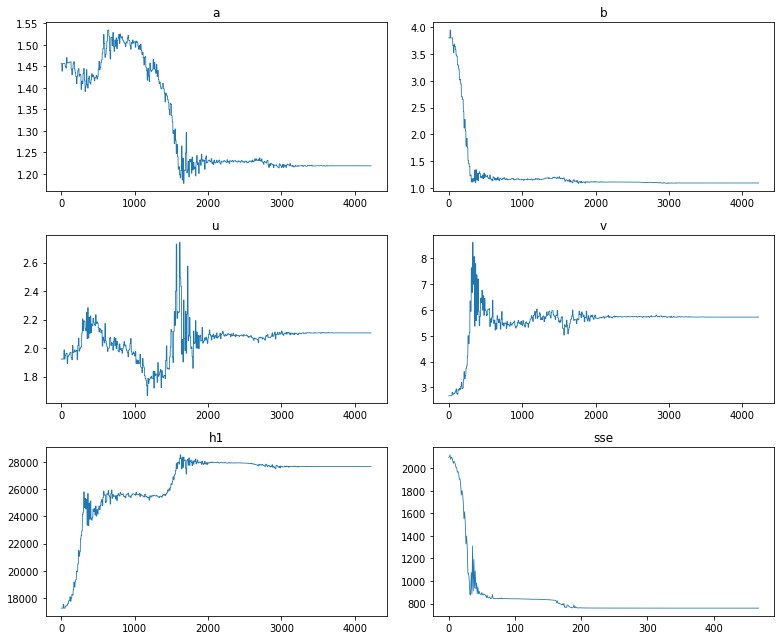

Run 97 Time: 0.71693 minutes

Avg time per run: 1.06259 minutes

Est time remaining: 2.12518 minutes

========Run 98========
{'a': 1.408992875505155, 'b': 4.000866472477632, 'h1': 28642.980906665653, 'u': 1.540745740870546, 'v': 4.407316251373404}
a* = -1.43613	b* = -2.08708	            h1* = 3.18091	u* = 0.74162	v* = 1.71879
a = 1.23785	b = 1.12405	            h1 = 28779.10849	u = 2.09933	v = 5.57775
Success: True, Optimization terminated successfully.
Iterations: 335
SSE: 749.979563954299


Height  Suspended Mass
0    4430.75    2.005777e+09
1    5776.50    2.348651e+09
2    7122.25    2.567164e+09
3    8468.00    2.727179e+09
4    9813.75    2.851479e+09
5   11159.50    2.950788e+09
6   12505.25    3.030963e+09
7   13851.00    3.095450e+09
8   15196.75    3.146304e+09
9   16542.50    3.184658e+09
10  17888.25    3.210933e+09
11  19234.00    3.224879e+09
12  20579.75    3.225479e+09
13  21925.50    3.210633e+09
14  23271.25    3.176440e+09
15  24617.00    3.115404e+09
16  25962.75    3.011167e+09
17  27308.50    2.816007e+09
18  28654.25    2.100646e+09
19  30000.00    0.000000e+00

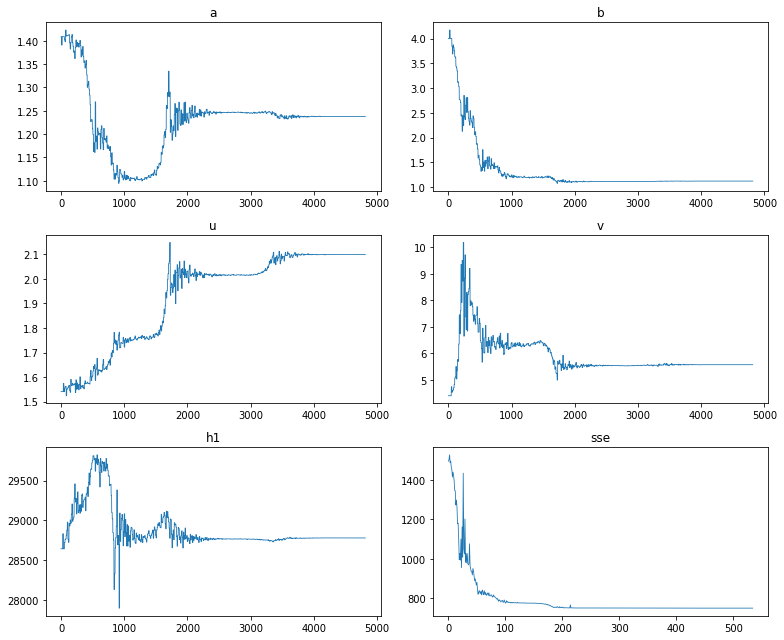

Run 98 Time: 0.81302 minutes

Avg time per run: 1.06007 minutes

Est time remaining: 1.06007 minutes

========Run 99========
{'a': 2.877949504392409, 'b': 8.172456695312952, 'h1': 26221.18130123523, 'u': 0.07079019345967519, 'v': 5.039746860957433}
a* = -1.43606	b* = -2.08706	            h1* = 3.18096	u* = 0.74164	v* = 1.71877
a = 1.23786	b = 1.12405	            h1 = 28779.16566	u = 2.09937	v = 5.57768
Success: True, Optimization terminated successfully.
Iterations: 480
SSE: 749.9795640242118


Height  Suspended Mass
0    4430.75    2.005712e+09
1    5776.50    2.348600e+09
2    7122.25    2.567123e+09
3    8468.00    2.727147e+09
4    9813.75    2.851455e+09
5   11159.50    2.950771e+09
6   12505.25    3.030952e+09
7   13851.00    3.095445e+09
8   15196.75    3.146303e+09
9   16542.50    3.184662e+09
10  17888.25    3.210940e+09
11  19234.00    3.224890e+09
12  20579.75    3.225492e+09
13  21925.50    3.210650e+09
14  23271.25    3.176458e+09
15  24617.00    3.115423e+09
16  25962.75    3.011187e+09
17  27308.50    2.816030e+09
18  28654.25    2.100759e+09
19  30000.00    0.000000e+00

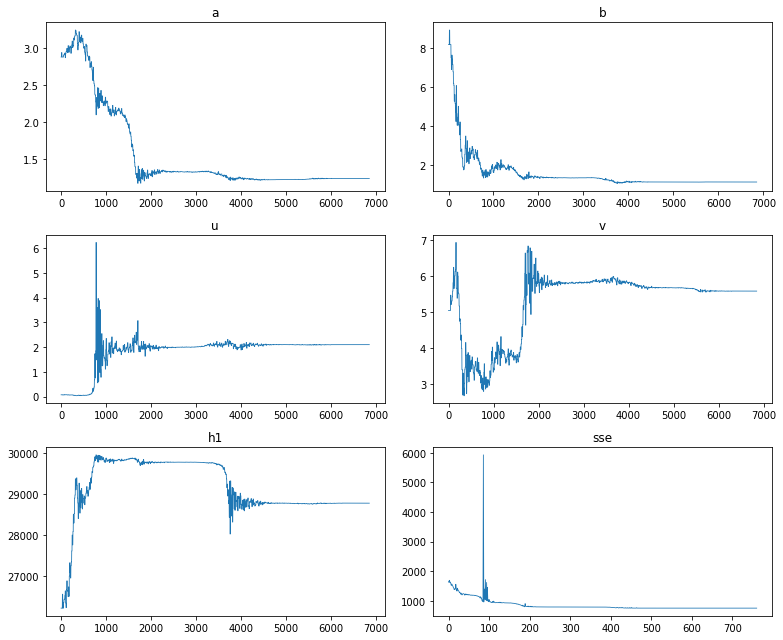

Run 99 Time: 1.14948 minutes

Avg time per run: 1.06096 minutes

Est time remaining: 0.00000 minutes

Total Run Time: 106.09635 minutes


In [101]:
df = obs_df

prior_means = {
    "a": 2,
    "b": 5,
    "h1": 18000,
    "u": 3,
    "v": 3
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True
}

H = 30000

H_tol = H - 100

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

runs = 100

inverted_masses_list = []

a_list = []
b_list = []
h1_list = []
u_list = []
v_list = []
inv_list = []
a_priors = []
b_priors = []
h1_priors = []
u_priors = []
v_priors = []
sse_list = []

params_list = []
for run in range(runs):
    t = process_time()
    
    print("========Run %d========"%(run))
    
    priors = {
        "a":  expon.rvs(scale=prior_means["a"]-1) + 1,
        "b":  expon.rvs(scale=prior_means["b"]-1) + 1,
        "h1": uniform.rvs(10000, 19999),
        "u":  expon.rvs(scale=prior_means["u"]),
        "v": expon.rvs(scale=prior_means["v"])
    }
    print(priors)
    
    out = gaussian_stack_wind_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, 
        config["ERUPTION_MASS"], phi_steps,
        config["DIFFUSION_COEFFICIENT"], 
        config["FALL_TIME_THRESHOLD"], 
        config["EDDY_CONST"],
        invert_params = invert_params,
        priors=priors,
        column_cap=H)
    inversion_table, params, sol, sse, trace, wind_trace, sse_trace = out
    params_no_wind = list(params.values())
    params_no_wind = params_no_wind[:-2]
    a, b, h1, u, v = list(params.values())
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params_no_wind, H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    wind_trace = np.array(wind_trace)
    fig, axs = plt.subplots(3,2, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(wind_trace[:,0], linewidth=.8)
    axs[2].set_title("u")

    axs[3].plot(wind_trace[:,1], linewidth=.8)
    axs[3].set_title("v")


    axs[4].plot(trace[:,2], linewidth=.8)
    axs[4].set_title("h1")

    axs[5].plot(sse_trace, linewidth=.8)
    axs[5].set_title("sse")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    if (not np.isnan(h1)) and (h1 < H_tol) and (not np.isnan(sse)):
        sse_list.append(sol.fun)
        a_list.append(a)
        b_list.append(b)
        h1_list.append(h1)
        u_list.append(u)
        v_list.append(v)
        a_priors.append(priors["a"])
        b_priors.append(priors["b"])
        h1_priors.append(priors["h1"])
        u_priors.append(priors["u"])
        v_priors.append(priors["v"])
        inv_list.append(inv_mass)
        trace = np.asarray(trace)
        wind_trace = np.asarray(wind_trace)
        sse_trace = np.asarray(sse_trace)
        
        np.savetxt("data/colima/sim_traces/trace%d.csv"%(run), trace, delimiter=",")
        np.savetxt("data/colima/sim_traces/wind_trace%d.csv"%(run), wind_trace, delimiter=",")
        np.savetxt("data/colima/sim_traces/sse_trace%d.csv"%(run), sse_trace, delimiter=",")
    else:
        print(">>> FAIL\nSSE: %.2e,\th1: %g"%(sse, h1))
    run_time = process_time() - t
    print("Run %d Time: %.5f minutes\n"%(run, run_time/60))
    avg_run_time = (process_time() - t_tot)/(run+1)
    print("Avg time per run: %.5f minutes\n"%(avg_run_time/60))
    est_time_remaining = avg_run_time * (runs - (run+1))
    print("Est time remaining: %.5f minutes\n"%(est_time_remaining/60))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

Successful Runs:20


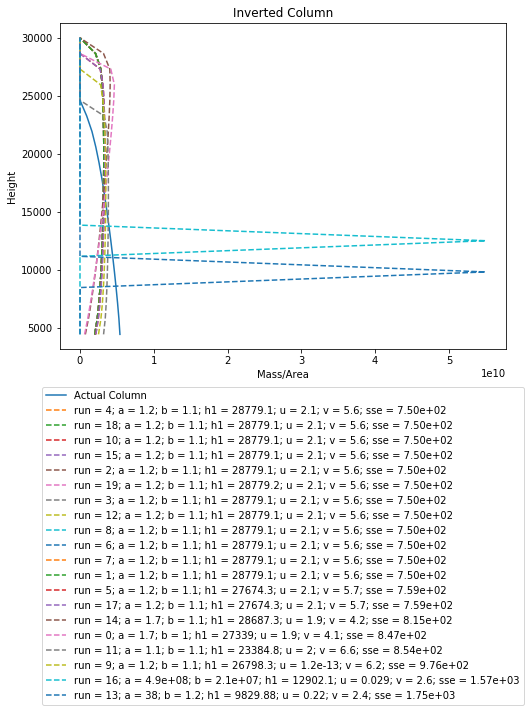

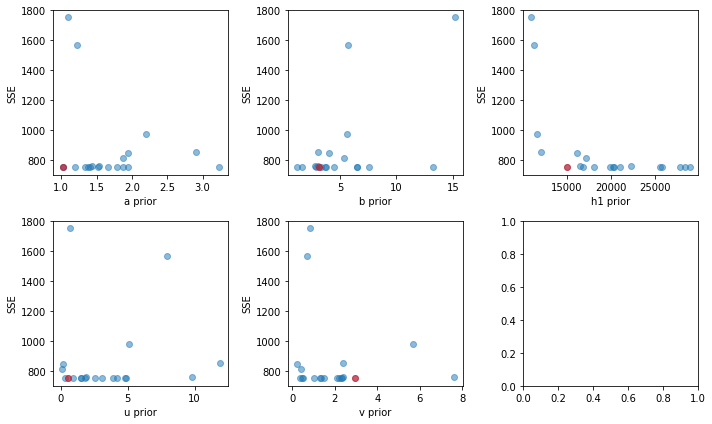

4


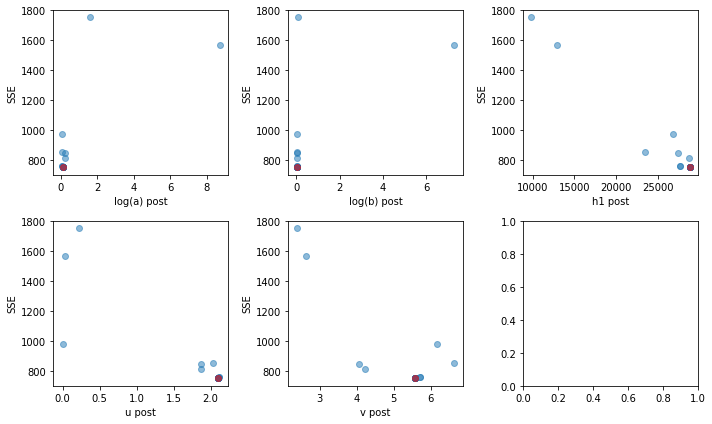

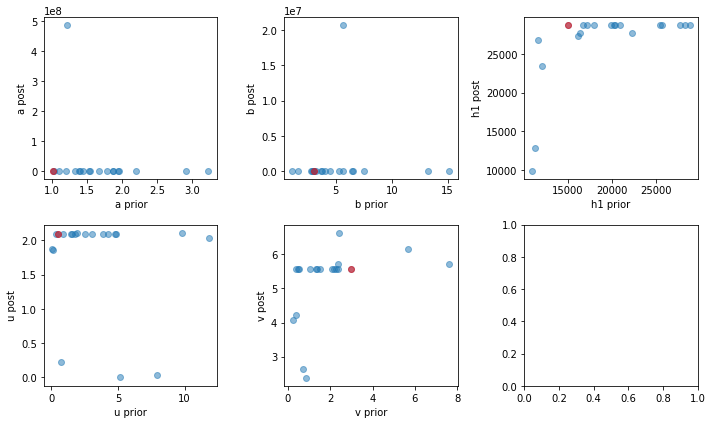

In [98]:
best = np.argsort(sse_list)
print("Successful Runs:" + str(len(sse_list)))
fig, ax1 = plt.subplots(1,1, figsize=(
        8, 6), facecolor='w', edgecolor='k')
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])
ax1.plot(q_mass, inversion_table["Height"], label="Actual Column")
for i in best:
    label = "run = %d; a = %.2g; b = %.2g; h1 = %g; u = %.2g; v = %.2g; sse = %.2e"%(
        i,
        a_list[i],
        b_list[i],
        h1_list[i],
        u_list[i], 
        v_list[i],
        sse_list[i])
    ax1.plot(inv_list[i], 
             inversion_table["Height"], 
             '--', label=label)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Inverted Column")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

# ax1.set_xlim([-10000000,2e8])

# plt.tight_layout()
plt.show()
# plt.savefig("colima/sim_runs.png", dpi=200, format='png')


fig, axs = plt.subplots(2,3, figsize=(
        10, 6), facecolor='w', edgecolor='k')

axs = axs.ravel()

axs[0].scatter(a_priors, sse_list, alpha=.5)
axs[0].set_xlabel("a prior")
axs[0].set_ylabel("SSE")
axs[1].scatter(b_priors, sse_list, alpha=.5)
axs[1].set_xlabel("b prior")
axs[1].set_ylabel("SSE")
axs[2].scatter(h1_priors, sse_list, alpha=.5)
axs[2].set_xlabel("h1 prior")
axs[2].set_ylabel("SSE")
axs[3].scatter(u_priors, sse_list, alpha=.5)
axs[3].set_xlabel("u prior")
axs[3].set_ylabel("SSE")
axs[4].scatter(v_priors, sse_list, alpha=.5)
axs[4].set_xlabel("v prior")
axs[4].set_ylabel("SSE")

top = best[0]

axs[0].plot(a_priors[top], sse_list[top], 'ro', alpha=.5)
axs[1].plot(b_priors[top], sse_list[top], 'ro', alpha=.5)
axs[2].plot(h1_priors[top], sse_list[top], 'ro', alpha=.5)
axs[3].plot(u_priors[top], sse_list[top], 'ro', alpha=.5)
axs[4].plot(v_priors[top], sse_list[top], 'ro', alpha=.5)

plt.tight_layout()
plt.show()
# plt.savefig("colima/sim_priors.png", dpi=200, format='png')

fig, axs = plt.subplots(2,3, figsize=(
        10, 6), facecolor='w', edgecolor='k')

axs = axs.ravel()

axs[0].scatter(np.log10(a_list), sse_list, alpha=.5)
axs[0].set_xlabel("log(a) post")
axs[0].set_ylabel("SSE")
axs[1].scatter(np.log10(b_list), sse_list, alpha=.5)
axs[1].set_xlabel("log(b) post")
axs[1].set_ylabel("SSE")
axs[2].scatter(h1_list, sse_list, alpha=.5)
axs[2].set_xlabel("h1 post")
axs[2].set_ylabel("SSE")
axs[3].scatter(u_list, sse_list, alpha=.5)
axs[3].set_xlabel("u post")
axs[3].set_ylabel("SSE")
axs[4].scatter(v_list, sse_list, alpha=.5)
axs[4].set_xlabel("v post")
axs[4].set_ylabel("SSE")

top = best[0]
print(top)

axs[0].plot(np.log10(a_list[top]), sse_list[top], 'ro', alpha=.5)
axs[1].plot(np.log10(b_list[top]), sse_list[top], 'ro', alpha=.5)
axs[2].plot(h1_list[top], sse_list[top], 'ro', alpha=.5)
axs[3].plot(u_list[top], sse_list[top], 'ro', alpha=.5)
axs[4].plot(v_list[top], sse_list[top], 'ro', alpha=.5)


plt.tight_layout()
plt.show()
# plt.savefig("colima/sim_posts.png", dpi=200, format='png')

fig, axs = plt.subplots(2,3, figsize=(
        10, 6), facecolor='w', edgecolor='k')

axs = axs.ravel()

axs[0].scatter(a_priors, a_list, alpha=.5)
axs[0].set_xlabel("a prior")
axs[0].set_ylabel("a post")
axs[1].scatter(b_priors, b_list, alpha=.5)
axs[1].set_xlabel("b prior")
axs[1].set_ylabel("b post")
axs[2].scatter(h1_priors, h1_list, alpha=.5)
axs[2].set_xlabel("h1 prior")
axs[2].set_ylabel("h1 post")
axs[3].scatter(u_priors, u_list, alpha=.5)
axs[3].set_xlabel("u prior")
axs[3].set_ylabel("u post")
axs[4].scatter(v_priors, v_list, alpha=.5)
axs[4].set_xlabel("v prior")
axs[4].set_ylabel("v post")

axs[0].plot(a_priors[top], a_list[top], 'ro', alpha=.5)
axs[1].plot(b_priors[top], b_list[top], 'ro', alpha=.5)
axs[2].plot(h1_priors[top], h1_list[top], 'ro', alpha=.5)
axs[3].plot(u_priors[top], u_list[top], 'ro', alpha=.5)
axs[4].plot(v_priors[top], v_list[top], 'ro', alpha=.5)

plt.tight_layout()
plt.show()
# plt.savefig("colima/sim_prior_post.png", dpi=200, format='png')

4
18
10
15
2
19
3
12
8
6
7
1


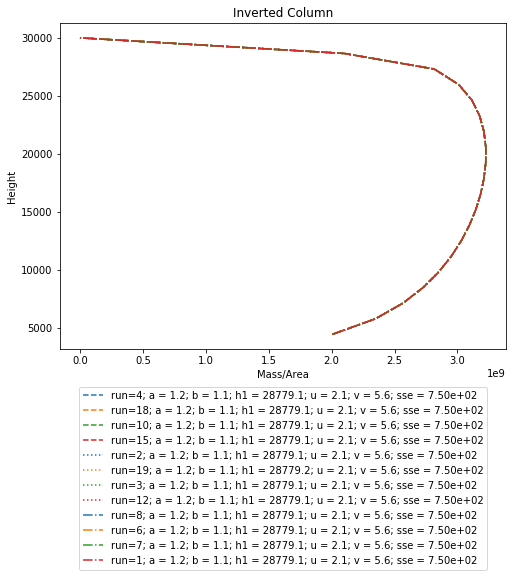

In [100]:
linestyles = [
    "C0--",
    "C1--",
    "C2--",
    "C3--",
    "C0:",
    "C1:",
    "C2:",
    "C3:",
    "C0-.",
    "C1-.",
    "C2-.",
    "C3-.",
    "C0-",
    "C1-",
    "C2-",
    "C3-",
    "C0.",
    "C1.",
    "C2.",
    "C3.",
]
fig, ax1 = plt.subplots(1,1, figsize=(
        8, 6), facecolor='w', edgecolor='k')
# ax1.plot(q_mass, inversion_table["Height"], label="Actual Column")
for actual_i, i in enumerate(best[:12]):
    print(i)
    label = "run=%d; a = %.2g; b = %.2g; h1 = %g; u = %.2g; v = %.2g; sse = %.2e"%(
        i,
        a_list[i],
        b_list[i],
        h1_list[i],
        u_list[i], 
        v_list[i],
        sse_list[i])
    ax1.plot(inv_list[i], 
             inversion_table["Height"], 
             linestyles[actual_i], label=label)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Inverted Column")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")
plt.show()



In [95]:
inversion_table["Height"].values

array([ 4430.75,  5776.5 ,  7122.25,  8468.  ,  9813.75, 11159.5 ,
       12505.25, 13851.  , 15196.75, 16542.5 , 17888.25, 19234.  ,
       20579.75, 21925.5 , 23271.25, 24617.  , 25962.75, 27308.5 ,
       28654.25, 30000.  ])